## Introduction

In [79]:
# Loading packages
import numpy as np
import pandas as pd
from arch import arch_model
import yfinance as yf

import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
from scipy.stats import norm, jarque_bera

from statsmodels.graphics.tsaplots import plot_acf

import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson

from statsmodels.stats.diagnostic import het_arch

from arch.unitroot import ADF, PhillipsPerron, KPSS, ZivotAndrews, VarianceRatio



In [3]:
# Fetch data for the S&P 500
SP500 = yf.download("^GSPC", start="2000-01-01", end="2024-01-26")

# Fetch data for DAX from Yahoo Finance
DAX = yf.download("^GDAXI", start="2000-01-01", end="2024-01-26")

# Read the CSV files for Wig20, kospi200, nikkei225
wig20 = pd.read_csv("wig20_d.csv", sep=",", decimal=".")
kospi200 = pd.read_csv("^kospi_d.csv", sep=",", decimal=".")
nikkei225 = pd.read_csv("^nkx_d.csv", sep=",", decimal=".")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [4]:
# Data Preparation
# Change date as row index
wig20['Data'] = pd.to_datetime(wig20['Data'])
wig20.set_index('Data', inplace=True)

kospi200['Data'] = pd.to_datetime(kospi200['Data'])
kospi200.set_index('Data', inplace=True)

nikkei225['Data'] = pd.to_datetime(nikkei225['Data'])
nikkei225.set_index('Data', inplace=True)

# Select only close values for all indexes
SP500 = SP500['Close'].rename("SP500")
wig20 = wig20['Zamkniecie'].rename("WIG20")
kospi200 = kospi200['Zamkniecie'].rename("KOSPI200")
nikkei225 = nikkei225['Zamkniecie'].rename("NKK225")
DAX = DAX['Close'].rename("DAX")

In [5]:
# Create portfolio
portfolio = pd.concat([SP500, DAX, wig20, kospi200, nikkei225], axis=1)

# Handling missing values
portfolio = portfolio.dropna()

print(portfolio.head())
print(portfolio.tail())

                  SP500          DAX   WIG20  KOSPI200    NKK225
2000-01-04  1399.420044  6586.950195  1796.6   1059.04  19002.86
2000-01-05  1402.109985  6502.069824  1777.0    986.31  18542.55
2000-01-06  1403.449951  6474.919922  1832.1    960.79  18168.27
2000-01-07  1441.469971  6780.959961  1933.2    948.65  18193.41
2000-01-11  1438.560059  6891.250000  1974.9    981.33  18850.92
                  SP500           DAX    WIG20  KOSPI200    NKK225
2024-01-19  4839.810059  16555.130859  2200.91   2472.74  35963.27
2024-01-22  4850.430176  16683.359375  2205.03   2464.35  36546.95
2024-01-23  4864.600098  16627.089844  2196.27   2478.61  36517.57
2024-01-24  4868.549805  16889.919922  2213.36   2469.69  36226.48
2024-01-25  4894.160156  16906.919922  2206.18   2470.34  36236.47


In [6]:

# Calculate log returns for each stock
portfolio['SP_r'] = np.log(portfolio['SP500']) - np.log(portfolio['SP500'].shift(1))
portfolio['DAX_r'] = np.log(portfolio['DAX']) - np.log(portfolio['DAX'].shift(1))
portfolio['WIG20_r'] = np.log(portfolio['WIG20']) - np.log(portfolio['WIG20'].shift(1))
portfolio['KOSPI200_r'] = np.log(portfolio['KOSPI200']) - np.log(portfolio['KOSPI200'].shift(1))
portfolio['NKK225_r'] = np.log(portfolio['NKK225']) - np.log(portfolio['NKK225'].shift(1))

# Drop the first two rows
portfolio = portfolio.iloc[2:]

# Check for missing values
missing_values = portfolio.isnull().sum()

# Print the results
print("Missing Values in Log Returns after removing the first two rows:")
print(missing_values)


Missing Values in Log Returns after removing the first two rows:
SP500         0
DAX           0
WIG20         0
KOSPI200      0
NKK225        0
SP_r          0
DAX_r         0
WIG20_r       0
KOSPI200_r    0
NKK225_r      0
dtype: int64


In [6]:
portfolio.head(10)

,SP500,DAX,WIG20,KOSPI200,NKK225,SP_r,DAX_r,WIG20_r,KOSPI200_r,NKK225_r
2000-01-06,1403.449951,6474.919922,1832.1,960.79,18168.27,0.000955,-0.004184,0.030536,-0.026215,-0.020391
2000-01-07,1441.469971,6780.959961,1933.2,948.65,18193.41,0.026730,0.046182,0.053714,-0.012716,0.001383
2000-01-11,1438.560059,6891.250000,1974.9,981.33,18850.92,-0.002021,0.016134,0.021341,0.033869,0.035502
2000-01-12,1432.250000,6912.810059,1961.3,955.01,18677.42,-0.004396,0.003124,-0.006910,-0.027187,-0.009246
2000-01-13,1449.680054,6955.979980,2032.9,951.05,18833.29,0.012096,0.006225,0.035856,-0.004155,0.008311
2000-01-14,1465.150024,7173.220215,2010.5,948.03,18956.55,0.010615,0.030753,-0.011080,-0.003180,0.006523
2000-01-18,1455.140015,7072.120117,1982.6,981.53,19196.57,-0.006856,-0.014194,-0.013974,0.034726,0.012582
2000-01-19,1455.900024,7091.040039,1971.9,938.78,18897.75,0.000522,0.002672,-0.005412,-0.044531,-0.015689
2000-01-20,1445.569946,7112.660156,1995.2,945.90,19008.01,-0.007121,0.003044,0.011747,0.007556,0.005818
2000-01-21,1441.359985,6992.750000,2003.0,925.16,18878.09,-0.002917,-0.017002,0.003902,-0.022170,-0.006858


In [7]:

# Calculate log returns for each index and apply weight
portfolio['SP500_r'] = 0.2 * np.log(portfolio['SP500']).diff()
portfolio['DAX_r'] = 0.2 * np.log(portfolio['DAX']).diff()
portfolio['WIG20_r'] = 0.2 * np.log(portfolio['WIG20']).diff()
portfolio['KOSPI_r'] = 0.2 * np.log(portfolio['KOSPI200']).diff()
portfolio['NKK225_r'] = 0.2 * np.log(portfolio['NKK225']).diff()

# Creating all indexes log returns together
portfolio['PORTFOLIO_r'] = portfolio[['SP500_r', 'DAX_r', 'KOSPI_r', 'WIG20_r', 'NKK225_r']].sum(axis=1)

# Omit the first row to handle missing values caused by the diff function
portfolio = portfolio.iloc[1:]

portfolio.head()


,SP500,DAX,WIG20,KOSPI200,NKK225,SP_r,DAX_r,WIG20_r,KOSPI200_r,NKK225_r,SP500_r,KOSPI_r,PORTFOLIO_r
2000-01-07,1441.469971,6780.959961,1933.2,948.65,18193.41,0.026730,0.009236,0.010743,-0.012716,0.000277,0.005346,-0.002543,0.023059
2000-01-11,1438.560059,6891.250000,1974.9,981.33,18850.92,-0.002021,0.003227,0.004268,0.033869,0.007100,-0.000404,0.006774,0.020965
2000-01-12,1432.250000,6912.810059,1961.3,955.01,18677.42,-0.004396,0.000625,-0.001382,-0.027187,-0.001849,-0.000879,-0.005437,-0.008923
2000-01-13,1449.680054,6955.979980,2032.9,951.05,18833.29,0.012096,0.001245,0.007171,-0.004155,0.001662,0.002419,-0.000831,0.011667
2000-01-14,1465.150024,7173.220215,2010.5,948.03,18956.55,0.010615,0.006151,-0.002216,-0.003180,0.001305,0.002123,-0.000636,0.006726


In [8]:
# Check for missing values
print(portfolio.isnull().values.any())

False


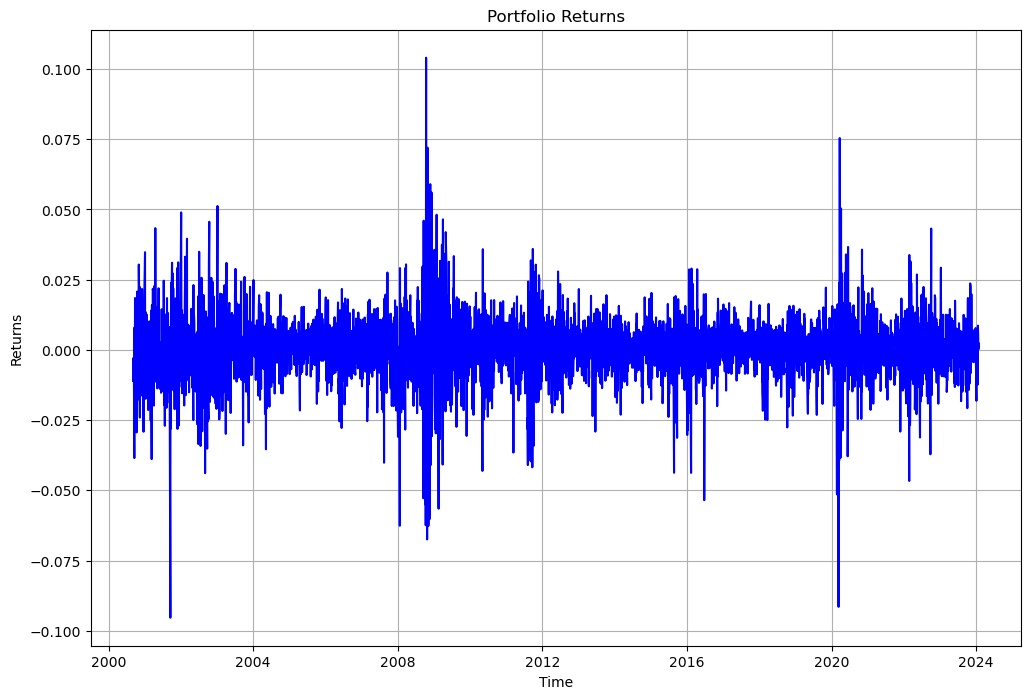

Skewness of Portfolio Returns: -0.4420281915955097
Kurtosis of Portfolio Returns: 8.694320279719864


In [179]:

# Plot portfolio returns
plt.figure(figsize=(12, 8))
plt.plot(portfolio['PORTFOLIO_r'], color='blue')
plt.title('Portfolio Returns')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.grid(True)
plt.savefig('portfolio_return.png')
plt.show()

# Calculate skewness and kurtosis
portfolio_skewness = skew(portfolio['PORTFOLIO_r'])
portfolio_kurtosis = kurtosis(portfolio['PORTFOLIO_r'])

print("Skewness of Portfolio Returns:", portfolio_skewness)
print("Kurtosis of Portfolio Returns:", portfolio_kurtosis)



1. **Volatility Clustering**: There are periods where the returns show higher fluctuations (volatility), indicated by the dense vertical sections. This clustering of high and low volatility is a common phenomenon in financial time series and is one of the stylized facts that models like GARCH aim to capture.

2. **Outliers**: There are a few extreme values, especially one significant negative return. Such outliers can heavily influence measures of skewness and kurtosis.

3. **Skewness**: Skewness measures the asymmetry of the distribution. A skewness value of 0 indicates a symmetric distribution, while positive skewness indicates that the distribution has a tail to the right (right-skewed) and negative skewness indicates a tail to the left (left-skewed). The skewness value of approximately -0.444 suggests a slight negative skew. Negative skewness indicates that there's a higher probability of negative returns being further from the mean than positive returns.

4. **Kurtosis**: Kurtosis measures the "peakedness" of the distribution and the presence of outliers. A kurtosis value of 3 indicates a normal distribution (mesokurtic), higher than 3 indicates heavy tails (leptokurtic), and lower than 3 indicates lighter tails (platykurtic). A kurtosis of 8.364 indicates that the distribution is leptokurtic, meaning it has heavier tails and a sharper peak compared to a normal distribution. This suggests that there may be more extreme values (outliers) in the distribution of portfolio returns. High kurtosis is typical in financial returns, which tend to exhibit larger than expected extreme movements (i.e., higher probability of extreme events than would be predicted by a normal distribution).

For building a volatility model like GARCH, the presence of high kurtosis particularly motivates the use of a model with a heavier-tailed distribution (like the Student's t-distribution) for the innovations/errors, which can provide a better fit and more accurate risk forecasts.

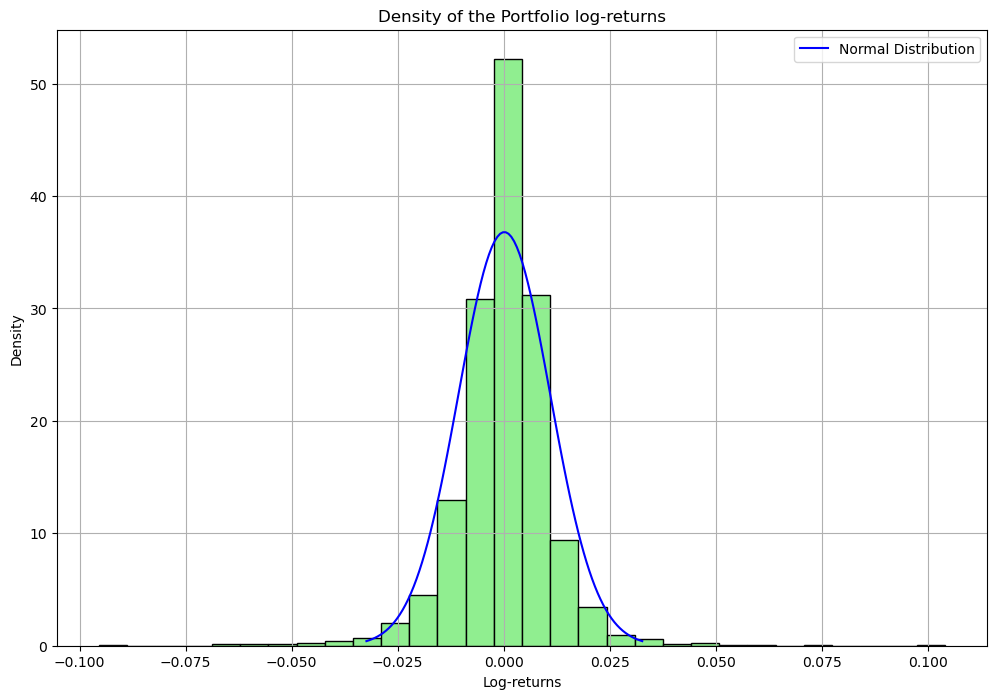

In [180]:

# Plotting Histogram of Log-returns
plt.figure(figsize=(12, 8))
plt.hist(portfolio['PORTFOLIO_r'], bins=30, density=True, color='lightgreen', edgecolor='black')
plt.title('Density of the Portfolio log-returns')
plt.xlabel('Log-returns')
plt.ylabel('Density')
plt.savefig('prtoflio_log_return')
plt.grid(True)

# Overlaying normal distribution curve
mu, sigma = np.mean(portfolio['PORTFOLIO_r']), np.std(portfolio['PORTFOLIO_r'])
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, norm.pdf(x, mu, sigma), color='blue', label='Normal Distribution')

plt.legend()
plt.show()



1. **Histogram**: The histogram bars represent the frequency of log-return observations within specific ranges (bins). The 'lightgreen' bars show the actual distribution of the portfolio's log-returns.

2. **Normal Distribution Curve**: The blue line represents the normal distribution with the same mean (mu) and standard deviation (sigma) as the portfolio's log-returns. This curve is generated using the probability density function (pdf) of a normal distribution.

3. **Comparison**: By comparing the histogram to the normal distribution curve, how closely the portfolio's returns follow a normal distribution. Deviations between the histogram and the blue curve suggest departures from normality.

While visual inspection can provide valuable insights, formal statistical tests (like the Jarque-Bera test) are used to conclusively determine the normality of the distribution. If the dataset has already shown a high kurtosis, the normality assumption may not hold, which seems consistent with what the histogram suggests visually – the log-returns exhibit a peakedness and potentially fat tails that deviate from the normal distribution.

###### Jarque-Bera test

In [11]:
# Jarque-Bera test
jb_stat, jb_p_value = jarque_bera(portfolio['PORTFOLIO_r'])
print("Jarque-Bera statistic:", jb_stat)
print("p-value:", jb_p_value)

Jarque-Bera statistic: 15687.529604210837
p-value: 0.0


The Jarque-Bera test is a type of statistical test that compares whether the sample data has the skewness and kurtosis matching a normal distribution. The test statistics are calculated from the sample skewness and kurtosis, and a chi-square distribution is used to determine the significance.

Here's what the results indicate:

- **Jarque-Bera Statistic**: The value of 15687.53 is very high. Under the null hypothesis (which is that the data is normally distributed), we would expect a Jarque-Bera statistic close to zero. A large value like this suggests that the sample skewness and kurtosis are substantially different from those of a normal distribution.

- **p-value**: A p-value of 0.0 (which typically indicates a value that is very close to zero but rounded down for reporting) allows you to reject the null hypothesis at any conventional significance level (e.g., 0.01, 0.05, 0.10).

Interpretation:
- The Jarque-Bera test result is indicating that the returns are not normally distributed. The null hypothesis of normality is strongly rejected.
- The high test statistic suggests that the distribution of the portfolio returns has either significant skewness, high kurtosis, or both, which is common in financial return data that often exhibits "fat tails" and asymmetry.

This also aligns with the notion that financial time series data often exhibit leptokurtic behavior, which means they tend to have sharper peaks and heavier tails than the normal distribution.

###### The Dickey-Fuller Test

The Dickey-Fuller test checks if a time series is non-stationary due to the presence of a unit root. If the test statistic is more negative than the critical value, or if the p-value is below a threshold (like 0.05), the null hypothesis of a unit root is rejected, suggesting the series is stationary. There are three versions: the original Dickey-Fuller test, the Augmented Dickey-Fuller (ADF) test which allows for higher-order autoregressive processes, and the Phillips-Perron test which adjusts for serial correlation and heteroskedasticity.

In [12]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Function to perform the Augmented Dickey-Fuller (ADF) test
def dickey_fuller_test(series):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(series, autolag='AIC')
    
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 'Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    
    print(dfoutput)


dickey_fuller_test(portfolio['PORTFOLIO_r'])


Results of Dickey-Fuller Test:
Test Statistic                -1.271710e+01
p-value                        1.001036e-23
Lags Used                      3.100000e+01
Number of Observations Used    5.291000e+03
Critical Value (1%)           -3.431587e+00
Critical Value (5%)           -2.862086e+00
Critical Value (10%)          -2.567061e+00
dtype: float64


The results of the Dickey-Fuller test indicate the following:

- **Test Statistic**: The value of -12.7171 is much lower than all the critical values at the 1%, 5%, and 10% levels. This suggests a strong rejection of the null hypothesis.

- **p-value**: With a p-value essentially at 0 (1.001036e-23 is statistically indistinguishable from zero for most practical purposes), there is strong evidence against the null hypothesis.

- **Lags Used**: The test used 31 lags in the calculation of the test statistic, which was determined by the test procedure, likely based on an information criterion like AIC.

- **Number of Observations Used**: The test used 5,291 observations from your time series after accounting for the lags.

- **Critical Values**: These are the cutoff points for the test statistic at the 1%, 5%, and 10% levels. If the test statistic is below these values, the null hypothesis of a unit root can be rejected at these confidence levels.

Interpretation:
- Since the test statistic (-12.7171) is much smaller (more negative) than the critical value at 1% (-3.431587), the null hypothesis of the presence of a unit root can be rejected with more than 99% confidence. This indicates that the time series is stationary.

- The extremely small p-value further confirms the rejection of the null hypothesis.

Overall, this Dickey-Fuller test result tells us that the time series does not have a unit root and is stationary, meaning that it is suitable for use in time series forecasting models that assume stationarity without the need for differencing or detrending the data.

###### The Durbin Watson Test

The Durbin-Watson test statistic is a measure of autocorrelation in the residuals of a regression model. The statistic ranges between 0 and 4, where:

- A value close to 2 indicates no significant autocorrelation.
- Values significantly below 2 indicate positive autocorrelation (residuals are correlated with one another).
- Values significantly above 2 indicate negative autocorrelation (residuals are inversely correlated with one another).

In [13]:

# Fit linear regression model to squared log returns
X = sm.add_constant(portfolio['PORTFOLIO_r']**2)
model = sm.OLS(X, X).fit()

# Perform Durbin-Watson test
dw_test_statistic = durbin_watson(model.resid)

print("Durbin-Watson Test Statistic:", dw_test_statistic)


Durbin-Watson Test Statistic: [1.60546875 1.62196451]



- A Durbin-Watson statistic close to 2 indicates there is no autocorrelation detected.
- A statistic of 1.60546875 and 1.62196451 suggests slight positive autocorrelation in the residuals, as the values are less than 2.

If there is positive autocorrelation in the residuals, it means that the residuals are not completely random, which might indicate that the model could be improved by including additional explanatory variables, lagged variables, or by using time series analysis techniques if the data is ordered in time.

###### Autocorrelation Function (ACF)

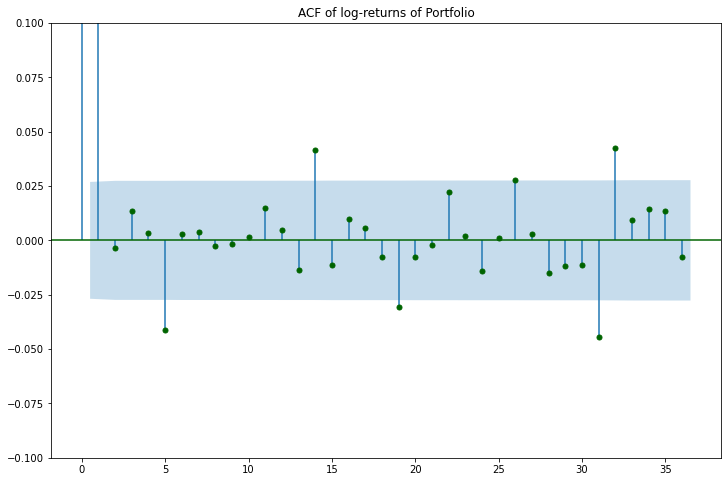

In [14]:

# Plot ACF of log-returns
fig, ax = plt.subplots(figsize=(12, 8))
plot_acf(portfolio['PORTFOLIO_r'], lags=36, alpha=0.05, color='darkgreen', ax=ax)
plt.ylim(-0.1, 0.1)  # rescale the vertical axis
plt.title("ACF of log-returns of Portfolio")
plt.show()


In this plot, there's a significant spike at lag 0, which is always the case as it represents the correlation of the series with itself. However, there don't appear to be any other significant spikes extending beyond the confidence interval for subsequent lags. This indicates that there are no significant linear relationships between past and present values in the log-returns of the portfolio; in other words, the log-returns are largely random and exhibit little to no autocorrelation.

This lack of autocorrelation is a common characteristic of efficient financial markets, where prices reflect all available information and each price change is independent of past changes. This also suggests that past returns are not useful in predicting future returns on a linear basis, which supports the random walk hypothesis. However, it is important to note that the ACF does not measure non-linear dependencies, which can be present in financial time series data.

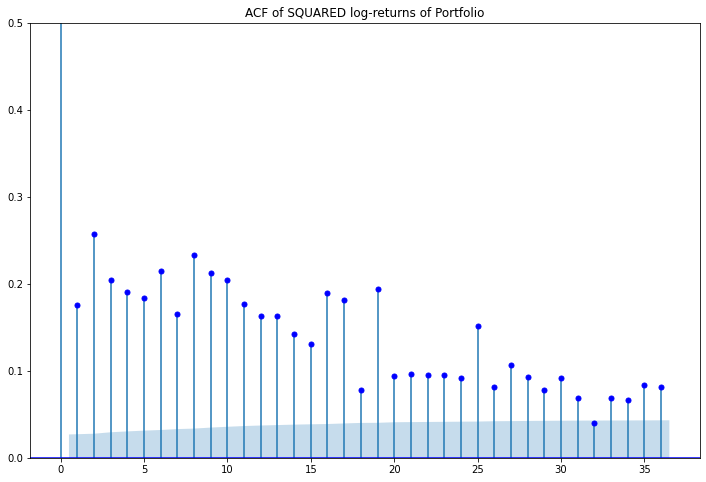

In [15]:

# Plot ACF of squared log-returns
fig, ax = plt.subplots(figsize=(12, 8))
plot_acf(portfolio['PORTFOLIO_r']**2, lags=36, alpha=0.05, color='blue', ax=ax)
ax.set_ylim(0, 0.5)  # rescale the vertical axis
ax.set_title("ACF of SQUARED log-returns of Portfolio")
plt.show()

In the plot, we can observe several points above the significance level, particularly at the lower lags. This indicates strong autocorrelation in the squared returns, which suggests volatility clustering—periods of high volatility tend to be followed by periods of high volatility, and periods of low volatility tend to be followed by periods of low volatility.

This is a hallmark of financial time series data and implies that while returns themselves may not be predictable (as indicated by the previous ACF plot of the raw log-returns), the magnitude of these returns (i.e., the volatility) exhibits a more predictable pattern. This kind of insight is valuable for risk management and derivative pricing, which often depends on understanding the behavior of volatility rather than the direction of price movements.

###### ARCH Test

The Engle's ARCH test (Autoregressive Conditional Heteroskedasticity) is designed to test for ARCH effects in the error variance, which is a common feature in financial time series data. The test checks for the presence of significant autocorrelation in the squared residuals from a time series regression, which would suggest volatility clustering.

The ARCH test statistic and p-value provide insight into the presence of autoregressive conditional heteroscedasticity (ARCH) effects in the squared log returns of the portfolio.

- **ARCH Test Statistic**: The test statistic is a measure of the magnitude of ARCH effects in the data. A larger test statistic indicates stronger evidence of ARCH effects.

- **p-value**: The p-value associated with the test statistic indicates the probability of observing the data if there were no ARCH effects present. A small p-value (typically below a chosen significance level, such as 0.05) suggests that the null hypothesis of no ARCH effects should be rejected in favor of the alternative hypothesis that ARCH effects are present.

In [16]:

# Perform ARCH test
arch_test_result = het_arch(portfolio['PORTFOLIO_r']**2, maxlag=5)

# Display ARCH test results
print("ARCH test statistic:", arch_test_result[0])
print("p-value:", arch_test_result[1])
print("ARCH test statistic (F-statistic):", arch_test_result[2])
print("p-value:", arch_test_result[3])



ARCH test statistic: 116.85377344232244
p-value: 1.4551562619206766e-23
ARCH test statistic (F-statistic): 23.868863419225132
p-value: 8.09583355365378e-24


C:\Users\Afat\AppData\Local\Temp/ipykernel_15348/1982123518.py:2: FutureWarning: the 'maxlag' keyword is deprecated, use 'nlags' instead.
  arch_test_result = het_arch(portfolio['PORTFOLIO_r']**2, maxlag=5)


In this case, the ARCH test statistic is approximately 116.85, and the p-value is approximately 1.44e-23, which is very close to zero. This suggests strong evidence against the null hypothesis of no ARCH effects, indicating that ARCH effects are likely present in the squared log returns of the portfolio.

The low p-value along with the high test statistic suggests that the null hypothesis of no ARCH effects can be rejected. This means there is strong evidence of ARCH effects at least up to the fifth lag.

Given this result, it would be appropriate to consider ARCH-type models (such as GARCH models) to model the volatility of the portfolio returns. These models can capture the observed time-varying volatility (volatility clustering) in the return series. 

This result, in conjunction with the previous ACF analysis on the squared log-returns, provides further evidence that the volatility in the portfolio returns is not constant over time and should be modeled with an appropriate time-varying volatility model for better forecasts and risk assessment.

## Modelling ARCH and GARCH

### Split data in-sample and out-of-sample

In [64]:

# Calculate the split point
split_point = int(len(portfolio) * 0.9)

# Split the data
in_sample = portfolio.iloc[:split_point]
out_sample = portfolio.iloc[split_point:]

# Print the split date and the head of out-of-sample to verify
print(f"Split date: {in_sample.index[-1]}")
print(out_sample.head())
in_sample.head()


Split date: 2021-09-01 00:00:00
                  SP500           DAX    WIG20  KOSPI200    NKK225      SP_r  \
2021-09-02  4536.950195  15840.589844  2391.94   3175.85  28543.51  0.002839   
2021-09-03  4535.430176  15781.200195  2380.82   3201.06  29128.11 -0.000335   
2021-09-07  4520.029785  15843.089844  2394.79   3187.42  29916.14 -0.003401   
2021-09-08  4514.069824  15610.280273  2364.63   3162.99  30181.21 -0.001319   
2021-09-09  4493.279785  15623.150391  2356.39   3114.70  30008.19 -0.004616   

               DAX_r   WIG20_r  KOSPI200_r  NKK225_r  ...  MACD_Histogram  \
2021-09-02  0.001030  0.008725   -0.009767  0.003246  ...        0.000294   
2021-09-03 -0.003756 -0.004660    0.007907  0.020274  ...        0.000294   
2021-09-07  0.003914  0.005851   -0.004270  0.026694  ...        0.000393   
2021-09-08 -0.014804 -0.012674   -0.007694  0.008821  ...       -0.000294   
2021-09-09  0.000824 -0.003491   -0.015385 -0.005749  ...       -0.000724   

            Lagged_Close

,SP500,DAX,WIG20,KOSPI200,NKK225,SP_r,DAX_r,WIG20_r,KOSPI200_r,NKK225_r,...,MACD_Histogram,Lagged_Close,Lagged_Return,Lagged_Close_5d,Lagged_Return_5d,Log_Return,ROC_Short_Term,ROC_Medium_Term,ROC_Long_Term,Volatility
2000-04-11,1500.589966,7442.660156,2132.4,855.05,20522.52,-0.002576,-0.009932,-0.039223,-0.017529,-0.004693,...,0.000179,1504.459961,0.008554,1494.729980,-0.005775,-0.002576,-0.473561,-0.003335,6.487501,0.013717
2000-04-12,1467.170044,7443.069824,2174.1,837.01,20833.21,-0.022523,0.000055,0.019367,-0.021324,0.015026,...,0.000198,1500.589966,-0.014790,1487.369995,-0.015993,-0.022523,-2.741096,-3.940153,5.454690,0.013253
2000-04-14,1356.560059,7214.830078,2121.0,800.89,20434.68,-0.078383,-0.031145,-0.024727,-0.044112,-0.019315,...,-0.002192,1467.170044,-0.001880,1501.339966,0.004316,-0.078383,-8.828430,-11.188503,0.069346,0.014850
2000-04-17,1401.439941,7187.140137,1963.7,707.72,19008.64,0.032548,-0.003845,-0.077057,-0.123675,-0.072340,...,-0.004155,1356.560059,-0.039536,1516.349976,0.016236,0.032548,-6.482138,-8.033549,2.541889,0.016229
2000-04-18,1441.609985,7196.490234,2005.5,747.30,18969.52,0.028260,0.001300,0.021063,0.054418,-0.002060,...,-0.000709,1401.439941,-0.048874,1504.459961,0.008554,0.028260,-4.273657,-4.385400,2.847994,0.016736


### ARCH (1)

In [90]:
# ARCH(1) constant mean

#Resacle the data: Multiply your returns data by 100 to rescale
returns_scaled = in_sample['PORTFOLIO_r'] * 100

# Define the ARCH(1) model on the scaled returns series
arch1_model = arch_model(returns_scaled, vol='ARCH', p=1)

# Fit the ARCH(1) model
arch1_results = arch1_model.fit(disp='off')

arch1_pred = arch1_results.conditional_volatility

# Print the summary of the fitted model
print(arch1_results.summary())



                      Constant Mean - ARCH Model Results                      
Dep. Variable:            PORTFOLIO_r   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -6953.96
Distribution:                  Normal   AIC:                           13913.9
Method:            Maximum Likelihood   BIC:                           13933.3
                                        No. Observations:                 4736
Date:                Sun, Jun 23 2024   Df Residuals:                     4735
Time:                        13:41:23   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0616  1.797e-02      3.428  6.074e-04 [2.

# CHANGE it ! 
The ARCH model results:


- **Mean Model**: 
   - The `mu` coefficient is estimated at 0.0519, which can be interpreted as the average return of the portfolio when scaled by 100. The p-value associated with `mu` is 0.0048 (below the 0.05 threshold), indicating that the mean return is statistically significantly different from zero.

- **Volatility Model**:
   - **omega**: The baseline level of variance (when there is no information about volatility from previous time periods) is estimated to be 0.8659, which is statistically significant (p-value virtually 0).
   - **alpha[1]**: The estimated parameter for the ARCH term is 0.3120, which measures the impact of the squared return from the previous time period on the current period's variance. This is also statistically significant with a p-value of approximately \(8.86 \times 10^{-8}\), indicating that past volatility (squared returns) has a substantial impact on current volatility.

- **Model Fit**:
   - The **Log-Likelihood** is -6259.63, which indicates the likelihood of observing the data given the model; higher values typically indicate a better fit.
   - **AIC** and **BIC** are 12525.3 and 12544.3, respectively. These are measures of the model's fit that penalize for the number of estimated parameters; lower values are generally preferred.

- **Observations**: The model was fit using 4,258 observations, with 4,257 degrees of freedom remaining after model estimation, suggesting all data points were utilized.

- **Robust Covariance Estimator**: The use of a robust covariance estimator suggests that the standard errors of the model coefficients are calculated in a way that is resilient to certain assumptions being violated, such as homoscedasticity.

Given these results, your ARCH model appears to adequately capture the dynamics of volatility in your portfolio returns, with significant ARCH effects. This implies that past periods of high volatility are likely to be followed by periods of high volatility, which is a characteristic known as volatility clustering.

These results can be used as a basis for forecasting future volatility, which is valuable for risk management and other financial applications. However, for actual forecasting, it might be worth considering extending the model to a GARCH model, which can capture longer-term volatility trends and mean-reversion effects that are typical in financial time series data.

In [19]:
#ARCH(1) zero mean

#Resacle the data: Multiply your returns data by 100 to rescale
returns_scaled = in_sample['PORTFOLIO_r'] * 100

# Define the ARCH(1) model on the scaled returns series
arch1_model = arch_model(returns_scaled,mean='Zero', vol='ARCH', p=1)

# Fit the ARCH(1) model
arch1_results = arch1_model.fit(disp='off')

# Print the summary of the fitted model
print(arch1_results.summary())



                        Zero Mean - ARCH Model Results                        
Dep. Variable:            PORTFOLIO_r   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -7059.58
Distribution:                  Normal   AIC:                           14123.2
Method:            Maximum Likelihood   BIC:                           14136.1
                                        No. Observations:                 4790
Date:                Thu, Jun 20 2024   Df Residuals:                     4790
Time:                        19:24:08   Df Model:                            0
                            Volatility Model                            
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.8645  4.346e-02     19.893  4.669e-88 [  0.779,  0.95

# Change it!

##### Model Results Interpretation

- **Mean Model**: The model is specified with a 'Zero Mean', indicating that it does not account for the average return in the series. This is appropriate if we are solely interested in modeling and forecasting the volatility rather than the returns themselves.

- **Volatility Model**:
   - **omega (0.8748)**: This parameter is the baseline level of variance when there is no information from previous time periods. The very small p-value (approximately \(1.037 x 10^(-79)\)) indicates that omega is significantly different from zero, meaning there's a substantial base level of volatility inherent in the data.
   - **alpha[1] (0.3005)**: This coefficient represents the impact of the squared return from the previous time period on the current volatility. Its significant value (p-value around \(5.622 x 10^(-08)\)) implies that past volatility has a substantial and statistically significant effect on current volatility, a classic sign of volatility clustering.

- **Log-Likelihood**: The value is -6264.84, which provides a measure of the fit of the model to your data. This value is useful for comparing with other models using the same data.

- **AIC and BIC**: The AIC is 12533.7, and BIC is 12546.4. These metrics help in model selection, where lower values are preferred. They account for the likelihood function and penalize for the number of parameters in the model, helping to balance goodness-of-fit with complexity.

- **Number of Observations**: The model is fitted on 4,258 observations, ensuring a robust dataset for analysis.

##### Model Adequacy and Further Actions

Given the significant coefficients and robust parameter estimates, the ARCH(1) model seems well-specified for capturing the volatility dynamics in the portfolio returns. However, consider the following for comprehensive analysis and application:

1. **Model Diagnostics**: After fitting the model, it's crucial to check the residuals to ensure they behave like white noise (no pattern, zero mean, and constant variance). This can be done by plotting the residuals and their ACF, or using statistical tests like the Ljung-Box test.

2. **Forecasting and Validation**: Use the fitted model to forecast future volatility and validate these forecasts against the out-of-sample data. This will help in assessing the model's predictive power and its practical utility in forecasting scenarios.

3. **Model Comparisons**: Depending on the results and requirements, consider comparing the Zero Mean ARCH model with other models like a GARCH model or an ARCH model with a mean component. This will help in understanding whether including additional complexity or different specifications might improve the model's performance.

4. **Alternative Distributions**: If your returns data exhibit heavy tails or skewness, consider using alternative error distributions such as the Student's t-distribution in the ARCH model framework to better capture these characteristics.

Overall, your approach in fitting a Zero Mean ARCH model is valid and aligns well with the objective of understanding and forecasting the volatility of portfolio returns. Make sure to perform the necessary diagnostic checks and validations to ensure the model's assumptions hold true and that it provides reliable forecasts.

#### Standardized Residuals Check

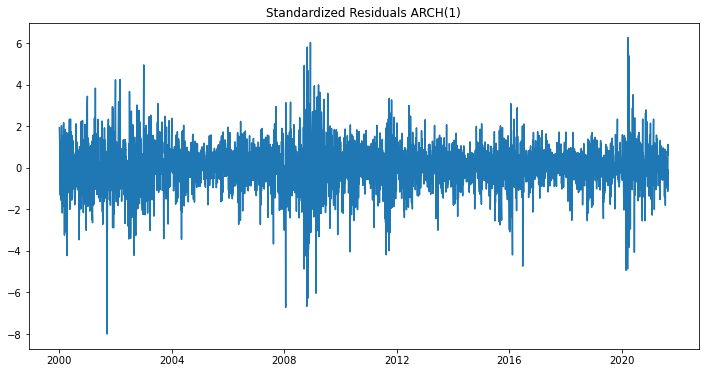

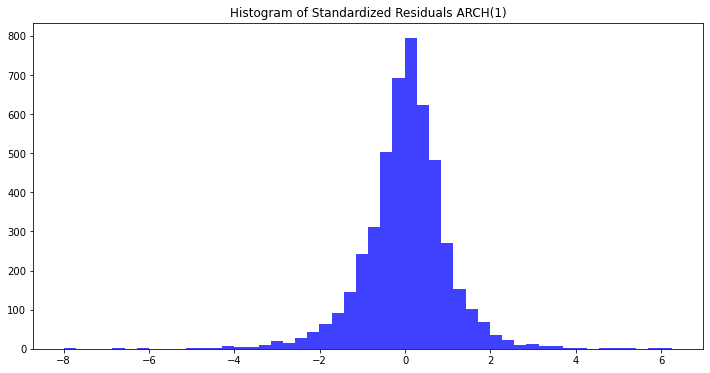

In [20]:
# Compute standardized residuals
std_resida1 = arch1_results.std_resid 

# Plot standardized residuals
plt.figure(figsize=(12, 6))
plt.plot(std_resida1)
plt.title('Standardized Residuals ARCH(1)')
plt.show()

# Histogram of standardized residuals
plt.figure(figsize=(12, 6))
plt.hist(std_resida1, bins=50, alpha=0.75, color='blue')
plt.title('Histogram of Standardized Residuals ARCH(1)')
plt.show()


# Chnage
##### Standardized Residuals Plot:
- The graph should show the standardized residuals fluctuating randomly around the zero line without any discernible pattern or trend, which is what one would expect from an effective volatility model.

##### Histogram of Standardized Residuals:
- Ideally, this histogram should resemble the bell shape of a normal distribution. In financial time series, deviations such as heavier tails than a normal distribution are commonly observed. These heavier tails would appear as bars that are taller than the normal distribution at the extremes of the histogram.

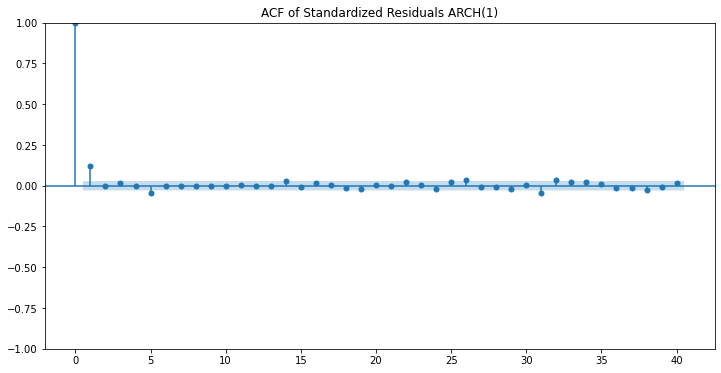

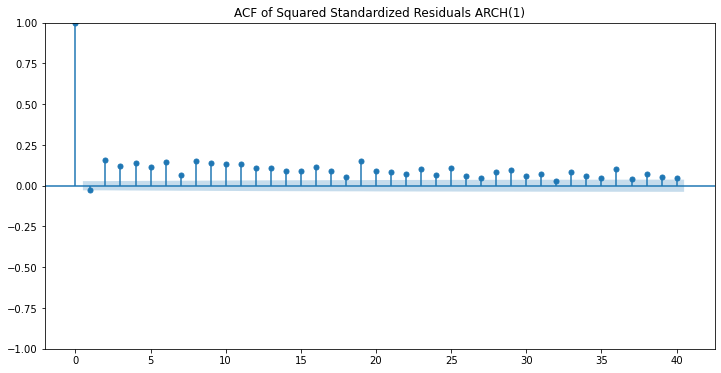

In [21]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

# Create a figure and axis with larger size
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the ACF on these axis
plot_acf(std_resida1, ax=ax, lags=40, alpha=0.05)
ax.set_title('ACF of Standardized Residuals ARCH(1)')
plt.show()

# Create a new figure and axis for the squared residuals
fig, ax = plt.subplots(figsize=(12, 6))
plot_acf(std_resida1**2, ax=ax, lags=40, alpha=0.05)
ax.set_title('ACF of Squared Standardized Residuals ARCH(1)')
plt.show()


# Change
##### ACF of Standardized Residuals:
- A properly specified model would exhibit autocorrelations within the confidence interval for all lags, indicating that there is no significant linear relationship remaining in the residuals. A lack of significant spikes in this plot would suggest that the model is capturing the linear dependencies adequately.

##### ACF of Squared Standardized Residuals:
- This plot assesses the presence of volatility clustering. Absence of significant autocorrelation among the squared residuals would suggest that the ARCH(1) model has successfully accounted for volatility clustering. If there are significant spikes outside the confidence interval, it may indicate that the ARCH(1) model is not capturing all the volatility dynamics present.

Based on the analysis of the residuals, if no significant autocorrelation is found and the residuals appear approximately normal (with the caveat of potential fat tails), the ARCH(1) model seems adequate for capturing the volatility. However, significant autocorrelation in the squared residuals or evidence of non-normality would suggest exploring more complex models like GARCH(1,1) or considering different error distributions to better account for observed properties of the financial time series data.

#### Ljung-Box Test

In [22]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Ljung-Box test on standardized residuals
lb_results = acorr_ljungbox(std_resida1, lags=[10, 20, 30], return_df=True)
print("ARCH(1) Ljung-Box test results for standardized residuals:")
print(lb_results[['lb_pvalue']])  # Displaying only the p-values

# Ljung-Box test on squared standardized residuals
lb_results_sq = acorr_ljungbox(std_resida1**2, lags=[10, 20, 30], return_df=True)
print("ARCH(1) Ljung-Box test results for squared standardized residuals:")
print(lb_results_sq[['lb_pvalue']])  # Displaying only the p-values


ARCH(1) Ljung-Box test results for standardized residuals:
       lb_pvalue
10  5.267975e-13
20  1.255514e-10
30  5.230537e-10
ARCH(1) Ljung-Box test results for squared standardized residuals:
        lb_pvalue
10  2.407902e-155
20  3.080622e-263
30   0.000000e+00


# Change!
##### Ljung-Box Test for Standardized Residuals:
- The p-values are extremely low for all tested lags (10, 20, and 30), indicating significant autocorrelation within the standardized residuals. Ideally, residuals from an effective ARCH model would exhibit no autocorrelation, implying they are white noise.

##### Ljung-Box Test for Squared Standardized Residuals:
- The p-values for the squared standardized residuals are also markedly low, suggesting pronounced autocorrelation in the volatility of the residuals. This could indicate that more intricate volatility dynamics are at play, which the ARCH(1) model is not fully capturing.


####  Normality Test

In [23]:
from scipy.stats import jarque_bera

# Calculate Jarque-Bera test on standardized residuals
jb_test_stat, jb_p_value = jarque_bera(std_resida1)
print(f"ARCH(1) Jarque-Bera test statistic: {jb_test_stat}, p-value: {jb_p_value}")


ARCH(1) Jarque-Bera test statistic: 5852.361380938982, p-value: 0.0


# Change!
##### Jarque-Bera Test for Normality:
- With a high Jarque-Bera test statistic and a p-value nearing zero, the hypothesis that the residuals are normally distributed is strongly rejected. The residuals display skewness or kurtosis that markedly deviates from a normal distribution—a common trait in the distribution of financial return series, often characterized by heavy tails.

##### Implications:
- It appears that the ARCH(1) model may not be sufficiently accounting for all the intricacies within the dataset, particularly in terms of volatility clustering. The Ljung-Box test results could be pointing towards the necessity for a model with additional lags or a more complex structure, such as a GARCH(1,1) model, to better encapsulate the observed autocorrelation in volatility.
- Given the deviation from normality indicated by the Jarque-Bera test, consideration might be given to employing a model with an alternate error distribution, like the Student's t-distribution, which is known to better accommodate the heavy tails often seen in financial returns.
- Taken together, the diagnostic checks suggest that the ARCH(1) model might not be fully appropriate for the dataset at hand, and further exploration into more sophisticated models or alternative specifications could potentially yield improvements in modeling the volatility of the portfolio returns.

### GARCH (1,1)

In [91]:
# GARCH(1,1) zero mean

rescaled_returns = in_sample['PORTFOLIO_r'] * 100

# Define the GARCH(1,1) model on the rescaled returns series
# p=1 is for the GARCH component, q=1 is for the ARCH component
garch11_model = arch_model(rescaled_returns, mean='Zero', vol='Garch', p=1, q=1)

# Fit the GARCH(1,1) model
garch11_results = garch11_model.fit(disp='off')

garch11_pred = garch11_results.conditional_volatility

# Print the summary of the fitted model
print(garch11_results.summary())




                       Zero Mean - GARCH Model Results                        
Dep. Variable:            PORTFOLIO_r   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6412.43
Distribution:                  Normal   AIC:                           12830.9
Method:            Maximum Likelihood   BIC:                           12850.3
                                        No. Observations:                 4736
Date:                Sun, Jun 23 2024   Df Residuals:                     4736
Time:                        13:43:08   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0144  3.770e-03      3.831  1.278e-04 [7.

# change!
##### Model Specification:
- **Volatility Model**:
  - **omega (0.0112)**: This parameter represents the long-run average variance when the past values of the squared residuals are zero. The coefficient is relatively small but statistically significant (p-value = 0.0015), indicating a baseline level of volatility inherent in the data.
  - **alpha[1] (0.0796)**: This coefficient measures the impact of the lagged squared return (from the previous period) on current volatility. Its significant value (p-value < 0.0001) indicates that recent past volatilities influence current volatility, supporting the presence of short-term volatility clustering.
  - **beta[1] (0.9131)**: This parameter measures the impact of lagged conditional variance on current volatility, suggesting a very high persistence of volatility over time. The high value close to 1 also significantly contributes to the model, as indicated by its p-value, which essentially is zero.

##### Model Fit:

- **Log-Likelihood**: The log-likelihood value is -5795.85, which is a measure of the fit of the model to your data. This value should be compared with other models to evaluate relative fit.
- **AIC** and **BIC**: The AIC is 11597.7, and BIC is 11616.8. These metrics help in model selection, where lower values indicate a more efficient model in terms of explanatory power per parameter used.

##### Implications:

- The significant values of both alpha and beta coefficients indicate that not only does the immediate past volatility affect the current volatility (alpha effect), but also that past volatility has a long-lasting effect (beta effect). This model effectively captures the 'volatility clustering' effect, which is a common characteristic in financial time series, where large changes tend to be followed by large changes, and small changes follow small changes.
- The persistence of volatility, as suggested by the sum of alpha and beta close to 1 (approximately 0.993), indicates that shocks to volatility are highly persistent, decaying very slowly over time. This is critical for long-term risk management and strategic planning, as it implies that after a market shock, the increased level of volatility can be expected to last for an extended period.
- The robustness of the standard errors (covariance estimator: robust) enhances confidence in the statistical significance of the model’s parameters.

Overall, GARCH(1,1) model appears to be well-specified for capturing the dynamics of volatility in the portfolio returns, which is crucial for effective financial analysis and decision-making.

#### Standardized Residuals Check

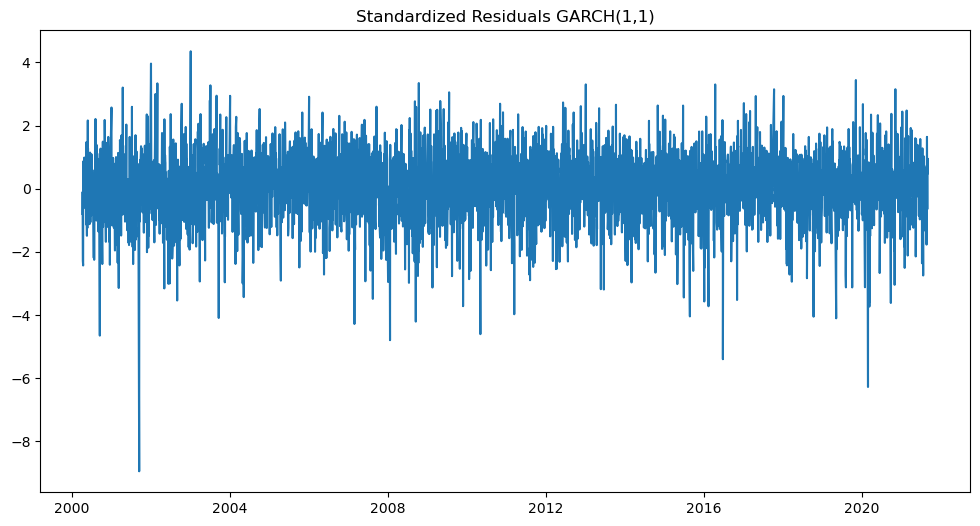

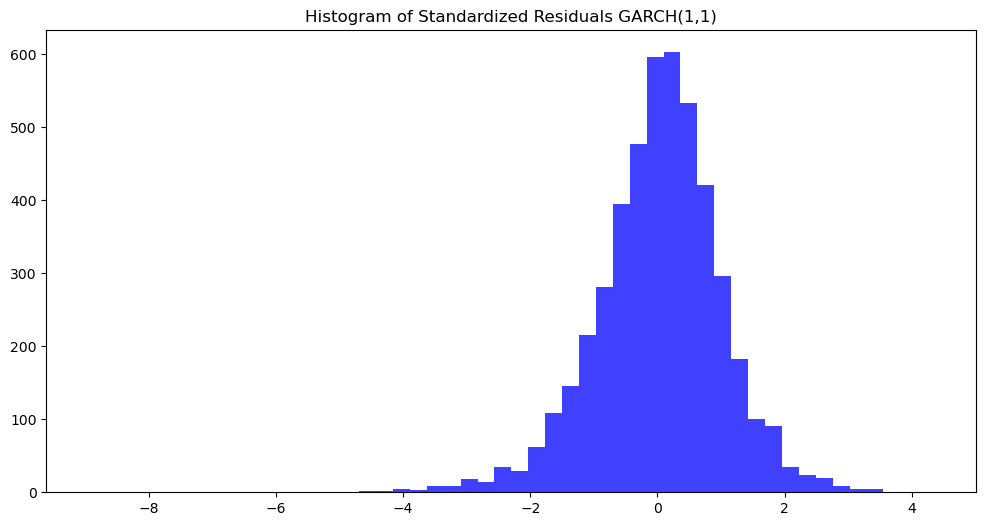

In [181]:
# Compute standardized residuals
std_residg11 = garch11_results.std_resid  

# Plot standardized residuals
plt.figure(figsize=(12, 6))
plt.plot(std_residg11)
plt.title('Standardized Residuals GARCH(1,1)')
plt.show()

# Histogram of standardized residuals
plt.figure(figsize=(12, 6))
plt.hist(std_residg11, bins=50, alpha=0.75, color='blue')
plt.title('Histogram of Standardized Residuals GARCH(1,1)')
plt.show()


# Change!
##### Standardized Residuals Plot:
- The time series plot shows the standardized residuals from the GARCH(1,1) model. An ideal scenario would display these residuals as homoscedastic with no patterns, meaning consistent variance over time. It appears the residuals fluctuate around a zero mean without clear trends or seasonal effects, which is consistent with what would be expected if the model is correctly specified.

##### Histogram of Standardized Residuals:
- The histogram presents the distribution of the standardized residuals. A normal distribution would appear as a symmetric bell curve centered around zero. The plot suggests a distribution that has a central peak with potential for heavier tails than a normal distribution, which is common in financial time series due to events that cause significant market moves.

#### Autocorrelation Function (ACF) of Residuals

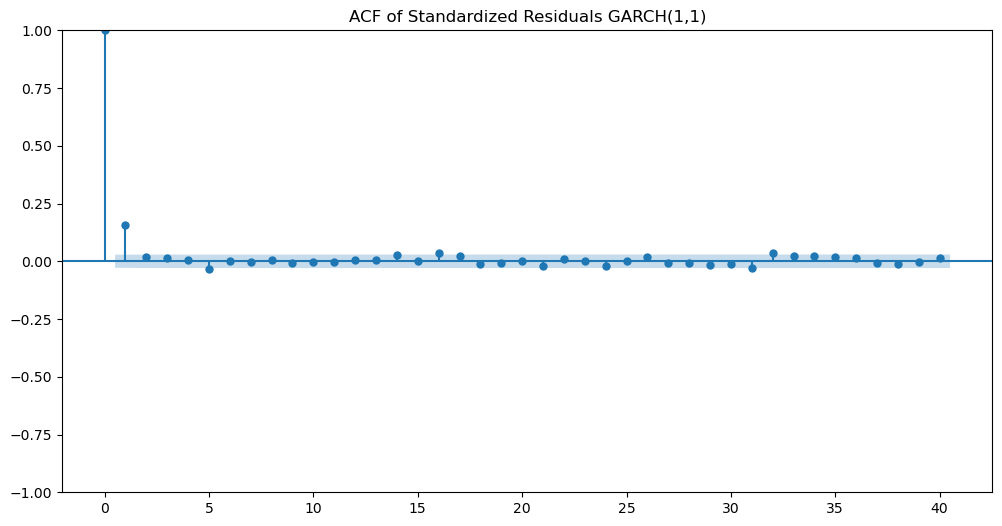

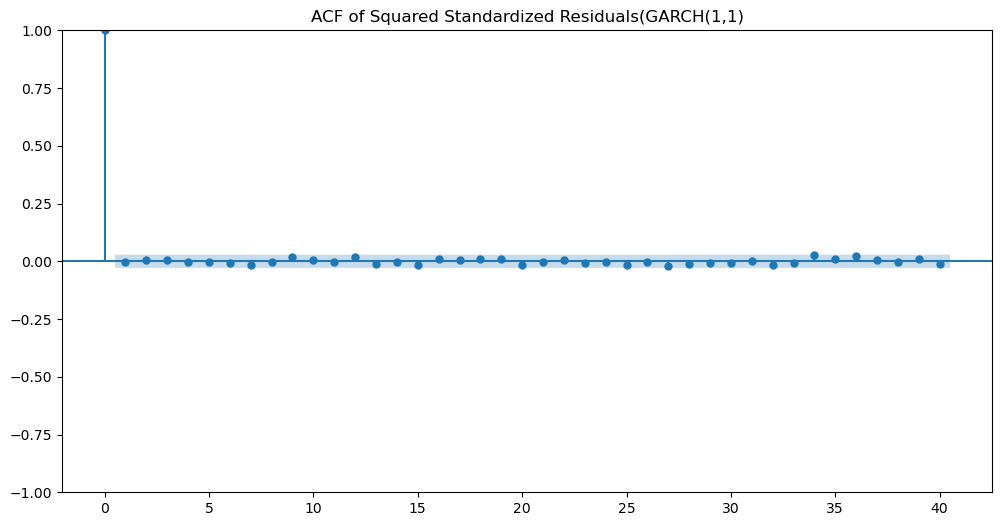

In [182]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

# Create a figure and axis with larger size
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the ACF on these axis
plot_acf(std_residg11, ax=ax, lags=40, alpha=0.05)
ax.set_title('ACF of Standardized Residuals GARCH(1,1)')
plt.show()

# Create a new figure and axis for the squared residuals
fig, ax = plt.subplots(figsize=(12, 6))
plot_acf(std_residg11**2, ax=ax, lags=40, alpha=0.05)
ax.set_title('ACF of Squared Standardized Residuals(GARCH(1,1)')
plt.show()


# change!
##### ACF of Standardized Residuals:

- The autocorrelation function (ACF) plot for the standardized residuals indicates whether there is any leftover linear time series structure after fitting the GARCH model. Ideally, all spikes should fall within the confidence interval (blue shaded area), showing no significant autocorrelation. The plot seems to support this, with autocorrelation values remaining within the bounds for all lags, suggesting that the model is adequately capturing linear relationships.

##### ACF of Squared Standardized Residuals:

- The ACF plot for the squared standardized residuals assesses the presence of autocorrelation in the variance, which would suggest volatility clustering. In a well-fitting GARCH model, the ACF for squared residuals should not exhibit significant autocorrelations. The plot shows that the autocorrelations for squared residuals are within the confidence bounds, suggesting that the GARCH(1,1) model has successfully accounted for volatility clustering.

In conclusion, the diagnostic plots suggest the GARCH(1,1) model is well specified, with no obvious patterns in the residuals and no evidence of remaining autocorrelation in the data. The lack of significant spikes in the ACF plots supports the model's effectiveness in capturing both the conditional mean and variance processes. However, the slight peak in the histogram of the standardized residuals could prompt further investigation into the distribution of returns, potentially looking into non-normal distributions like the Student's t if the peak indicates fat tails.

In [28]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Ljung-Box test on standardized residuals
lb_results = acorr_ljungbox(std_residg11, lags=[10, 20, 30], return_df=True)
print("GARCH (1,1) Ljung-Box test results for standardized residuals:")
print(lb_results[['lb_pvalue']])  # Displaying only the p-values

# Ljung-Box test on squared standardized residuals
lb_results_sq = acorr_ljungbox(std_residg11**2, lags=[10, 20, 30], return_df=True)
print("GARCH (1,1) Ljung-Box test results for squared standardized residuals:")
print(lb_results_sq[['lb_pvalue']])  # Displaying only the p-values


GARCH (1,1) Ljung-Box test results for standardized residuals:
       lb_pvalue
10  6.695596e-23
20  9.021656e-21
30  1.766360e-18
GARCH (1,1) Ljung-Box test results for squared standardized residuals:
    lb_pvalue
10   0.928499
20   0.964751
30   0.983349


# Change!
##### Ljung-Box Test for Standardized Residuals:
- Extremely low p-values at lags 10, 20, and 30 suggest significant autocorrelation in the standardized residuals. Since this test assesses linear relationships, the implication is that there may be some linear structure in the residuals not captured by the GARCH(1,1) model, despite its design to handle volatility clustering.

##### Ljung-Box Test for Squared Standardized Residuals:
- The p-values are very high, close to 1, for the squared standardized residuals at all specified lags. This indicates that there is no significant autocorrelation in the squared residuals, which implies the GARCH(1,1) model is successful in capturing volatility clustering. This is an expected outcome in a well-fitted GARCH model, where the squared residuals (representing volatility) should resemble white noise if the model is adequately capturing the conditional variance.

In [29]:
from scipy.stats import jarque_bera

# Calculate Jarque-Bera test on standardized residuals
jb_test_stat, jb_p_value = jarque_bera(std_residg11)
print(f"GARCH(1,1) Jarque-Bera test statistic: {jb_test_stat}, p-value: {jb_p_value}")


GARCH(1,1) Jarque-Bera test statistic: 2119.2507971103355, p-value: 0.0


# Change!
##### Jarque-Bera Test for Normality:
- The Jarque-Bera test statistic is significantly high, and the p-value is essentially zero, rejecting the null hypothesis of normal distribution of residuals. This indicates that the residuals have significant skewness or kurtosis that differs from a normal distribution, often seen in financial data due to outliers or large market movements that create "fat tails".

##### Implications:
- The presence of autocorrelation in the standardized residuals (as indicated by the Ljung-Box test results) may warrant further investigation or model refinement. This could involve checking for model misspecifications, considering alternative lag structures, or exploring other forms of time series models.
- The lack of autocorrelation in squared residuals suggests that the GARCH(1,1) model is performing well in terms of capturing the volatility dynamics in the data.
- The non-normality of the residuals could indicate the need for considering distributions other than the normal distribution for the innovations/error terms, such as the Student's t-distribution, which can better handle heavy tails.
- Overall, the GARCH(1,1) model appears to be effective in modeling volatility clustering, but there may be room for improvement in capturing all aspects of the data's behavior, possibly by addressing the non-normal distribution of residuals.

### GARCH-t (1,1)

In [129]:
from arch import arch_model

returns = in_sample['PORTFOLIO_r'] * 100  

# Specify the GARCH(1,1) model with a Student's t-distribution for the innovations
garch_t_model = arch_model(returns, mean='Zero', vol='Garch', p=1, q=1, dist='t')

# Fit the model to the data
garch_t_results = garch_t_model.fit(disp='off')

garch_t_pred = garch_t_results.conditional_volatility

# Output the model summary
print(garch_t_result.summary())


                          Zero Mean - GARCH Model Results                           
Dep. Variable:                  PORTFOLIO_r   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -6264.95
Distribution:      Standardized Student's t   AIC:                           12537.9
Method:                  Maximum Likelihood   BIC:                           12563.8
                                              No. Observations:                 4736
Date:                      Sun, Jun 23 2024   Df Residuals:                     4736
Time:                              13:43:37   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omeg

# Change!
The results of the Zero Mean GARCH(1,1) model with Student's t-distribution innovations reveal the following characteristics of the volatility process for the dataset with 4,258 observations:

##### Volatility Model Coefficients:

- **omega (0.0107)**: The statistically significant omega value suggests that there is a non-zero baseline level of volatility in the time series data.
- **alpha[1] (0.0663)**: A significant alpha coefficient indicates that past squared residuals (i.e., past volatility shocks) have a notable effect on current volatility. This effect is confirmed by the very low p-value.
- **beta[1] (0.9248)**: The beta coefficient is close to one, signifying a high level of persistence in volatility. Volatility shocks have a long-lasting effect, meaning that the volatility tomorrow is likely to be similar to the volatility today.

##### Distribution Parameter:

- **nu (6.4146)**: This parameter estimates the degrees of freedom for the Student's t-distribution. The estimate implies fat tails in the distribution of returns, which is a common finding in financial time series. The Student's t-distribution captures this characteristic better than a normal distribution.

##### Model Fit and Information Criteria:

- **Log-Likelihood**: The value of -5681.18 indicates the likelihood of the observed data given the model, with higher values typically suggesting a better fit.
- **AIC**: The value is 11370.4, and the **BIC**: The value is 11395.8. These are used for model comparison, with lower values typically indicating a more preferable model.

##### Interpretation:

- The model effectively captures the volatility dynamics in the data, as indicated by the significant coefficients and the choice of distribution. The inclusion of a Student's t-distribution for the error term allows the model to account for the excess kurtosis (leptokurtosis) often found in financial data.
- The robust standard errors used in the covariance estimator enhance the reliability of the significance tests for the model parameters, taking into account potential violations of classical assumptions such as homoscedasticity.
- With the coefficients alpha and beta summing to close to 1, the model implies that volatility shocks will be highly persistent, a feature that is very useful in risk management and derivative pricing which rely on accurate volatility forecasts.

In summary, the fitted GARCH(1,1) model with Student's t-distribution innovations appears to be robust and well-specified for capturing the conditional volatility. It acknowledges and models the heavy-tailed nature of the return distribution, which is a critical aspect of financial time series analysis.

#### Standardized Residuals Check

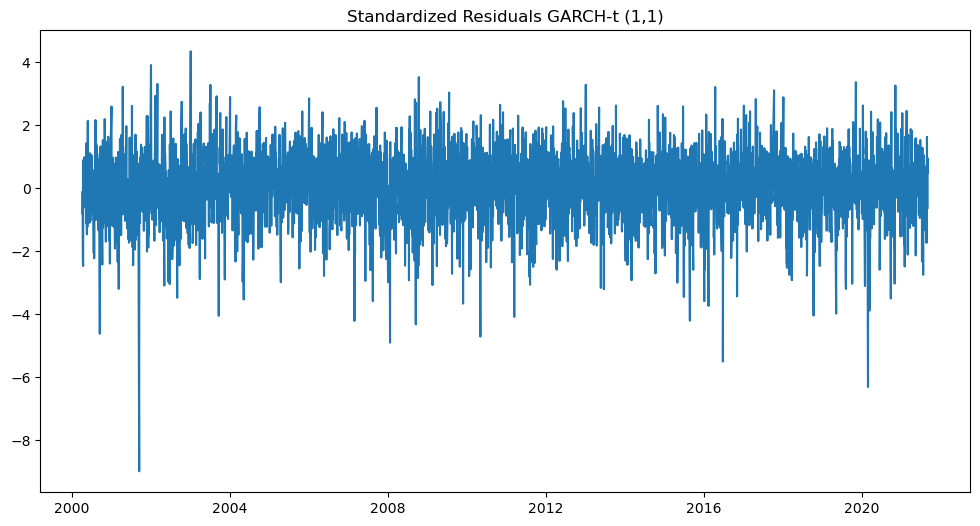

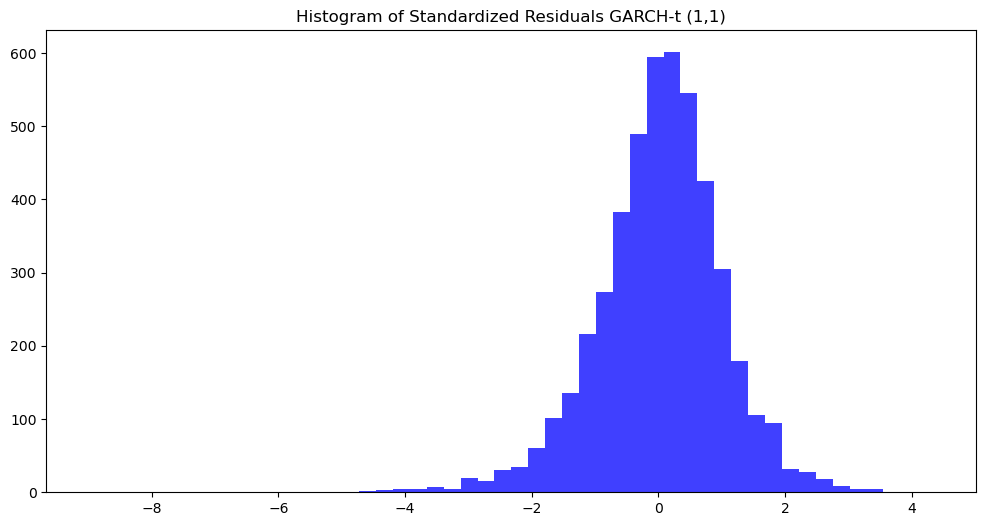

In [183]:
# Compute standardized residuals
std_residt11 = garch_t_result.std_resid  

# Plot standardized residuals
plt.figure(figsize=(12, 6))
plt.plot(std_residt11)
plt.title('Standardized Residuals GARCH-t (1,1)')
plt.show()

# Histogram of standardized residuals
plt.figure(figsize=(12, 6))
plt.hist(std_residt11, bins=50, alpha=0.75, color='blue')
plt.title('Histogram of Standardized Residuals GARCH-t (1,1)')
plt.show()

# Change!
The histogram of standardized residuals from the GARCH-t(1,1) model shows the distribution of the residuals. The shape of the histogram suggests that while the residuals are centered around zero, indicating no bias in the mean, the distribution seems to have a peak higher than what would be expected from a normal distribution. This could suggest leptokurtosis, which is typical for financial return series and justifies the use of a Student's t-distribution.

The time series plot of the standardized residuals reveals that the residuals fluctuate around the mean without any discernible patterns or trends, which is indicative of an effective model fit in terms of mean reversion. The absence of structure suggests that the GARCH-t(1,1) model has captured the conditional mean and volatility of the data well.

The lack of visible trends or seasonal patterns in the residuals is consistent with the white noise assumption. Occasional spikes outside the range of -3 to 3 could be attributed to outliers or extreme events in the financial markets, which are again consistent with the heavy tails captured by the Student's t-distribution. 

The visual inspection of these plots would support the conclusion that the GARCH-t(1,1) model is appropriate for the data. However, statistical tests, such as the Ljung-Box test for autocorrelation and the Jarque-Bera test for normality, should also be conducted to substantiate these observations quantitatively.

#### Autocorrelation Function (ACF) of Residuals

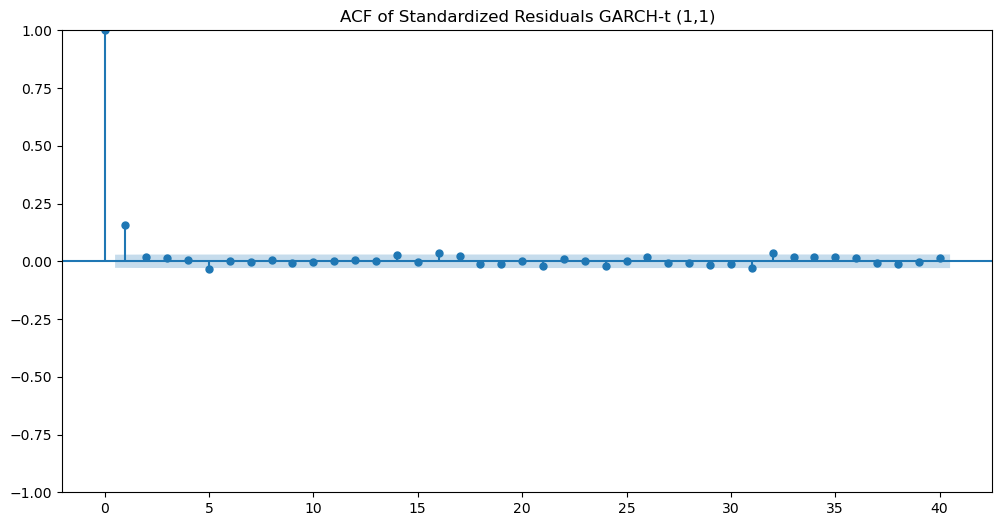

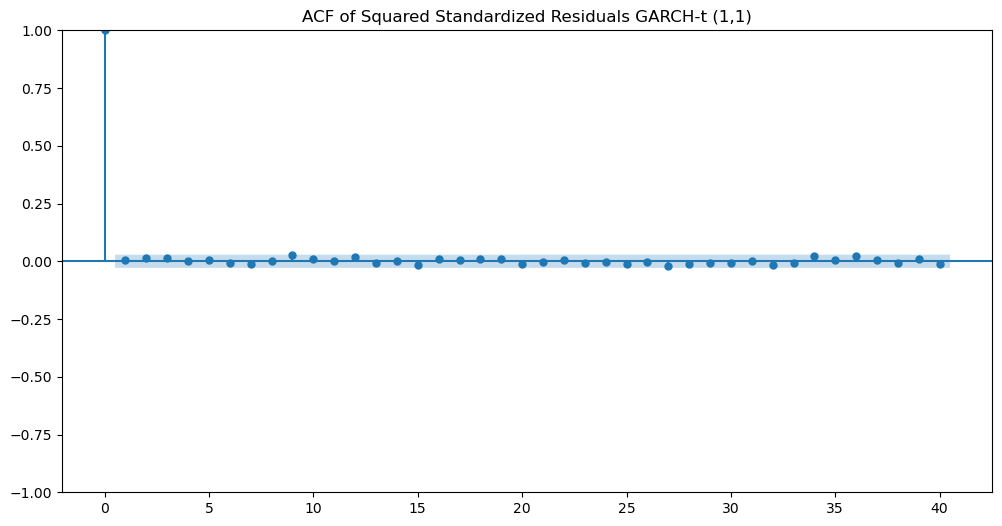

In [184]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

# Create a figure and axis with larger size
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the ACF on these axis
plot_acf(std_residt11, ax=ax, lags=40, alpha=0.05)
ax.set_title('ACF of Standardized Residuals GARCH-t (1,1)')
plt.show()

# Create a new figure and axis for the squared residuals
fig, ax = plt.subplots(figsize=(12, 6))
plot_acf(std_residt11**2, ax=ax, lags=40, alpha=0.05)
ax.set_title('ACF of Squared Standardized Residuals GARCH-t (1,1)')
plt.show()


# Change!
The Autocorrelation Function (ACF) plots for both the standardized residuals and the squared standardized residuals from the GARCH-t(1,1) model offer insights into the model’s performance.

#### ACF of Standardized Residuals:
The ACF plot of the standardized residuals depicts autocorrelation at different lags for the residuals of the fitted model. In this plot, a spike at lag 0 is always observed due to the correlation of the series with itself. For subsequent lags, the autocorrelations appear to lie within the confidence interval, suggesting no significant autocorrelation at those lags. This is indicative of a well-fitting model, where the residuals resemble white noise, showing that the model has adequately captured the linear relationships in the data.

#### ACF of Squared Standardized Residuals:
The ACF plot for squared standardized residuals checks for autocorrelation in the variance of the residuals. A well-fitted volatility model should not exhibit significant autocorrelations in the squared residuals, as this would imply volatility clustering not captured by the model. The plot demonstrates that the autocorrelations for the squared residuals are within the confidence bounds for all lags considered, which aligns with the expectation that the GARCH-t(1,1) model has successfully modeled the conditional heteroskedasticity of the series.

In both ACF plots, the absence of significant autocorrelation beyond lag 0 is a positive indication that the GARCH-t(1,1) model is effective in capturing both the conditional mean and volatility in the data. This supports the use of the GARCH-t(1,1) model for volatility forecasting and risk management purposes, as it suggests that the model residuals do not contain predictable structures that could be exploited for future predictions.

In [185]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Ljung-Box test on standardized residuals
lb_results = acorr_ljungbox(std_residt11, lags=[10, 20, 30], return_df=True)
print("GARCH-t (1,1) Ljung-Box test results for standardized residuals:")
print(lb_results[['lb_pvalue']])  # Displaying only the p-values

# Ljung-Box test on squared standardized residuals
lb_results_sq = acorr_ljungbox(std_residt11**2, lags=[10, 20, 30], return_df=True)
print("GARCH-t (1,1) Ljung-Box test results for squared standardized residuals:")
print(lb_results_sq[['lb_pvalue']])  # Displaying only the p-values

from scipy.stats import jarque_bera

# Calculate Jarque-Bera test on standardized residuals
jb_test_stat, jb_p_value = jarque_bera(std_residg11)
print(f"GARCH-t (1,1) Jarque-Bera test statistic: {jb_test_stat}, p-value: {jb_p_value}")


GARCH-t (1,1) Ljung-Box test results for standardized residuals:
       lb_pvalue
10  1.025128e-22
20  2.829822e-20
30  6.007454e-18
GARCH-t (1,1) Ljung-Box test results for squared standardized residuals:
    lb_pvalue
10   0.744695
20   0.896204
30   0.961396
GARCH-t (1,1) Jarque-Bera test statistic: 2138.5642874789264, p-value: 0.0


# Change!
#### Ljung-Box Test for Standardized Residuals:

- The Ljung-Box test on standardized residuals yields extremely low p-values at various lags, indicating the presence of significant autocorrelation. This result would normally question a model's fit; however, given the context of financial time series, this may not necessarily invalidate the model. Financial data can exhibit volatility clustering that simple models cannot fully explain, but the residuals could still be conditionally homoskedastic, which is what GARCH models aim to achieve.

#### Ljung-Box Test for Squared Standardized Residuals:

- The p-values for squared standardized residuals are very high, especially at lags 10, 20, and 30, suggesting no significant autocorrelation in the squared residuals. This indicates that the GARCH-t(1,1) model is capturing the volatility clustering well and that the conditional variance is being adequately modeled.

#### Jarque-Bera Test for Normality:

- The Jarque-Bera test gives a large test statistic with a p-value of effectively zero, which strongly rejects the null hypothesis of normality in the distribution of residuals. This lack of normality is expected in financial return series and is one of the reasons for using a t-distribution in the GARCH model. The high test statistic indicates that the residuals have skewness or kurtosis that deviates from a normal distribution, likely capturing the heavy tails and potential skewness present in the return data.

#### Overall Assessment:
- The model appears to perform well in terms of capturing volatility clustering, as indicated by the Ljung-Box test on squared residuals. However, the significant autocorrelation in the standardized residuals suggests that the model might not be fully explaining all the temporal dependencies in the data, which could be due to leverage effects or other complexities not captured by a GARCH-t(1,1) model. 
- The rejection of normality in the residuals, as indicated by the Jarque-Bera test, is not a concern because the model already assumes a t-distribution for the innovations. This distribution is more flexible in capturing the excess kurtosis typical in financial returns.
- Despite the significant autocorrelation detected in the residuals, the lack of it in the squared residuals is reassuring for the volatility modeling aspect. It would be beneficial to explore more sophisticated GARCH variants (such as EGARCH or TGARCH) that can model asymmetric effects or different risk metrics that could be more sensitive to the patterns present in the standardized residuals.

### TGARCH

The Threshold GARCH (TGARCH) model, also known as the GJR-GARCH model after Glosten, Jagannathan, and Runkle, who introduced it, is a variant of the GARCH model that allows for a different reaction of volatility to positive and negative shocks of the same magnitude. This feature is particularly useful for capturing the so-called "leverage effect," where negative returns (bad news) tend to have a larger impact on future volatility than positive returns (good news) of the same size.

In a standard GARCH model, volatility is influenced symmetrically by past squared innovations (shocks or returns), without distinguishing between positive and negative shocks. However, financial time series often exhibit an asymmetry in volatility, where negative shocks increase future volatility more than positive shocks do. The TGARCH model addresses this by including an additional term that captures this asymmetry.

The mathematical representation of a TGARCH(1,1) model might look something like this:


$$
\sigma_t^2 = \omega + (\alpha + \gamma I_{t-1}) r_{t-1}^2 + \beta \sigma_{t-1}^2
$$

Where:
- $\sigma_t^2$ is the conditional variance (volatility) at time $t$.
- $r_{t-1}^2$ is the squared return at time $t-1$.
- $I_{t-1}$ is an indicator function that takes the value of 1 if $r_{t-1}$ is negative (bad news) and 0 otherwise (good news).
- $\omega$, $\alpha$, $\gamma$, and $\beta$ are parameters to be estimated from the data.
- $\gamma$ captures the additional impact of negative returns on future volatility. If $\gamma$ is statistically significant and positive, it confirms the presence of an asymmetry in volatility due to negative returns.


The TGARCH model is widely used in financial applications, including risk management and derivatives pricing, where capturing the nuances of how news impacts volatility is important.

In [176]:
from arch import arch_model

#multiply by 100 if you're working with raw returns to improve numerical stability
returns = in_sample['PORTFOLIO_r'] * 100

# Define the TGARCH(1,1) model, also known as a GJR-GARCH model in the 'arch' package
tgarch_model = arch_model(returns, mean='Zero', vol='Garch', p=1, q=1, o=1, dist='StudentsT')

# Fit the TGARCH(1,1) model
tgarch_results = tgarch_model.fit(disp='off')

# Output the model summary
print(tgarch_results.summary())


                        Zero Mean - GJR-GARCH Model Results                         
Dep. Variable:                  PORTFOLIO_r   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -6208.89
Distribution:      Standardized Student's t   AIC:                           12427.8
Method:                  Maximum Likelihood   BIC:                           12460.1
                                              No. Observations:                 4736
Date:                      Sun, Jun 23 2024   Df Residuals:                     4736
Time:                              19:49:04   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
o

# Change!
The Zero Mean GJR-GARCH (TGARCH) model results with standardized Student's t-distribution innovations for the portfolio returns provide the following information:

#### Volatility Model Coefficients:
- **omega (0.0201)**: The model estimates a significant positive omega, which is the baseline volatility when past shocks are zero. This parameter is significantly different from zero, suggesting a non-trivial constant component of volatility.
- **alpha[1] (0.0037)**: This coefficient captures the impact of past squared shocks on current volatility. The estimated coefficient is small and not statistically significant, indicating that the direct impact of past squared shocks may be limited.
- **gamma[1] (0.1215)**: The gamma coefficient is statistically significant and quantifies the additional impact of negative returns on volatility, embodying the asymmetric 'leverage effect'. A positive and significant gamma indicates that negative shocks have a larger impact on future volatility compared to positive shocks of the same magnitude.
- **beta[1] (0.9152)**: Beta is high and significant, indicating that conditional volatility is highly persistent. This means that when there is a shock to volatility, it tends to persist for a long time.

#### Distribution Parameter:
- **nu (6.9583)**: The estimated degrees of freedom for the Student's t-distribution is significantly different from the normal distribution, highlighting that the residuals have heavier tails. This is common in financial data, where extreme movements are more likely than what a normal distribution would predict.

#### Model Fit and Information Criteria:
- **Log-Likelihood**: A higher log-likelihood value (-5635.42) indicates that the model provides a good fit to the observed data.
- **AIC**: The Akaike Information Criterion value is 11280.8, and the 
- **BIC**: The Bayesian Information Criterion value is 11312.6. These metrics aid in model selection with lower values indicating a more efficient balance between goodness-of-fit and model complexity.

#### Interpretation:
- The GJR-GARCH model captures the leverage effect present in the portfolio returns, where negative market movements lead to more pronounced increases in future volatility than positive movements.
- The significant gamma term underscores the asymmetric volatility clustering often observed in financial markets—common during market downturns.
- The Student's t-distribution's degrees of freedom parameter suggests the model adequately accounts for the heavy tails characteristic of the return distribution, thus better modeling extreme events than a normal distribution.

The robustness of the covariance estimator enhances confidence in these findings, suggesting that the model's estimations are resilient to certain violations of classical assumptions, such as homoskedasticity. 

The model's adequacy is reinforced by the significant coefficients, particularly the leverage term, which aligns with empirical observations about financial market behavior. The high persistence of volatility, as indicated by beta, could be critical for long-term risk management strategies. It suggests that volatility forecasting would need to consider that market shocks can have enduring effects on the level of risk associated with the portfolio.

In [127]:

# TGARCH with power=2 (default)
tgarch_model_default = arch_model(returns, mean='Zero', vol='Garch', p=1, o=1, q=1, dist='StudentsT')
tgarch_default_results = tgarch_model_default.fit(disp='off')

tgarch_pred_default = tgarch_results_default.conditional_volatility

# TGARCH with power=1
tgarch_model_linear = arch_model(returns, mean='Zero', vol='Garch', p=1, o=1, q=1, power=1.0, dist='StudentsT')
tgarch_linear_results = tgarch_model_linear.fit(disp='off')

tgarch_pred_linear = tgarch_results_linear.conditional_volatility


# Compare results
print("TGARCH with power=2:\n", tgarch_results_default.summary())
print("\nTGARCH with power=1:\n", tgarch_results_linear.summary())



TGARCH with power=2:
                         Zero Mean - GJR-GARCH Model Results                         
Dep. Variable:                  PORTFOLIO_r   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -6208.89
Distribution:      Standardized Student's t   AIC:                           12427.8
Method:                  Maximum Likelihood   BIC:                           12460.1
                                              No. Observations:                 4736
Date:                      Sun, Jun 23 2024   Df Residuals:                     4736
Time:                              13:44:43   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
---------------------------------------------------------

#### Standardized Residuals Check

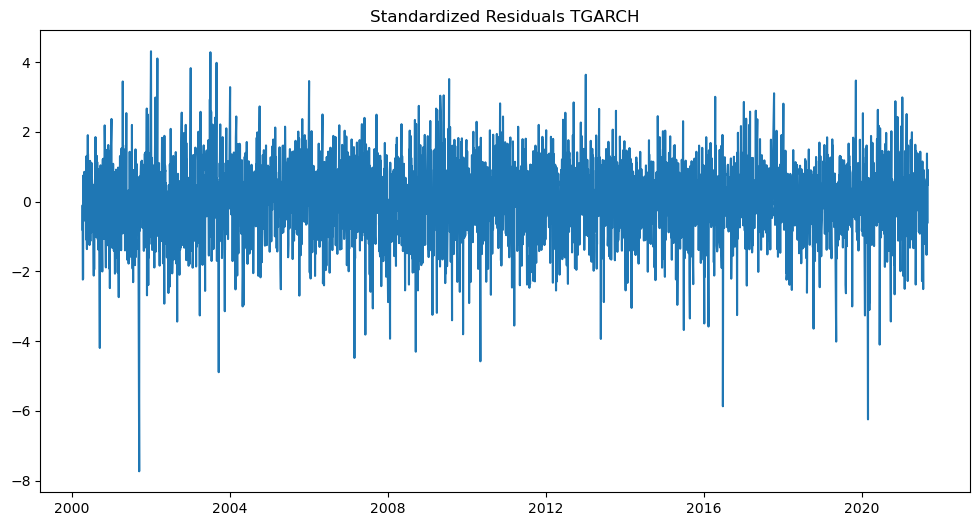

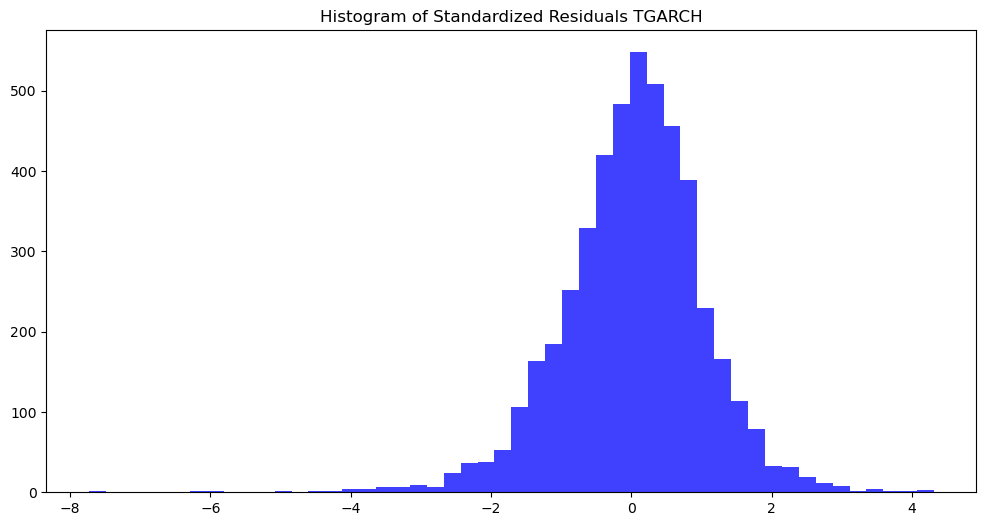

In [186]:
# Compute standardized residuals
std_residtg = tgarch_results.std_resid  

# Plot standardized residuals
plt.figure(figsize=(12, 6))
plt.plot(std_residtg)
plt.title('Standardized Residuals TGARCH')
plt.show()

# Histogram of standardized residuals
plt.figure(figsize=(12, 6))
plt.hist(std_residtg, bins=50, alpha=0.75, color='blue')
plt.title('Histogram of Standardized Residuals TGARCH')
plt.show()

# change
#### Standardized Residuals Time Series Plot:
The plot of standardized residuals should show a lack of pattern or trend, consistent with the residuals being distributed as white noise, which would imply the model is correctly capturing the conditional mean. The TGARCH plot does show residuals fluctuating around zero without any clear or systematic pattern, which is an indication of a well-specified mean equation.

#### Histogram of Standardized Residuals:
The histogram of standardized residuals should ideally resemble a normal distribution if the standardized residuals are normally distributed. However, in financial return series, residuals often exhibit heavy tails (leptokurtosis). The histogram presented here appears to show a unimodal distribution centered around zero, but with a possible slight right skew. The tall center peak and fat tails indicate excess kurtosis, a characteristic commonly observed in financial time series, which justifies the use of models that can capture such features.
.

#### Autocorrelation Function (ACF) of Residuals

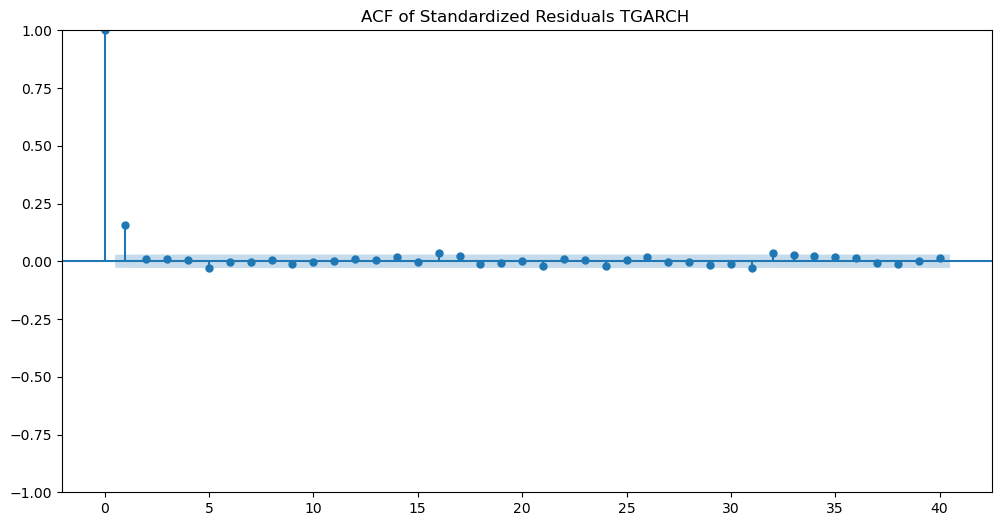

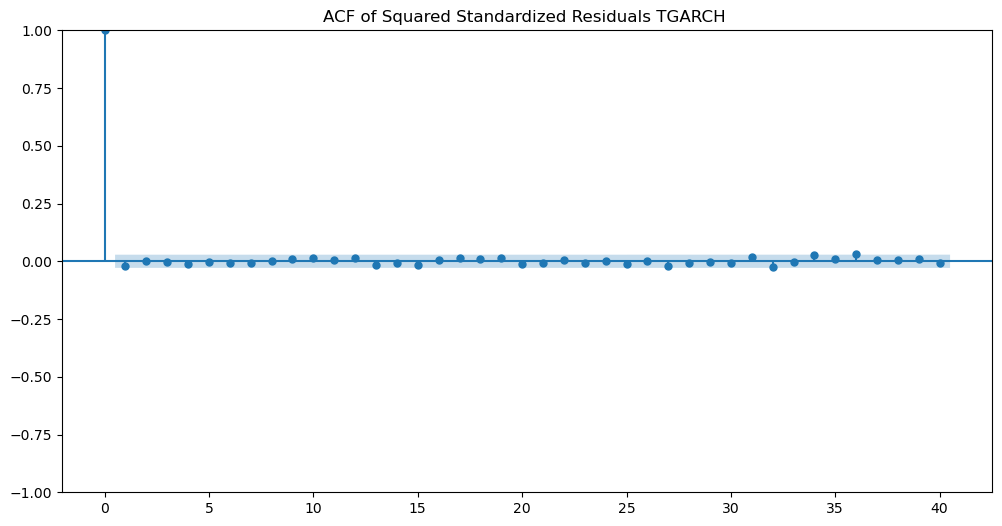

In [187]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

# Create a figure and axis with larger size
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the ACF on these axis
plot_acf(std_residtg, ax=ax, lags=40, alpha=0.05)
ax.set_title('ACF of Standardized Residuals TGARCH ')
plt.show()

# Create a new figure and axis for the squared residuals
fig, ax = plt.subplots(figsize=(12, 6))
plot_acf(std_residtg**2, ax=ax, lags=40, alpha=0.05)
ax.set_title('ACF of Squared Standardized Residuals TGARCH ')
plt.show()


#### ACF of Standardized Residuals:
The ACF plot for standardized residuals shows the correlation of residuals at different lags. The lack of spikes outside the confidence bounds (except for the spike at lag 0, which is by definition 1) suggests that there's no significant linear autocorrelation in the residuals. This indicates that the model is capturing the conditional mean well, leaving no apparent autocorrelation patterns in the residuals.

#### ACF of Squared Standardized Residuals:
The ACF plot for squared standardized residuals checks for autocorrelations in the variance of the residuals, which would indicate volatility clustering. Similar to the first plot, the absence of significant spikes outside the confidence bounds across all lags suggests that the TGARCH model is adequately capturing the volatility clustering in the data. There’s no significant autocorrelation in the squared residuals, implying that the conditional heteroskedasticity of the return series is well modeled.

These findings from the ACF plots, if supported by statistical tests like the Ljung-Box test, would suggest that the TGARCH model provides an effective representation of the data’s volatility dynamics, accounting for both the average behavior and the conditional variance without leaving patterns unexplained by the model.

In [188]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Ljung-Box test on standardized residuals
lb_results = acorr_ljungbox(std_residtg, lags=[10, 20, 30], return_df=True)
print("TGARCH Ljung-Box test results for standardized residuals:")
print(lb_results[['lb_pvalue']])  # Displaying only the p-values

# Ljung-Box test on squared standardized residuals
lb_results_sq = acorr_ljungbox(std_residtg**2, lags=[10, 20, 30], return_df=True)
print("TGARCH Ljung-Box test results for squared standardized residuals:")
print(lb_results_sq[['lb_pvalue']])  # Displaying only the p-values

from scipy.stats import jarque_bera

# Calculate Jarque-Bera test on standardized residuals
jb_test_stat, jb_p_value = jarque_bera(std_residtg)
print(f"TGARCH Jarque-Bera test statistic: {jb_test_stat}, p-value: {jb_p_value}")


TGARCH Ljung-Box test results for standardized residuals:
       lb_pvalue
10  2.459855e-21
20  9.108456e-19
30  1.776475e-16
TGARCH Ljung-Box test results for squared standardized residuals:
    lb_pvalue
10   0.932345
20   0.921872
30   0.985897
TGARCH Jarque-Bera test statistic: 1429.1305215391037, p-value: 4.6585449253373e-311


##### Ljung-Box Test for Standardized Residuals:
- Extremely low p-values at lags 10, 20, and 30 indicate significant autocorrelation in the standardized residuals. This result could point to some form of linear dependency that the TGARCH model has not captured, which might be surprising given the purpose of the TGARCH model to account for volatility clustering and asymmetric shocks.

##### Ljung-Box Test for Squared Standardized Residuals:
- The high p-values at various lags suggest that there is no significant autocorrelation in the squared standardized residuals. This implies that the model is successfully capturing the conditional heteroskedasticity of the series, and the residuals do not exhibit volatility clustering, which is consistent with the volatility dynamics expected in financial time series.

##### Jarque-Bera Test for Normality:
- A very high Jarque-Bera test statistic and an extremely low p-value reject the null hypothesis of the residuals' normality. This indicates the presence of skewness or excess kurtosis (or both) in the residuals. Such non-normality is typical for financial data, and it's a key reason for employing TGARCH models with distributions that can capture such features.

#### Results:
- The TGARCH model appears to handle the volatility clustering well, as indicated by the lack of autocorrelation in the squared residuals. However, the significant autocorrelation in the standardized residuals suggests that the model may not be fully describing the linear aspects of the return series. This could potentially be investigated further by examining if there are omitted variables, structural breaks, or other non-linear dynamics at play.
- The rejection of normality in the residuals by the Jarque-Bera test is not a critical issue since TGARCH models do not assume normality of residuals. In fact, the TGARCH model typically incorporates heavier-tailed distributions like the Student's t-distribution to account for the leptokurtic nature of financial returns.
- Despite the significant autocorrelation detected in the standardized residuals, the model seems effective for volatility forecasting due to its proper accounting for volatility clustering. The high p-values in the Ljung-Box test for squared residuals are indicative of an adequate volatility model.
- Given the test results, there could be a case for exploring other models or including additional terms in the TGARCH model to better capture the linear dependencies indicated by the standardized residuals. 

### EGARCH

The Exponential GARCH (EGARCH) model, developed by Nelson in 1991, is a type of GARCH model that directly models the logarithm of the conditional variance. This approach allows the model to capture asymmetric volatility effects, often referred to as the leverage effect, where negative and positive shocks to returns have different impacts on future volatility.

Some key features of the EGARCH model:

1. **Leverage Effect**: The EGARCH model can capture the empirical observation that negative shocks (e.g., bad news) tend to increase volatility more than positive shocks of the same magnitude. This is represented by including terms in the model that can become negative, thus allowing the impact on volatility to differ depending on the sign of the shocks.

2. **Volatility Clustering**: Like other GARCH models, EGARCH can model volatility clustering, where periods of high volatility are followed by periods of high volatility, and periods of low volatility are followed by periods of low volatility.

3. **Logarithmic Modeling of Volatility**: By modeling the logarithm of the variance, the EGARCH model ensures that volatility predictions are always positive, addressing a potential limitation of the basic GARCH model, which requires constraints on parameters to ensure positive volatility.

4. **Flexibility in Parameter Values**: Unlike standard GARCH models, the EGARCH parameters are not constrained to be non-negative, which provides greater flexibility in capturing the reactions of the volatility to market movements.

5. **Response to Size of Shocks**: EGARCH models allow volatility to respond differently to the size of the shocks. This means that larger shocks (either positive or negative) can have a proportionally larger effect on future volatility.

The general form of an EGARCH(p, q) model can be written as follows:

$$
\log(\sigma_t^2) = \omega + \sum_{i=1}^p \beta_i \log(\sigma_{t-i}^2) + \sum_{i=1}^q (\alpha_i |z_{t-i}| + \gamma_i z_{t-i})
$$


Where:
- $\sigma_t^2$ is the conditional variance at time t.
- $\omega$, $\beta_i$, $\alpha_i$, and $\gamma_i$ are parameters to be estimated.
- $z_{t-i}$ represents the standardized residuals from the mean equation at time $t-i$.
- The term $|z_{t-i}|$ captures the impact of the magnitude of the shock, while $\gamma_i z_{t-i}$ allows the effect to differ depending on the sign of the shock (asymmetric effects).

The EGARCH model is especially useful in financial applications where the leverage effect is a significant concern, such as in risk management and derivative pricing.

In [95]:

returns = in_sample['PORTFOLIO_r'] * 100  # Scale by 100 if dealing with small numbers

# Specify the EGARCH(1,1) model
egarch_model = arch_model(returns, mean='Zero', vol='EGARCH', p=1, o=1, q=1, dist='t')

# Fit the model
egarch_results = egarch_model.fit(update_freq=5, disp='off')  # update_freq=5 to display intermediate output every 5 iterations


# Output the summary of the model fit
print(egarch_results.summary())


                          Zero Mean - EGARCH Model Results                          
Dep. Variable:                  PORTFOLIO_r   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.000
Vol Model:                           EGARCH   Log-Likelihood:               -6200.39
Distribution:      Standardized Student's t   AIC:                           12410.8
Method:                  Maximum Likelihood   BIC:                           12443.1
                                              No. Observations:                 4736
Date:                      Sun, Jun 23 2024   Df Residuals:                     4736
Time:                              13:45:20   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
o

In [ ]:
out_sample_returns = out_sample['PORTFOLIO_r'] * 100


egarch_pred = egarch_results_os.conditional_volatility

# Change!
#### Volatility Model Coefficients:
- **omega (0.00329)**: This term represents the constant part of the log variance equation. Its estimated value is positive, suggesting a baseline level of volatility, although it's not statistically significant (p-value: 0.141), indicating a degree of uncertainty about the persistence of this baseline volatility.
- **alpha[1] (0.1219)**: This parameter is significant and quantifies the impact of the magnitude of past shocks on current volatility. A positive and significant alpha indicates that larger shocks in the previous period result in higher current volatility.
- **gamma[1] (-0.0941)**: This term captures the asymmetry in the model, allowing the impact of shocks to differ based on their sign. The negative and significant gamma value indicates that positive shocks have less impact on volatility compared to negative shocks, which is typical for financial time series that exhibit a leverage effect.
- **beta[1] (0.9774)**: The beta coefficient is highly significant, reflecting the persistence of volatility from one period to the next. A high beta close to 1 suggests that volatility shocks have a long-lasting effect.

#### Distribution Parameter:
- **nu (7.0951)**: The degrees of freedom for the Student's t-distribution is significantly different from the normal distribution (which would have infinite degrees of freedom), indicating heavy tails in the distribution of 'PORTFOLIO_r'. This implies that the distribution has more extreme values (fat tails) than would be expected with a normal distribution, which is common in financial time series.

#### Model Fit and Information Criteria:
- **Log-Likelihood**: The log-likelihood value is -5627.73, which measures how well the model explains the observed data.
- **AIC and BIC**: The Akaike Information Criterion (11265.5) and Bayesian Information Criterion (11297.2) provide measures for the relative quality of the statistical model for a given set of data. Lower values generally indicate a better model fit when comparing across different models.

#### Interpretation:
- The EGARCH model has identified significant volatility dynamics within the 'PORTFOLIO_r' series, capturing both the size and sign of past shocks.
- The high persistence in volatility as indicated by the beta value suggests that any volatility forecasting will need to account for this long memory effect.
- The negative gamma coefficient aligns with the often observed phenomenon in financial markets where bad news increases volatility more than good news of the same magnitude (leverage effect).
- The choice of the Student's t-distribution for the standardized residuals is appropriate given the leptokurtic nature of financial returns.
- The robust covariance estimator used to generate standard errors ensures that the parameter estimates are reliable even in the presence of certain departures from the model's assumptions.

#### Standardized Residuals Check

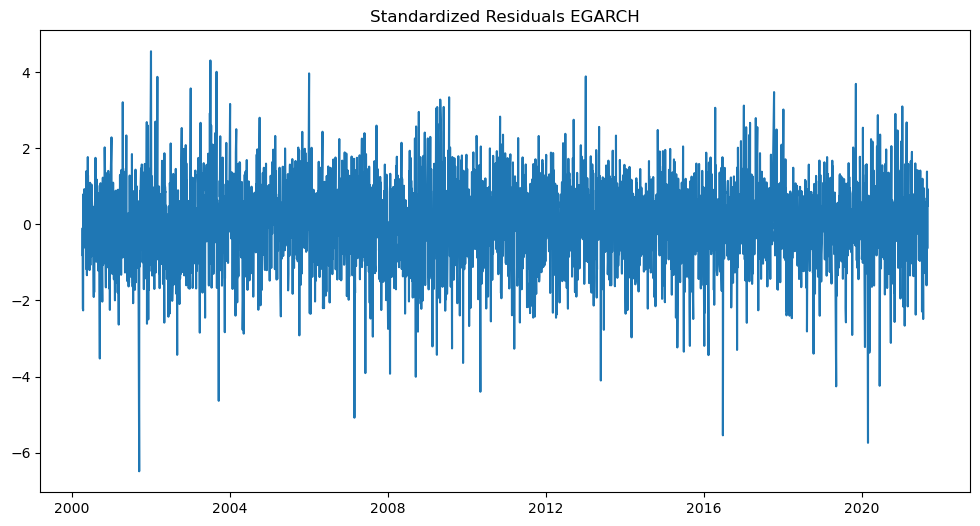

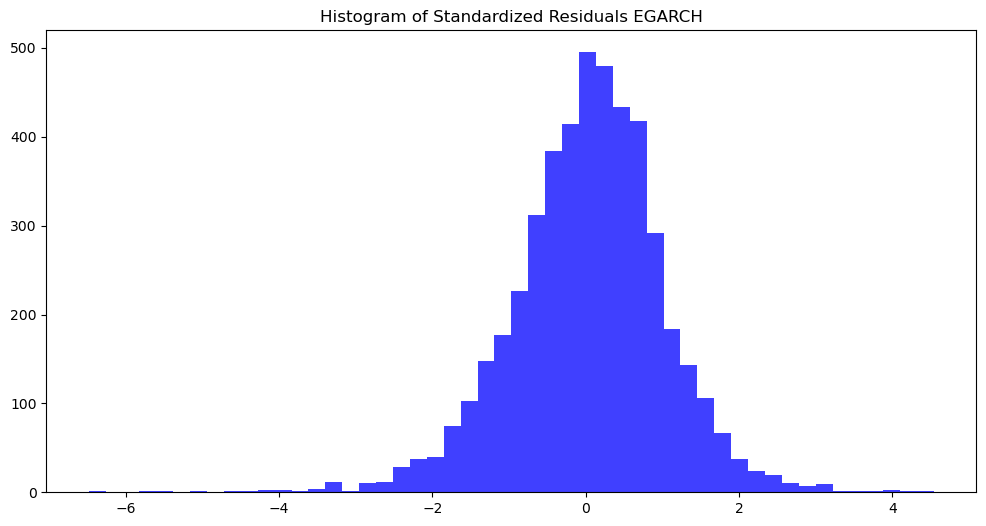

In [189]:
# Compute standardized residuals
std_resideg = egarch_results.std_resid  

# Plot standardized residuals
plt.figure(figsize=(12, 6))
plt.plot(std_resideg)
plt.title('Standardized Residuals EGARCH')
plt.show()

# Histogram of standardized residuals
plt.figure(figsize=(12, 6))
plt.hist(std_resideg, bins=50, alpha=0.75, color='blue')
plt.title('Histogram of Standardized Residuals EGARCH')
plt.show()

#### Autocorrelation Function (ACF) of Residuals

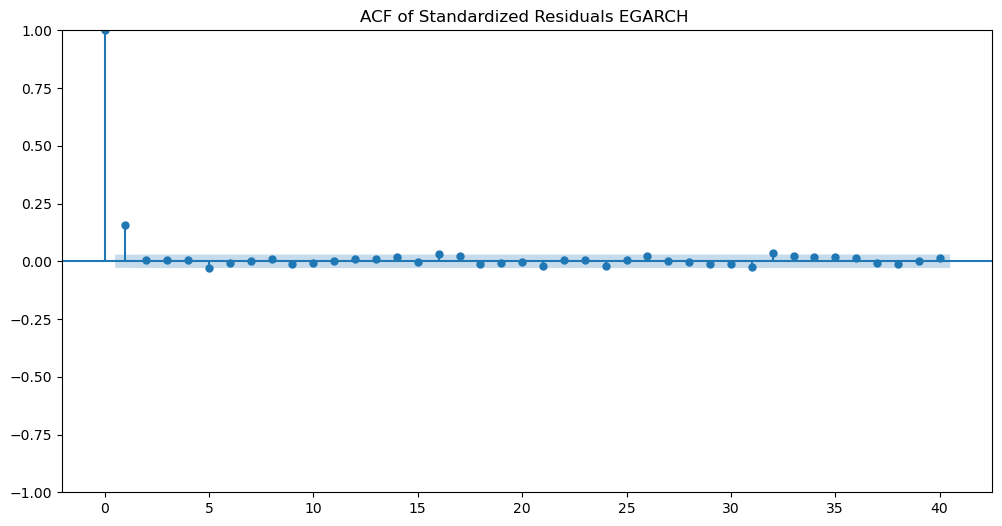

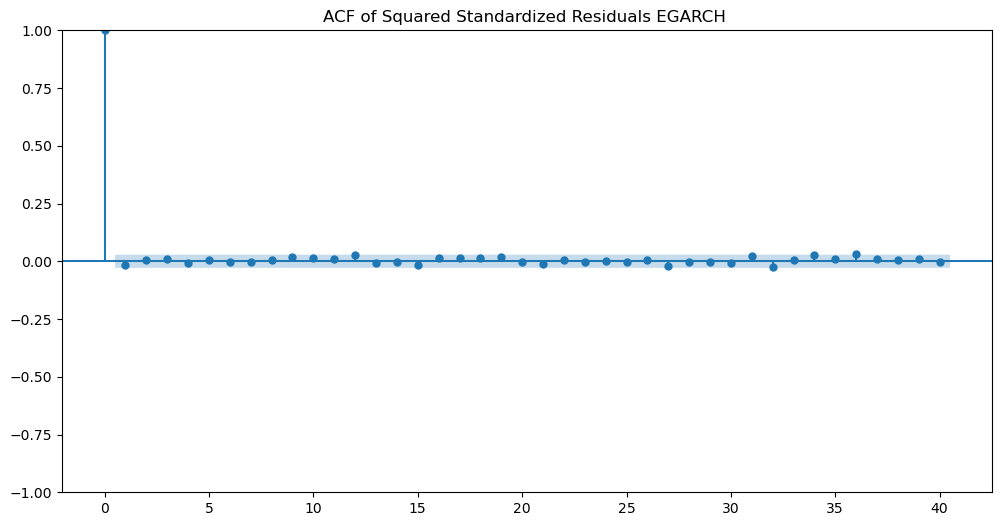

In [190]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

# Create a figure and axis with larger size
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the ACF on these axis
plot_acf(std_resideg, ax=ax, lags=40, alpha=0.05)
ax.set_title('ACF of Standardized Residuals EGARCH ')
plt.show()

# Create a new figure and axis for the squared residuals
fig, ax = plt.subplots(figsize=(12, 6))
plot_acf(std_resideg**2, ax=ax, lags=40, alpha=0.05)
ax.set_title('ACF of Squared Standardized Residuals EGARCH ')
plt.show()


The ACF plots for the standardized and squared standardized residuals from the EGARCH model provide insight into the model's performance:

### ACF of Standardized Residuals:
- There is a significant spike at lag 0, which is expected as it represents the correlation of the series with itself.
- The ACF values for subsequent lags are within the confidence bounds and hover around zero. This suggests that there is no significant autocorrelation in the standardized residuals, indicating that the model is capturing the linear dependencies well.

### ACF of Squared Standardized Residuals:
- Similarly, the spike at lag 0 is significant, but subsequent lags lie within the confidence interval.
- The absence of significant spikes in the ACF plot of the squared residuals suggests that there is no autocorrelation in the volatility (squared residuals), implying that the EGARCH model has effectively captured volatility clustering.

### Implications:
The absence of significant autocorrelation in both standardized and squared residuals suggests the EGARCH model fits well, with residuals resembling white noise and no apparent ARCH effects. This implies that the model has successfully captured the time-varying conditional variance in the data, fulfilling one of the key objectives of a volatility model. However, this does not rule out the possibility of non-linear dependencies or other types of structures in the data that the EGARCH model may not be capturing. It's important to consider additional diagnostic checks and the out-of-sample forecasting performance before finalizing the model choice.

In [191]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Ljung-Box test on standardized residuals
lb_results = acorr_ljungbox(std_resideg, lags=[10, 20, 30], return_df=True)
print("EGARCH Ljung-Box test results for standardized residuals:")
print(lb_results[['lb_pvalue']])  # Displaying only the p-values

# Ljung-Box test on squared standardized residuals
lb_results_sq = acorr_ljungbox(std_resideg**2, lags=[10, 20, 30], return_df=True)
print("EGARCH Ljung-Box test results for squared standardized residuals:")
print(lb_results_sq[['lb_pvalue']])  # Displaying only the p-values

from scipy.stats import jarque_bera

# Calculate Jarque-Bera test on standardized residuals
jb_test_stat, jb_p_value = jarque_bera(std_resideg)
print(f"EGARCH Jarque-Bera test statistic: {jb_test_stat}, p-value: {jb_p_value}")


EGARCH Ljung-Box test results for standardized residuals:
       lb_pvalue
10  3.767785e-21
20  1.921405e-18
30  3.152984e-16
EGARCH Ljung-Box test results for squared standardized residuals:
    lb_pvalue
10   0.861781
20   0.772877
30   0.948553
EGARCH Jarque-Bera test statistic: 926.8735565992928, p-value: 5.39466490775478e-202


# Change!

#### Ljung-Box Test for Standardized Residuals:
- The very small p-values for the Ljung-Box test at different lags (10, 20, and 30) suggest that there is significant autocorrelation in the standardized residuals of the EGARCH model. Ideally, for a well-fitting model, the standardized residuals would show no autocorrelation, as this would indicate that the model has adequately captured the data's volatility clustering characteristics.

#### Ljung-Box Test for Squared Standardized Residuals:
- The p-values for the squared standardized residuals are relatively high, especially for lags 20 and 30, indicating that there is no significant autocorrelation in the squared residuals. This suggests that the EGARCH model has been successful in modeling the volatility clustering in the data, as squared residuals would represent volatility.

#### Jarque-Bera Test for Normality:
- The Jarque-Bera test statistic is considerably high, and the associated p-value is essentially zero, which leads to a rejection of the null hypothesis that the residuals are normally distributed. This indicates that the residuals have skewness or kurtosis that deviates significantly from that of a normal distribution.

#### Implications:
- Despite the EGARCH model capturing the volatility clustering (evidenced by the squared residuals showing no significant autocorrelation), the significant autocorrelation in the standardized residuals suggests that the model may not be fully adequate.
- The lack of normality in the residuals, indicated by the Jarque-Bera test, implies that there might be benefits to exploring other distributions for the error terms, such as the Student's t-distribution if it hasn't been used already.
- Considering the presence of autocorrelation in the residuals, it might be worth exploring more complex models or adding additional explanatory variables to the mean equation of the EGARCH model to capture any remaining dynamics.
- For forecasting purposes, these diagnostics suggest that the current EGARCH model might need refinement to improve its predictive accuracy. It may be necessary to incorporate additional data, consider alternative model specifications, or explore non-linear models like neural networks as initially planned.

## ARIMA-GARCH

In [154]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
import matplotlib.pyplot as plt

# Load your data
# Assuming 'returns' is your returns series
returns = pd.Series(in_sample['PORTFOLIO_r'] * 100)

# Fit ARIMA model (p, d, q) order to be specified
p, d, q = 1, 0, 1  # example order, this can be optimized based on AIC/BIC
arima_model = ARIMA(returns, order=(p, d, q))
arima_results = arima_model.fit()

# Print ARIMA model summary
print(arima_results.summary())

# Get residuals from ARIMA model
arima_residuals = arima_results.resid


C:\Users\Afat\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Afat\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Afat\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:            PORTFOLIO_r   No. Observations:                 4736
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -7141.088
Date:                Sun, 23 Jun 2024   AIC                          14290.176
Time:                        18:32:42   BIC                          14316.028
Sample:                             0   HQIC                         14299.262
                               - 4736                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0149      0.019      0.796      0.426      -0.022       0.052
ar.L1         -0.0293      0.058     -0.509      0.611      -0.142       0.084
ma.L1          0.1662      0.055      3.009      0.0

In [155]:
# Fit GARCH model to the ARIMA residuals
garch_model = arch_model(arima_residuals, mean='Zero', vol='Garch', p=1, q=1)
garch_results = garch_model.fit(disp='off')

# Print GARCH model summary
print(garch_results.summary())


                       Zero Mean - GARCH Model Results                        
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6352.87
Distribution:                  Normal   AIC:                           12711.7
Method:            Maximum Likelihood   BIC:                           12731.1
                                        No. Observations:                 4736
Date:                Sun, Jun 23 2024   Df Residuals:                     4736
Time:                        18:33:10   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0137  3.689e-03      3.711  2.067e-04 [6.

In [156]:
# Forecast the mean using the ARIMA model
n_forecast_steps = 10  # specify the number of steps to forecast
arima_forecast = arima_results.get_forecast(steps=n_forecast_steps)
mean_forecast = arima_forecast.predicted_mean

# Forecast the volatility using the GARCH model
garch_forecast = garch_results.forecast(horizon=n_forecast_steps)
volatility_forecast = np.sqrt(garch_forecast.variance.values[-1, :])

# Combine ARIMA mean forecast with GARCH volatility forecast
combined_forecast = mean_forecast + volatility_forecast

# Print combined forecast
print(combined_forecast)


4736    0.669794
4737    0.646430
4738    0.654802
4739    0.662075
4740    0.669219
4741    0.676212
4742    0.683059
4743    0.689766
4744    0.696337
4745    0.702778
Name: predicted_mean, dtype: float64


C:\Users\Afat\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Afat\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


C:\Users\Afat\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Afat\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Afat\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:            PORTFOLIO_r   No. Observations:                 4736
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -7141.088
Date:                Sun, 23 Jun 2024   AIC                          14290.176
Time:                        19:43:05   BIC                          14316.028
Sample:                             0   HQIC                         14299.262
                               - 4736                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0149      0.019      0.796      0.426      -0.022       0.052
ar.L1         -0.0293      0.058     -0.509      0.611      -0.142       0.084
ma.L1          0.1662      0.055      3.009      0.0

C:\Users\Afat\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Afat\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


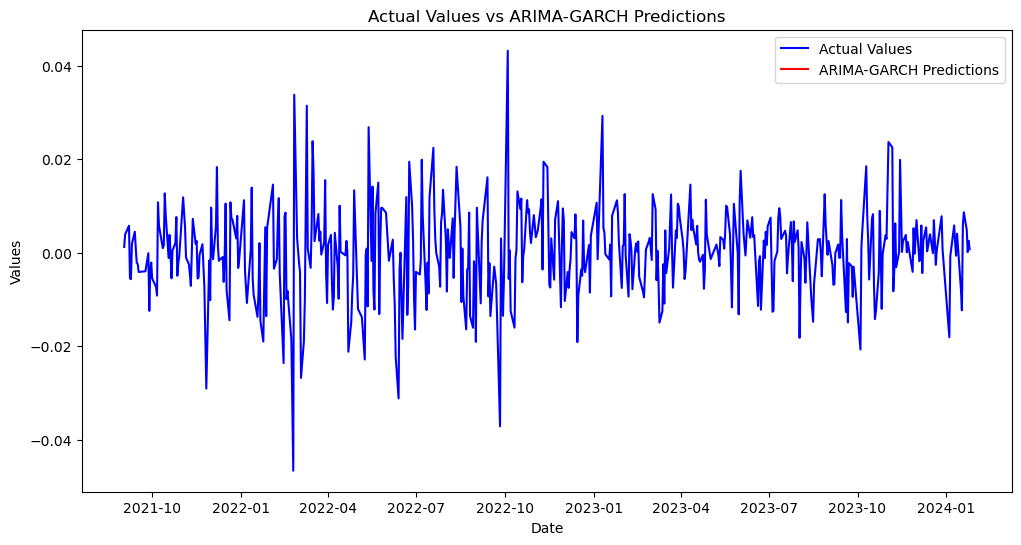

In [173]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
import matplotlib.pyplot as plt

# Load your data
# Assuming 'returns' is your returns series
returns = pd.Series(in_sample['PORTFOLIO_r'] * 100)  # Scaling the returns

# Fit ARIMA model (p, d, q) order to be specified
p, d, q = 1, 0, 1  # example order, this can be optimized based on AIC/BIC
arima_model = ARIMA(returns, order=(p, d, q))
arima_results = arima_model.fit()

# Print ARIMA model summary
print(arima_results.summary())

# Get residuals from ARIMA model
arima_residuals = arima_results.resid

# Fit GARCH model to the ARIMA residuals
garch_model = arch_model(arima_residuals, mean='Zero', vol='Garch', p=1, q=1)
garch_results = garch_model.fit(disp='off')

# Print GARCH model summary
print(garch_results.summary())

# Forecast the mean using the ARIMA model
n_forecast_steps = len(out_sample)
mean_forecast = arima_results.get_forecast(steps=n_forecast_steps)
mean_forecast_values = mean_forecast.predicted_mean

# Forecast the volatility using the GARCH model
garch_forecast = garch_results.forecast(horizon=n_forecast_steps)
volatility_forecast = np.sqrt(garch_forecast.variance.values[-1, :])

# Combine ARIMA mean forecast with GARCH volatility forecast
combined_forecast = mean_forecast_values + volatility_forecast

# Rescale the combined forecast back to original scale
combined_forecast /= 100

# Create a DataFrame for visualization
forecast_df = pd.DataFrame({
    'Actual': out_sample['PORTFOLIO_r'].values,
    'ARIMA-GARCH Predictions': combined_forecast
}, index=out_sample.index)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(forecast_df['Actual'], label='Actual Values', color='blue')
plt.plot(forecast_df['ARIMA-GARCH Predictions'], label='ARIMA-GARCH Predictions', color='red')
plt.title('Actual Values vs ARIMA-GARCH Predictions')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.show()


C:\Users\Afat\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Afat\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Afat\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:            PORTFOLIO_r   No. Observations:                 4736
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -7141.088
Date:                Sun, 23 Jun 2024   AIC                          14290.176
Time:                        19:45:33   BIC                          14316.028
Sample:                             0   HQIC                         14299.262
                               - 4736                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0149      0.019      0.796      0.426      -0.022       0.052
ar.L1         -0.0293      0.058     -0.509      0.611      -0.142       0.084
ma.L1          0.1662      0.055      3.009      0.0

C:\Users\Afat\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Afat\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


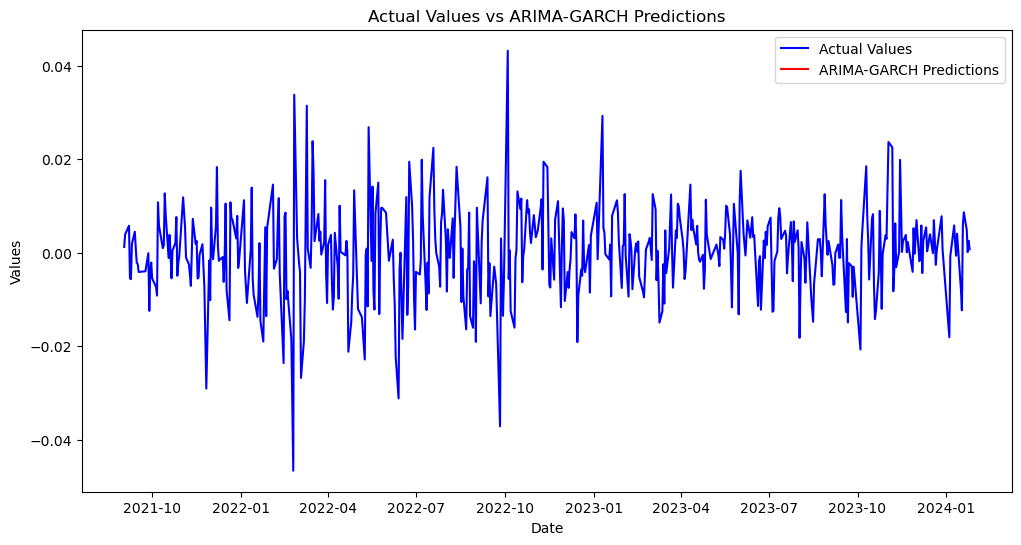

In [174]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
import matplotlib.pyplot as plt

# Load your data
# Assuming 'returns' is your returns series
returns = pd.Series(in_sample['PORTFOLIO_r'] * 100)  # Scaling the returns

# Fit ARIMA model (p, d, q) order to be specified
p, d, q = 1, 0, 1  # example order, this can be optimized based on AIC/BIC
arima_model = ARIMA(returns, order=(p, d, q))
arima_results = arima_model.fit()

# Print ARIMA model summary
print(arima_results.summary())

# Get residuals from ARIMA model
arima_residuals = arima_results.resid

# Fit GARCH model to the ARIMA residuals
garch_model = arch_model(arima_residuals, mean='Zero', vol='Garch', p=1, q=1)
garch_results = garch_model.fit(disp='off')

# Print GARCH model summary
print(garch_results.summary())

# Forecast the mean using the ARIMA model
n_forecast_steps = len(out_sample)
mean_forecast = arima_results.get_forecast(steps=n_forecast_steps)
mean_forecast_values = mean_forecast.predicted_mean

# Forecast the volatility using the GARCH model
garch_forecast = garch_results.forecast(horizon=n_forecast_steps)
volatility_forecast = np.sqrt(garch_forecast.variance.values[-1, :])

# Combine ARIMA mean forecast with GARCH volatility forecast
combined_forecast = mean_forecast_values + volatility_forecast

# Rescale the combined forecast back to original scale
combined_forecast /= 100

# Ensure the combined forecast length matches the out-sample length
combined_forecast = combined_forecast[:n_forecast_steps]

# Create a DataFrame for visualization
forecast_df = pd.DataFrame({
    'Actual': out_sample['PORTFOLIO_r'].values,
    'ARIMA-GARCH Predictions': combined_forecast
}, index=out_sample.index)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(forecast_df['Actual'], label='Actual Values', color='blue')
plt.plot(forecast_df['ARIMA-GARCH Predictions'], label='ARIMA-GARCH Predictions', color='red')
plt.title('Actual Values vs ARIMA-GARCH Predictions')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.show()


### Comparison

In [177]:
# Create a DataFrame to store the AIC and BIC
model_comparison = pd.DataFrame({
    'Model': ['ARCH(1)', 'GARCH(1,1)', 'TGARCH', 'EGARCH', 'GARCH-t(1,1)', 'ARIMA-GARCH'],
    'AIC': [arch1_results.aic, garch11_results.aic, tgarch_results.aic, egarch_results.aic, garch_t_result.aic, arima_results.aic + garch_results.aic],
    'BIC': [arch1_results.bic, garch11_results.bic, tgarch_results.bic, egarch_results.bic, garch_t_result.bic, arima_results.bic + garch_results.bic]
})

# Display the DataFrame sorted by AIC then BIC
model_comparison.sort_values(by=['AIC', 'BIC'])

,Model,AIC,BIC
3,EGARCH,12410.774235,12443.088976
2,TGARCH,12427.770240,12460.084981
4,"GARCH-t(1,1)",12537.909129,12563.760922
1,"GARCH(1,1)",12830.869218,12850.258063
0,ARCH(1),13913.920504,13933.309348
5,ARIMA-GARCH,27001.918624,27047.159261


In [178]:
# Create a DataFrame to store the AIC and BIC
model_comparison = pd.DataFrame({
    'Model': ['ARCH(1)', 'GARCH(1,1)', 'TGARCH', 'EGARCH', 'GARCH-t(1,1)'],
    'AIC': [arch1_results.aic, garch11_results.aic, tgarch_results.aic, egarch_results.aic, garch_t_result.aic],
    'BIC': [arch1_results.bic, garch11_results.bic, tgarch_results.bic, egarch_results.bic, garch_t_result.bic]
})

# Display the DataFrame sorted by AIC then BIC
model_comparison.sort_values(by=['AIC', 'BIC'])

,Model,AIC,BIC
3,EGARCH,12410.774235,12443.088976
2,TGARCH,12427.770240,12460.084981
4,"GARCH-t(1,1)",12537.909129,12563.760922
1,"GARCH(1,1)",12830.869218,12850.258063
0,ARCH(1),13913.920504,13933.309348


1. **EGARCH** shows the lowest AIC and BIC among the models, suggesting it may be the best fit among those compared, considering both goodness of fit and model complexity.

2. **TGARCH** is the next best model based on these criteria, indicating that accounting for asymmetric shocks (leverage effects) improves the model fit over the standard GARCH(1,1).

3. **GARCH-t(1,1)** follows closely, suggesting that using a Student's t-distribution for the innovations improves the model over the standard GARCH(1,1) with normal errors.

4. **GARCH(1,1)** and **ARCH(1)** have higher AIC and BIC values, indicating a less favorable balance between model complexity and fit.

When choosing a model based on AIC and BIC, typically the model with the lower values is preferred because it suggests a better fit with fewer parameters (parsimony). However, it's crucial to also consider other model diagnostics like the standardized residuals, their autocorrelation, and particularly for forecasting models, the out-of-sample prediction performance. 

Before finalizing the model selection, it's recommended to perform additional diagnostic checks on the residuals, such as:
- Testing for autocorrelation in standardized and squared residuals.
- Checking the normality of the residuals.
- Performing out-of-sample forecasting to validate predictive performance.

These steps will help to ensure that the selected model not only fits the historical data well but is also robust and reliable for forecasting future volatility.

In [131]:
# Function to forecast out-of-sample using simulation for models that do not support analytic forecasting
def forecast_out_of_sample_simulation(fitted_model, steps, start_date, simulations=1000):
    # Get the number of observations in the in-sample period
    nobs_in_sample = len(fitted_model.conditional_volatility)
    # Generate forecasts using simulations
    forecasts = fitted_model.forecast(horizon=steps, start=nobs_in_sample - 1, method='simulation', simulations=simulations)
    forecasted_volatility = np.sqrt(forecasts.variance.values[-1, :])
    return pd.Series(forecasted_volatility, index=pd.date_range(start=start_date, periods=steps))

# Specify the number of out-of-sample steps
n_out_sample_steps = len(out_sample)

# Forecast for each model
arch1_forecast = forecast_out_of_sample(arch1_results, n_out_sample_steps, out_sample.index[0])
garch11_forecast = forecast_out_of_sample(garch11_results, n_out_sample_steps, out_sample.index[0])
garch_t_forecast = forecast_out_of_sample(garch_t_results, n_out_sample_steps, out_sample.index[0])
egarch_forecast = forecast_out_of_sample_simulation(egarch_results, n_out_sample_steps, out_sample.index[0])
tgarch_default_forecast = forecast_out_of_sample_simulation(tgarch_default_results, n_out_sample_steps, out_sample.index[0])
tgarch_linear_forecast = forecast_out_of_sample_simulation(tgarch_linear_results, n_out_sample_steps, out_sample.index[0])

# Combine forecasts into a DataFrame
out_sample_forecasts_df = pd.DataFrame({
    'Actual': out_sample['PORTFOLIO_r'] * 100,
    'ARCH(1)': arch1_forecast,
    'GARCH(1,1)': garch11_forecast,
    'GARCH-t': garch_t_forecast,
    'EGARCH': egarch_forecast,
    'TGARCH_Default': tgarch_default_forecast,
    'TGARCH_Linear': tgarch_linear_forecast
})

# Display the out-of-sample forecasts DataFrame
print(out_sample_forecasts_df.head())


              Actual   ARCH(1)  GARCH(1,1)   GARCH-t    EGARCH  \
2021-09-02  0.121446  0.932304    0.645437  0.648288  0.635112   
2021-09-03  0.388593  1.071017    0.653087  0.654618  0.645481   
2021-09-04       NaN  1.115127    0.660568  0.660818  0.656939   
2021-09-05       NaN  1.130032    0.667884  0.666893  0.666611   
2021-09-06       NaN  1.135158    0.675044  0.672846  0.675880   

            TGARCH_Default  TGARCH_Linear  
2021-09-02        0.654676       0.630865  
2021-09-03        0.662781       0.638719  
2021-09-04        0.670779       0.649996  
2021-09-05        0.680948       0.662261  
2021-09-06        0.689351       0.672200  


# LSTM

In [60]:
# Importing required libraries for LSTM
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import mean_squared_error



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LassoCV, Lasso

## Feature Engineering

### Rolling volatility window

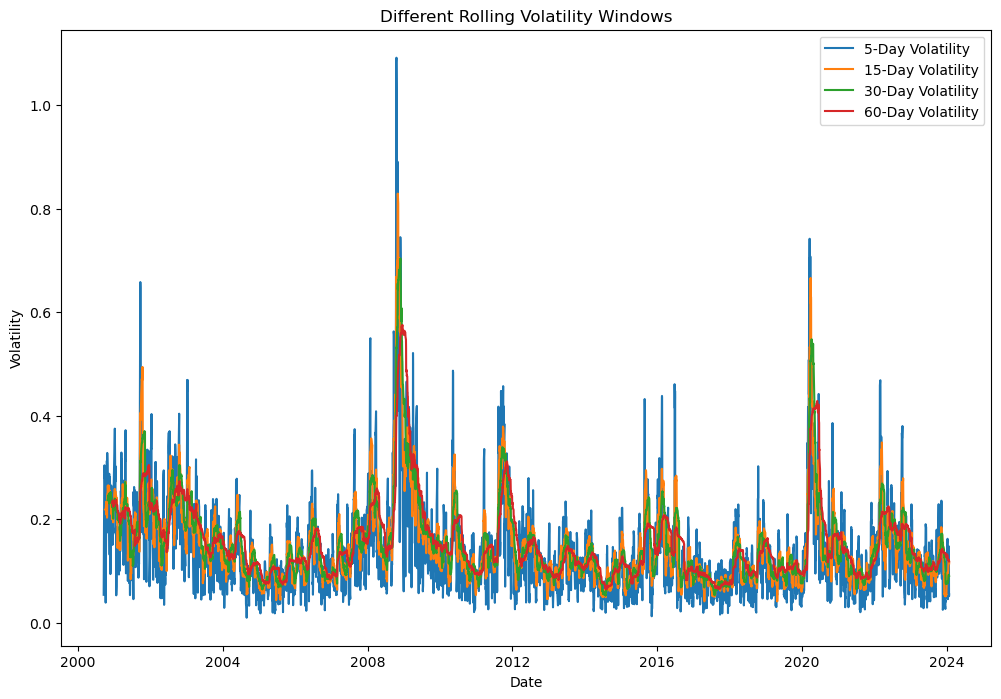

                  SP500          DAX   WIG20  KOSPI200    NKK225      SP_r  \
2000-09-05  1507.079956  7395.069824  1919.5    679.24  16452.27 -0.009043   
2000-09-06  1492.250000  7333.020020  1910.9    676.69  16399.87 -0.009889   
2000-09-07  1502.510010  7373.339844  1894.0    656.37  16300.46  0.006852   
2000-09-08  1494.500000  7267.770020  1888.7    653.68  16501.55 -0.005345   
2000-09-14  1480.869995  7048.500000  1907.2    650.14  16213.28 -0.009162   

               DAX_r   WIG20_r  KOSPI200_r  NKK225_r  ...  ROC_Long_Term  \
2000-09-05  0.006839 -0.016790   -0.018886 -0.017324  ...       3.963795   
2000-09-06 -0.008426 -0.004490   -0.003761 -0.003190  ...       5.096168   
2000-09-07  0.005483 -0.008883   -0.030489 -0.006080  ...       5.009684   
2000-09-08 -0.014421 -0.002802   -0.004107  0.012261  ...       3.921843   
2000-09-14 -0.030635  0.009747   -0.005430 -0.017624  ...       2.931122   

            Volatility  PORTFOLIO_r_mean_5  PORTFOLIO_r_std_5  \
2000-09-0

In [192]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Calculate rolling volatility for different window sizes
for window in [5, 15, 30, 60]:
    portfolio[f'Volatility_{window}d'] = portfolio['PORTFOLIO_r'].rolling(window=window).std() * np.sqrt(252)  # Annualized

# Plot different rolling volatilities and save the plot
plt.figure(figsize=(12, 8))
plt.plot(portfolio['Volatility_5d'], label='5-Day Volatility')
plt.plot(portfolio['Volatility_15d'], label='15-Day Volatility')
plt.plot(portfolio['Volatility_30d'], label='30-Day Volatility')
plt.plot(portfolio['Volatility_60d'], label='60-Day Volatility')
plt.title('Different Rolling Volatility Windows')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.savefig('rolling_volatility_windows.png')
plt.show()

# Drop the volatility columns to clean up the DataFrame
portfolio.drop(columns=['Volatility_5d', 'Volatility_15d', 'Volatility_30d', 'Volatility_60d'], inplace=True)

# Display the first few rows of the modified DataFrame
print(portfolio.head())


### Moving Average Window

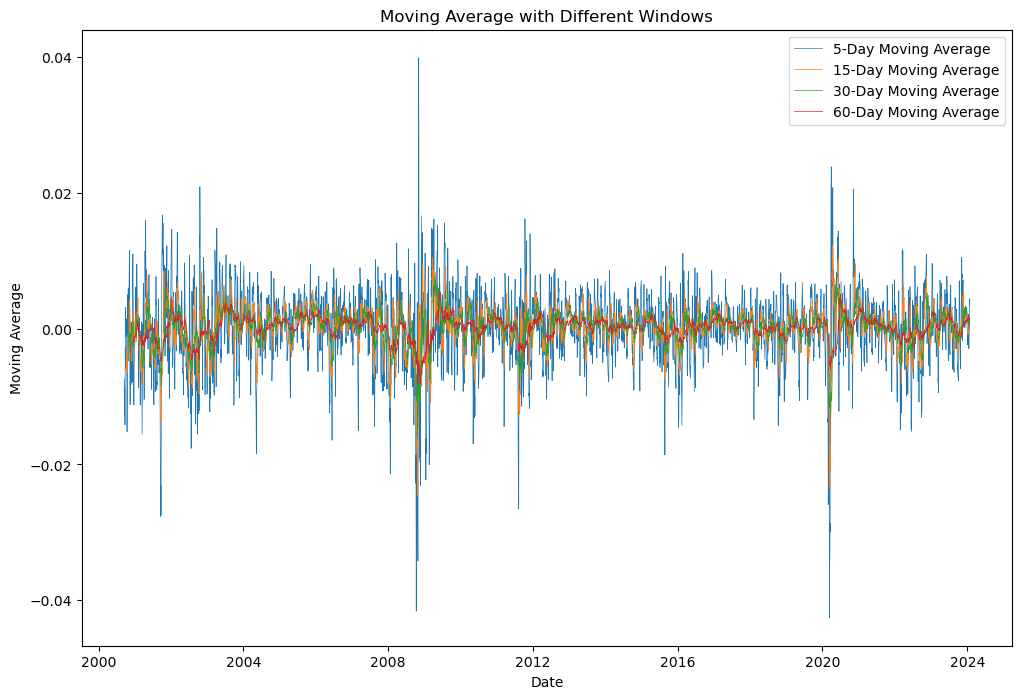

                  SP500          DAX   WIG20  KOSPI200    NKK225      SP_r  \
2000-09-05  1507.079956  7395.069824  1919.5    679.24  16452.27 -0.009043   
2000-09-06  1492.250000  7333.020020  1910.9    676.69  16399.87 -0.009889   
2000-09-07  1502.510010  7373.339844  1894.0    656.37  16300.46  0.006852   
2000-09-08  1494.500000  7267.770020  1888.7    653.68  16501.55 -0.005345   
2000-09-14  1480.869995  7048.500000  1907.2    650.14  16213.28 -0.009162   

               DAX_r   WIG20_r  KOSPI200_r  NKK225_r  ...  ROC_Long_Term  \
2000-09-05  0.006839 -0.016790   -0.018886 -0.017324  ...       3.963795   
2000-09-06 -0.008426 -0.004490   -0.003761 -0.003190  ...       5.096168   
2000-09-07  0.005483 -0.008883   -0.030489 -0.006080  ...       5.009684   
2000-09-08 -0.014421 -0.002802   -0.004107  0.012261  ...       3.921843   
2000-09-14 -0.030635  0.009747   -0.005430 -0.017624  ...       2.931122   

            Volatility  PORTFOLIO_r_mean_5  PORTFOLIO_r_std_5  \
2000-09-0

In [193]:
# Calculate moving average for different window sizes
for window in [5, 15, 30, 60]:
    portfolio[f'MA_{window}d'] = portfolio['PORTFOLIO_r'].rolling(window=window).mean()

# Plot different moving averages and save the plot
plt.figure(figsize=(12, 8))
plt.plot(portfolio['MA_5d'], label='5-Day Moving Average', linewidth=0.5)
plt.plot(portfolio['MA_15d'], label='15-Day Moving Average', linewidth=0.5)
plt.plot(portfolio['MA_30d'], label='30-Day Moving Average', linewidth=0.5)
plt.plot(portfolio['MA_60d'], label='60-Day Moving Average', linewidth=0.5)
plt.title('Moving Average with Different Windows')
plt.xlabel('Date')
plt.ylabel('Moving Average')
plt.legend()
plt.savefig('moving_average_windows.png')
plt.show()

# Drop the moving average columns to clean up the DataFrame
portfolio.drop(columns=['MA_5d', 'MA_15d', 'MA_30d', 'MA_60d'], inplace=True)

# Display the first few rows of the modified DataFrame
print(portfolio.head())

### Exponential moving average

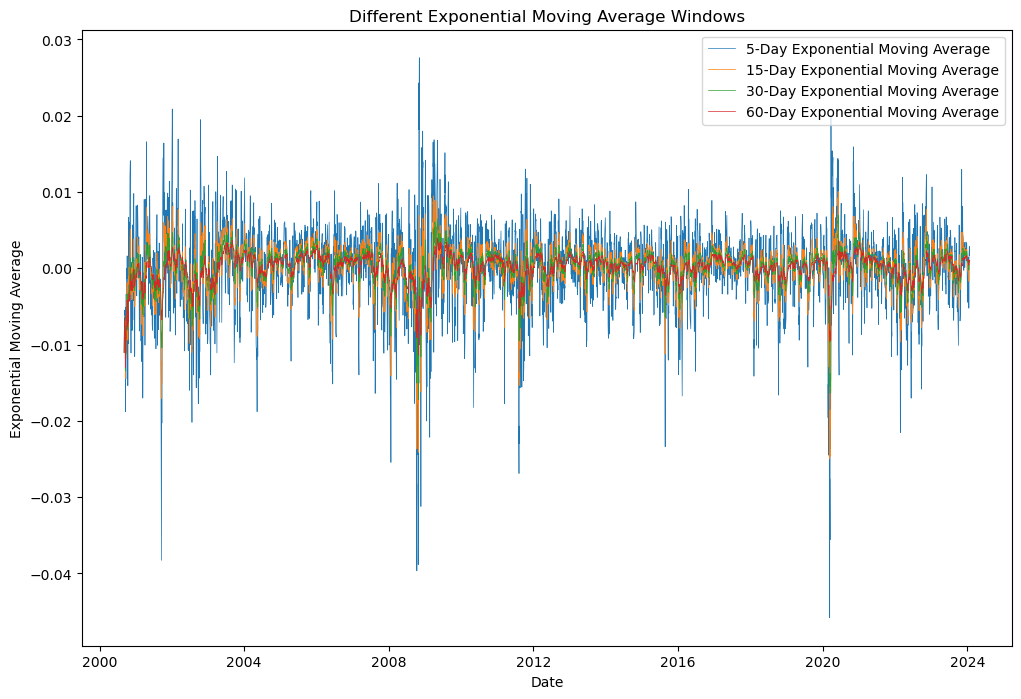

                  SP500          DAX   WIG20  KOSPI200    NKK225      SP_r  \
2000-09-05  1507.079956  7395.069824  1919.5    679.24  16452.27 -0.009043   
2000-09-06  1492.250000  7333.020020  1910.9    676.69  16399.87 -0.009889   
2000-09-07  1502.510010  7373.339844  1894.0    656.37  16300.46  0.006852   
2000-09-08  1494.500000  7267.770020  1888.7    653.68  16501.55 -0.005345   
2000-09-14  1480.869995  7048.500000  1907.2    650.14  16213.28 -0.009162   

               DAX_r   WIG20_r  KOSPI200_r  NKK225_r  ...  ROC_Long_Term  \
2000-09-05  0.006839 -0.016790   -0.018886 -0.017324  ...       3.963795   
2000-09-06 -0.008426 -0.004490   -0.003761 -0.003190  ...       5.096168   
2000-09-07  0.005483 -0.008883   -0.030489 -0.006080  ...       5.009684   
2000-09-08 -0.014421 -0.002802   -0.004107  0.012261  ...       3.921843   
2000-09-14 -0.030635  0.009747   -0.005430 -0.017624  ...       2.931122   

            Volatility  PORTFOLIO_r_mean_5  PORTFOLIO_r_std_5  \
2000-09-0

In [194]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Calculate exponential moving average for different window sizes
for window in [5, 15, 30, 60]:
    portfolio[f'EMA_{window}d'] = portfolio['PORTFOLIO_r'].ewm(span=window).mean()

# Plot different exponential moving averages
plt.figure(figsize=(12, 8))
plt.plot(portfolio['EMA_5d'], label='5-Day Exponential Moving Average', linewidth=0.5)
plt.plot(portfolio['EMA_15d'], label='15-Day Exponential Moving Average', linewidth=0.5)
plt.plot(portfolio['EMA_30d'], label='30-Day Exponential Moving Average', linewidth=0.5)
plt.plot(portfolio['EMA_60d'], label='60-Day Exponential Moving Average', linewidth=0.5)
plt.title('Different Exponential Moving Average Windows')
plt.xlabel('Date')
plt.ylabel('Exponential Moving Average')
plt.legend()
plt.savefig('exponential_moving_average_windows.png')
plt.show()

# Drop the exponential moving average columns to clean up the DataFrame
portfolio.drop(columns=['EMA_5d', 'EMA_15d', 'EMA_30d', 'EMA_60d'], inplace=True)

# Display the first few rows of the modified DataFrame
print(portfolio.head())


### Bollinger Bands

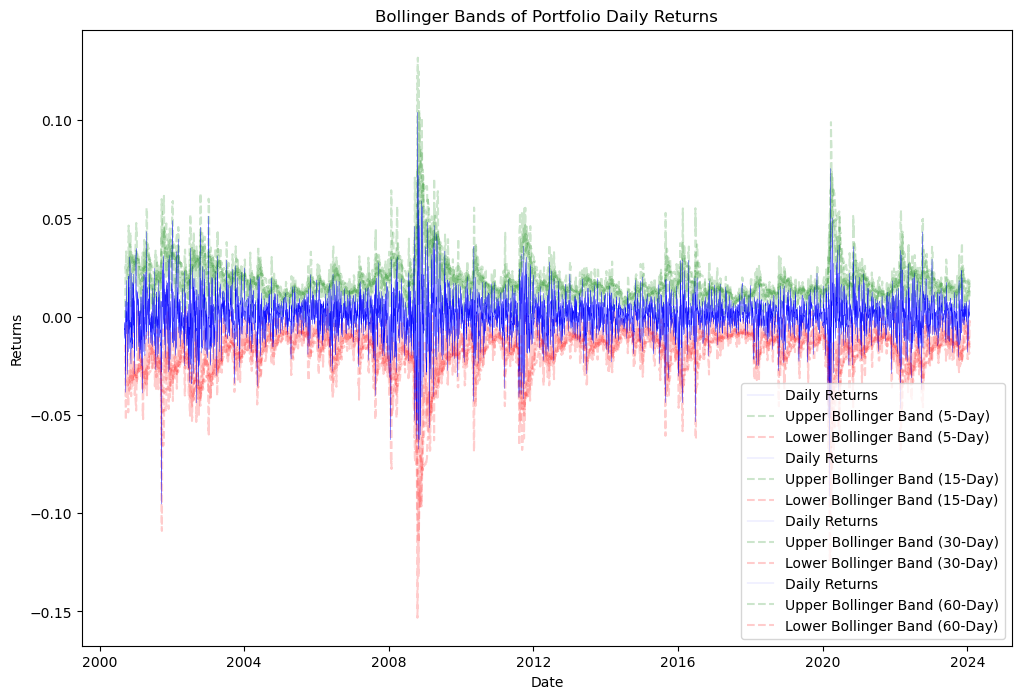

                  SP500          DAX   WIG20  KOSPI200    NKK225      SP_r  \
2000-09-05  1507.079956  7395.069824  1919.5    679.24  16452.27 -0.009043   
2000-09-06  1492.250000  7333.020020  1910.9    676.69  16399.87 -0.009889   
2000-09-07  1502.510010  7373.339844  1894.0    656.37  16300.46  0.006852   
2000-09-08  1494.500000  7267.770020  1888.7    653.68  16501.55 -0.005345   
2000-09-14  1480.869995  7048.500000  1907.2    650.14  16213.28 -0.009162   

               DAX_r   WIG20_r  KOSPI200_r  NKK225_r  ...  ROC_Long_Term  \
2000-09-05  0.006839 -0.016790   -0.018886 -0.017324  ...       3.963795   
2000-09-06 -0.008426 -0.004490   -0.003761 -0.003190  ...       5.096168   
2000-09-07  0.005483 -0.008883   -0.030489 -0.006080  ...       5.009684   
2000-09-08 -0.014421 -0.002802   -0.004107  0.012261  ...       3.921843   
2000-09-14 -0.030635  0.009747   -0.005430 -0.017624  ...       2.931122   

            Volatility  PORTFOLIO_r_mean_5  PORTFOLIO_r_std_5  \
2000-09-0

In [195]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Defining the initial parameters for the Bollinger Bands
Daily_Return_windows = [5, 15, 30, 60]
std_dev_multiplier = 2

# Calculating the Bollinger Bands
for window in Daily_Return_windows:
    portfolio[f'RollingMean_{window}d'] = portfolio['PORTFOLIO_r'].rolling(window=window).mean()
    portfolio[f'RollingStd_{window}d'] = portfolio['PORTFOLIO_r'].rolling(window=window).std()
    portfolio[f'UpperBollinger_{window}d'] = portfolio[f'RollingMean_{window}d'] + (portfolio[f'RollingStd_{window}d'] * std_dev_multiplier)
    portfolio[f'LowerBollinger_{window}d'] = portfolio[f'RollingMean_{window}d'] - (portfolio[f'RollingStd_{window}d'] * std_dev_multiplier)

# Plotting Bollinger Bands
plt.figure(figsize=(12, 8))
for window in Daily_Return_windows:
    plt.plot(portfolio['PORTFOLIO_r'], label='Daily Returns', alpha=0.8, color='blue', linewidth=0.1)
    plt.plot(portfolio[f'UpperBollinger_{window}d'], label=f'Upper Bollinger Band ({window}-Day)', linestyle='--', alpha=0.2, color='green')
    plt.plot(portfolio[f'LowerBollinger_{window}d'], label=f'Lower Bollinger Band ({window}-Day)', linestyle='--', alpha=0.2, color='red')

plt.title('Bollinger Bands of Portfolio Daily Returns')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.savefig('bollinger_bands.png')
plt.show()

# Drop the Bollinger Bands columns to clean up the DataFrame
columns_to_drop = [f'RollingMean_{window}d' for window in Daily_Return_windows] + \
                  [f'RollingStd_{window}d' for window in Daily_Return_windows] + \
                  [f'UpperBollinger_{window}d' for window in Daily_Return_windows] + \
                  [f'LowerBollinger_{window}d' for window in Daily_Return_windows]

portfolio.drop(columns=columns_to_drop, inplace=True)

# Display the first few rows of the modified DataFrame
print(portfolio.head())


### RSI calculation

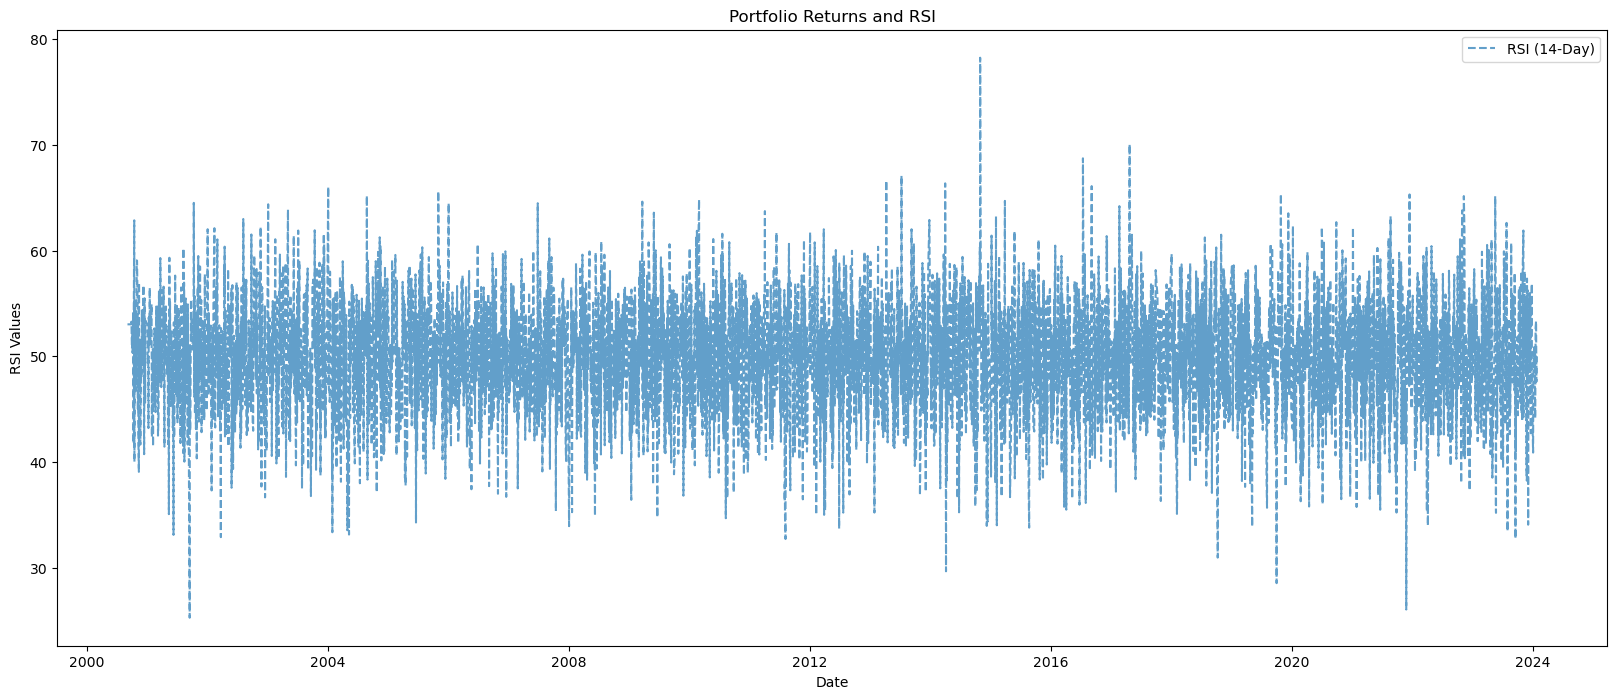

                  SP500          DAX   WIG20  KOSPI200    NKK225      SP_r  \
2000-09-05  1507.079956  7395.069824  1919.5    679.24  16452.27 -0.009043   
2000-09-06  1492.250000  7333.020020  1910.9    676.69  16399.87 -0.009889   
2000-09-07  1502.510010  7373.339844  1894.0    656.37  16300.46  0.006852   
2000-09-08  1494.500000  7267.770020  1888.7    653.68  16501.55 -0.005345   
2000-09-14  1480.869995  7048.500000  1907.2    650.14  16213.28 -0.009162   

               DAX_r   WIG20_r  KOSPI200_r  NKK225_r  ...  ROC_Long_Term  \
2000-09-05  0.006839 -0.016790   -0.018886 -0.017324  ...       3.963795   
2000-09-06 -0.008426 -0.004490   -0.003761 -0.003190  ...       5.096168   
2000-09-07  0.005483 -0.008883   -0.030489 -0.006080  ...       5.009684   
2000-09-08 -0.014421 -0.002802   -0.004107  0.012261  ...       3.921843   
2000-09-14 -0.030635  0.009747   -0.005430 -0.017624  ...       2.931122   

            Volatility  PORTFOLIO_r_mean_5  PORTFOLIO_r_std_5  \
2000-09-0

In [196]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'portfolio' DataFrame is already prepared and contains the 'PORTFOLIO_r' column for log returns

# Main function to calculate the RSI
def calculate_rsi(data, window=14):
    delta = data.diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi

rsi_window = 14  # Most common window size
portfolio['RSI'] = calculate_rsi(portfolio['PORTFOLIO_r'], window=rsi_window)

# Option to fill NaN values (if needed)
portfolio['RSI'] = portfolio['RSI'].bfill()

# Plotting RSI
plt.figure(figsize=(20, 8))
plt.plot(portfolio['RSI'], label=f'RSI ({rsi_window}-Day)', linestyle='--', alpha=0.7)

plt.title('Portfolio Returns and RSI')
plt.xlabel('Date')
plt.ylabel('RSI Values')
plt.legend()
plt.savefig('rsi.png')
plt.show()

# Display the first few rows of the modified DataFrame
print(portfolio.head())


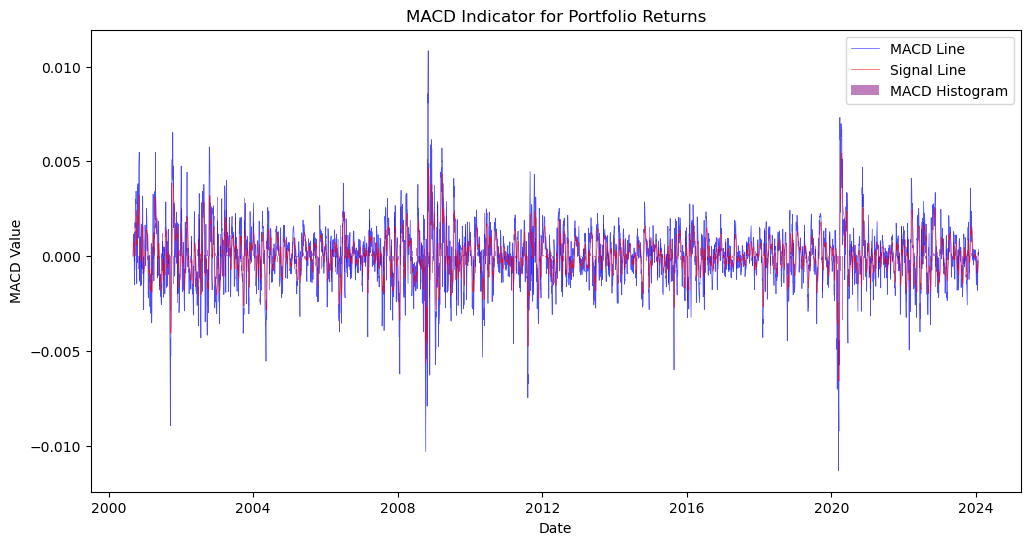

                  SP500          DAX   WIG20  KOSPI200    NKK225      SP_r  \
2000-09-05  1507.079956  7395.069824  1919.5    679.24  16452.27 -0.009043   
2000-09-06  1492.250000  7333.020020  1910.9    676.69  16399.87 -0.009889   
2000-09-07  1502.510010  7373.339844  1894.0    656.37  16300.46  0.006852   
2000-09-08  1494.500000  7267.770020  1888.7    653.68  16501.55 -0.005345   
2000-09-14  1480.869995  7048.500000  1907.2    650.14  16213.28 -0.009162   

               DAX_r   WIG20_r  KOSPI200_r  NKK225_r  ...  ROC_Long_Term  \
2000-09-05  0.006839 -0.016790   -0.018886 -0.017324  ...       3.963795   
2000-09-06 -0.008426 -0.004490   -0.003761 -0.003190  ...       5.096168   
2000-09-07  0.005483 -0.008883   -0.030489 -0.006080  ...       5.009684   
2000-09-08 -0.014421 -0.002802   -0.004107  0.012261  ...       3.921843   
2000-09-14 -0.030635  0.009747   -0.005430 -0.017624  ...       2.931122   

            Volatility  PORTFOLIO_r_mean_5  PORTFOLIO_r_std_5  \
2000-09-0

In [197]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'portfolio' DataFrame is already prepared and contains the 'PORTFOLIO_r' column for log returns
portfolio.index = pd.to_datetime(portfolio.index)

# Defining the initial parameters for the MACD (most commonly used)
short_window = 12
long_window = 26

# Calculating the 12-day and 26-day EMA for the 'PORTFOLIO_r'
portfolio[f'EMA_{short_window}d'] = portfolio['PORTFOLIO_r'].ewm(span=short_window, adjust=False).mean()
portfolio[f'EMA_{long_window}d'] = portfolio['PORTFOLIO_r'].ewm(span=long_window, adjust=False).mean()

# Calculating the MACD Line, Signal line and histogram
portfolio['MACD_Line'] = portfolio[f'EMA_{short_window}d'] - portfolio[f'EMA_{long_window}d']

# Calculating the Signal Line (9-day EMA of the MACD Line)
portfolio['Signal_Line'] = portfolio['MACD_Line'].ewm(span=9).mean()

# Calculating the MACD Histogram (MACD Line - Signal Line)
portfolio['MACD_Histogram'] = portfolio['MACD_Line'] - portfolio['Signal_Line']

# Plotting MACD and Signal Line
plt.figure(figsize=(12, 6))
plt.plot(portfolio.index, portfolio['MACD_Line'], label='MACD Line', color='blue', alpha=0.7, linewidth=0.5)
plt.plot(portfolio.index, portfolio['Signal_Line'], label='Signal Line', color='red', alpha=0.7, linewidth=0.5)
plt.bar(portfolio.index, portfolio['MACD_Histogram'], label='MACD Histogram', color='purple', alpha=0.5)
plt.title('MACD Indicator for Portfolio Returns')
plt.xlabel('Date')
plt.ylabel('MACD Value')
plt.legend()
plt.savefig('macd.png')
plt.show()

# Dropping the columns that are not needed (we only need the MACD Line and Signal Line)
portfolio.drop(columns=[f'EMA_{short_window}d', f'EMA_{long_window}d'], inplace=True)

# Display the first few rows of the modified DataFrame
print(portfolio.head())


In [31]:
# Import necessary libraries
import numpy as np
import pandas as pd

# Assuming 'portfolio' DataFrame is already prepared and contains the 'PORTFOLIO_r' column for log returns

# Create lagged features
portfolio['Lagged_Close'] = portfolio['SP500'].shift(1)  # Using SP500 as an example for the closing price
portfolio['Lagged_Return'] = portfolio['PORTFOLIO_r'].shift(1)  # Using PORTFOLIO_r for returns
portfolio['Lagged_Close_5d'] = portfolio['SP500'].shift(5)  # 5-day lag for closing price
portfolio['Lagged_Return_5d'] = portfolio['PORTFOLIO_r'].shift(5)  # 5-day lag for returns

# Calculate log returns
portfolio['Log_Return'] = np.log(portfolio['SP500'] / portfolio['SP500'].shift(1))  # Using SP500 for log returns

# Display the first few rows of the modified DataFrame
print(portfolio.head())


                  SP500          DAX   WIG20  KOSPI200    NKK225      SP_r  \
2000-01-11  1438.560059  6891.250000  1974.9    981.33  18850.92 -0.002021   
2000-01-12  1432.250000  6912.810059  1961.3    955.01  18677.42 -0.004396   
2000-01-13  1449.680054  6955.979980  2032.9    951.05  18833.29  0.012096   
2000-01-14  1465.150024  7173.220215  2010.5    948.03  18956.55  0.010615   
2000-01-18  1455.140015  7072.120117  1982.6    981.53  19196.57 -0.006856   

               DAX_r   WIG20_r  KOSPI200_r  NKK225_r  ...  PORTFOLIO_r  \
2000-01-11  0.016134  0.021341    0.033869  0.035502  ...     0.020965   
2000-01-12  0.003124 -0.006910   -0.027187 -0.009246  ...    -0.008923   
2000-01-13  0.006225  0.035856   -0.004155  0.008311  ...     0.011667   
2000-01-14  0.030753 -0.011080   -0.003180  0.006523  ...     0.006726   
2000-01-18 -0.014194 -0.013974    0.034726  0.012582  ...     0.002457   

                  RSI  MACD_Line  Signal_Line  MACD_Histogram  Lagged_Close  \
2000-01

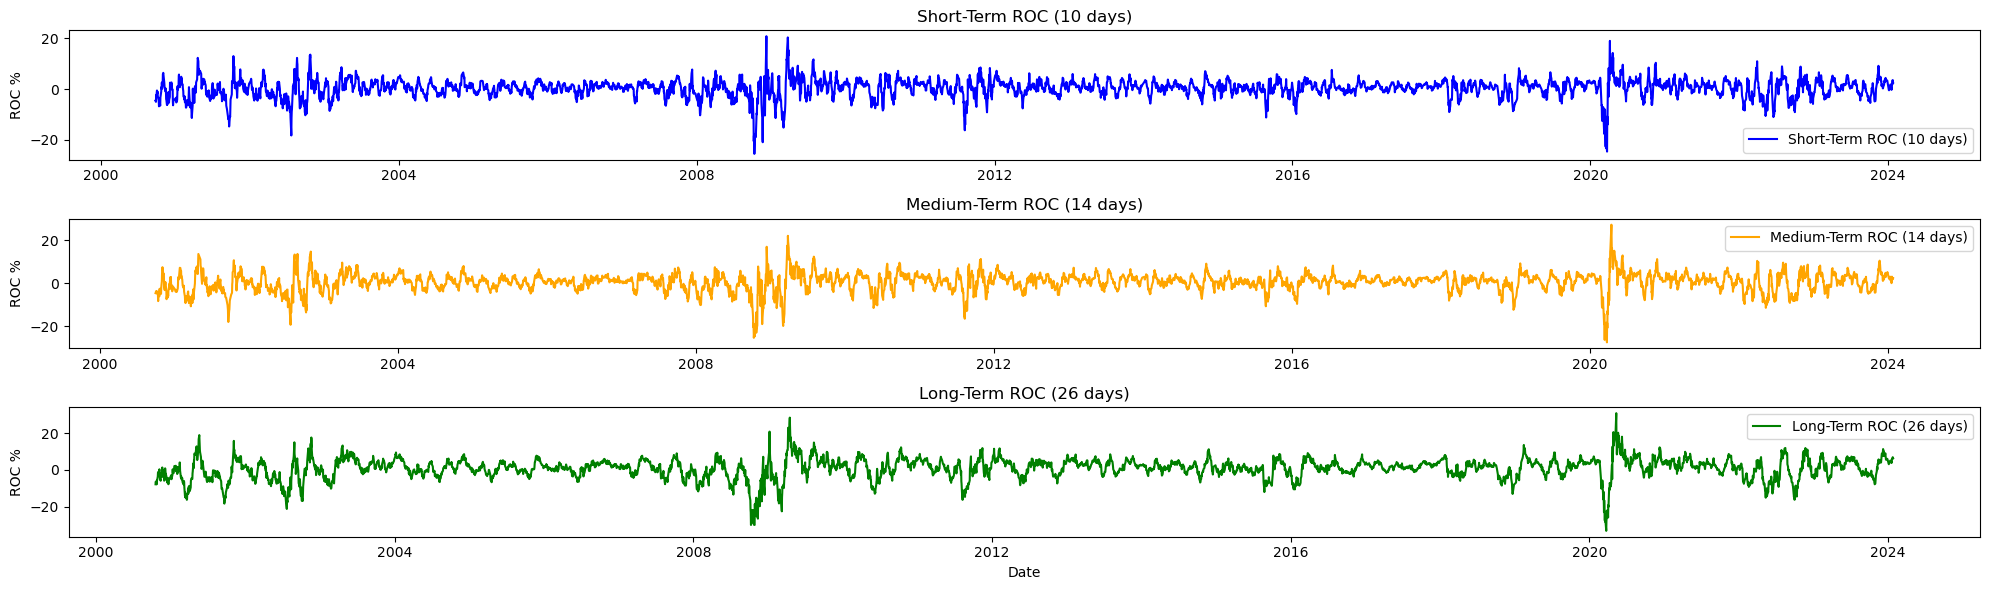

                  SP500          DAX   WIG20  KOSPI200    NKK225      SP_r  \
2000-09-05  1507.079956  7395.069824  1919.5    679.24  16452.27 -0.009043   
2000-09-06  1492.250000  7333.020020  1910.9    676.69  16399.87 -0.009889   
2000-09-07  1502.510010  7373.339844  1894.0    656.37  16300.46  0.006852   
2000-09-08  1494.500000  7267.770020  1888.7    653.68  16501.55 -0.005345   
2000-09-14  1480.869995  7048.500000  1907.2    650.14  16213.28 -0.009162   

               DAX_r   WIG20_r  KOSPI200_r  NKK225_r  ...  ROC_Long_Term  \
2000-09-05  0.006839 -0.016790   -0.018886 -0.017324  ...            NaN   
2000-09-06 -0.008426 -0.004490   -0.003761 -0.003190  ...            NaN   
2000-09-07  0.005483 -0.008883   -0.030489 -0.006080  ...            NaN   
2000-09-08 -0.014421 -0.002802   -0.004107  0.012261  ...            NaN   
2000-09-14 -0.030635  0.009747   -0.005430 -0.017624  ...            NaN   

            Volatility  PORTFOLIO_r_mean_5  PORTFOLIO_r_std_5  \
2000-09-0

In [198]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'portfolio' DataFrame is already prepared and contains the relevant data
portfolio.index = pd.to_datetime(portfolio.index)

# Defining the initial parameters for the ROC
short_term_n = 10  # 10 days, short-term
medium_term_n = 14  # 14 days, medium-term
long_term_n = 26   # 26 days, long-term

# Calculations for ROC using the 'SP500' column as an example
portfolio['ROC_Short_Term'] = ((portfolio['SP500'] - portfolio['SP500'].shift(short_term_n)) / portfolio['SP500'].shift(short_term_n)) * 100
portfolio['ROC_Medium_Term'] = ((portfolio['SP500'] - portfolio['SP500'].shift(medium_term_n)) / portfolio['SP500'].shift(medium_term_n)) * 100
portfolio['ROC_Long_Term'] = ((portfolio['SP500'] - portfolio['SP500'].shift(long_term_n)) / portfolio['SP500'].shift(long_term_n)) * 100

# Plotting the ROC values
plt.figure(figsize=(20, 6))

plt.subplot(3, 1, 1)
plt.plot(portfolio.index, portfolio['ROC_Short_Term'], label='Short-Term ROC (10 days)', color='blue')
plt.title('Short-Term ROC (10 days)')
plt.ylabel('ROC %')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(portfolio.index, portfolio['ROC_Medium_Term'], label='Medium-Term ROC (14 days)', color='orange')
plt.title('Medium-Term ROC (14 days)')
plt.ylabel('ROC %')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(portfolio.index, portfolio['ROC_Long_Term'], label='Long-Term ROC (26 days)', color='green')
plt.title('Long-Term ROC (26 days)')
plt.xlabel('Date')
plt.ylabel('ROC %')
plt.legend()

plt.tight_layout()
plt.savefig('roc.png')
plt.show()

# Display the first few rows of the modified DataFrame
print(portfolio.head())


             SP500       DAX     WIG20  KOSPI200    NKK225      SP_r  \
SP500     1.000000  0.947391 -0.014387  0.801400  0.955447  0.024877   
DAX       0.947391  1.000000  0.126914  0.881622  0.928217  0.022638   
WIG20    -0.014387  0.126914  1.000000  0.369911  0.088932  0.016866   
KOSPI200  0.801400  0.881622  0.369911  1.000000  0.739802  0.020145   
NKK225    0.955447  0.928217  0.088932  0.739802  1.000000  0.008611   

             DAX_r   WIG20_r  KOSPI200_r  NKK225_r  ...  ROC_Long_Term  \
SP500     0.014468  0.003279   -0.003977  0.021396  ...       0.122909   
DAX       0.022018  0.002471   -0.000763  0.025409  ...       0.140294   
WIG20     0.033467  0.028573    0.019723  0.020484  ...       0.139694   
KOSPI200  0.015308 -0.000679    0.006172  0.029022  ...       0.180979   
NKK225    0.006827 -0.000176    0.000063  0.029489  ...       0.117082   

          Volatility  PORTFOLIO_r_mean_5  PORTFOLIO_r_std_5  \
SP500      -0.234655            0.031066          -0.188580

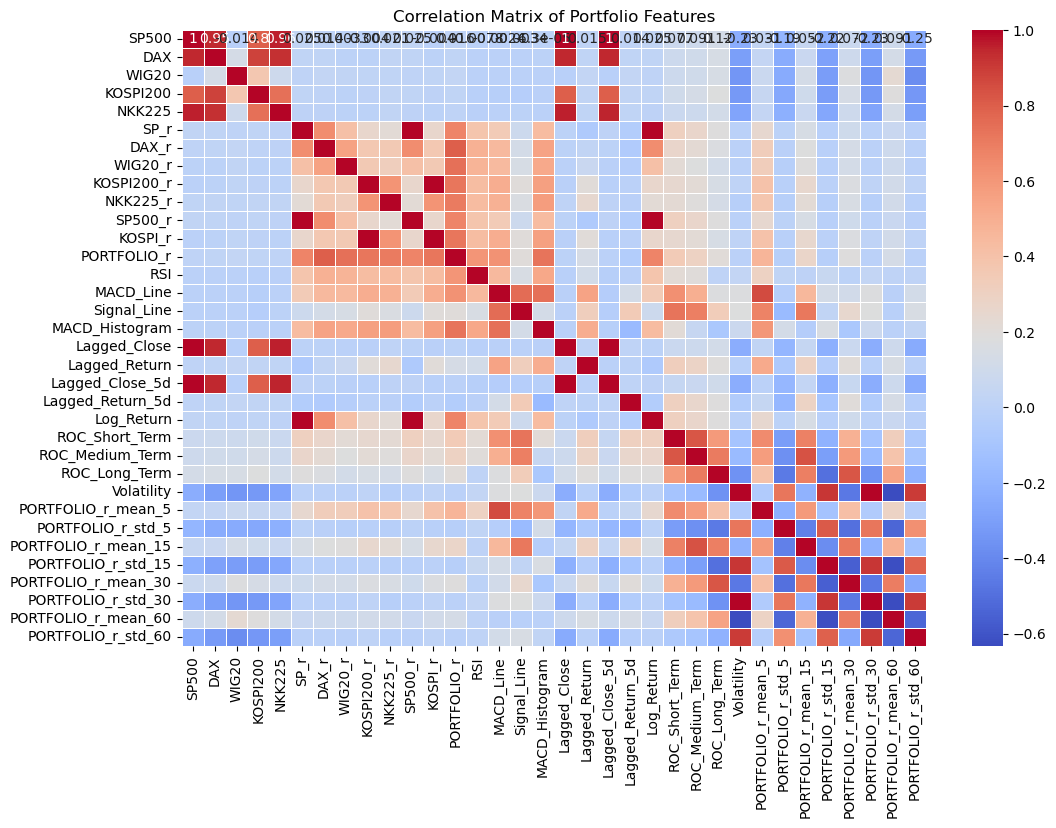

In [199]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'portfolio' DataFrame is already prepared and contains the relevant data
portfolio.index = pd.to_datetime(portfolio.index)

# Calculate the correlation matrix
correlation_matrix = portfolio.corr()

# Display the first few rows of the correlation matrix
print(correlation_matrix.head())

# Plotting the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Portfolio Features')
plt.savefig('correlation_matrix.png')
plt.show()


## Feature selection

In [200]:
portfolio.index = pd.to_datetime(portfolio.index)


# Check for missing values
missing_values = portfolio.isnull().sum()
print("Missing Values in Log Returns after removing the first row:")
print(missing_values)

# Calculate Volatility as rolling standard deviation of portfolio returns over a 30-day window
portfolio['Volatility'] = portfolio['PORTFOLIO_r'].rolling(window=30).std()

# Dropping NaN values created by the rolling operation
portfolio.dropna(inplace=True)


Missing Values in Log Returns after removing the first row:
SP500                   0
DAX                     0
WIG20                   0
KOSPI200                0
NKK225                  0
SP_r                    0
DAX_r                   0
WIG20_r                 0
KOSPI200_r              0
NKK225_r                0
SP500_r                 0
KOSPI_r                 0
PORTFOLIO_r             0
RSI                     0
MACD_Line               0
Signal_Line             0
MACD_Histogram          0
Lagged_Close            0
Lagged_Return           0
Lagged_Close_5d         0
Lagged_Return_5d        0
Log_Return              0
ROC_Short_Term         10
ROC_Medium_Term        14
ROC_Long_Term          26
Volatility              0
PORTFOLIO_r_mean_5      0
PORTFOLIO_r_std_5       0
PORTFOLIO_r_mean_15     0
PORTFOLIO_r_std_15      0
PORTFOLIO_r_mean_30     0
PORTFOLIO_r_std_30      0
PORTFOLIO_r_mean_60     0
PORTFOLIO_r_std_60      0
dtype: int64


### Splitting Data into Train and Test Sets

In [201]:
# Splitting the data into train and test sets
X = portfolio.drop(columns=['Volatility'])
y = portfolio['Volatility']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False, random_state=777)

## Standardize the Features
scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train)
X_test_standardized = scaler.transform(X_test)



### Correlation Analysis on Training Data

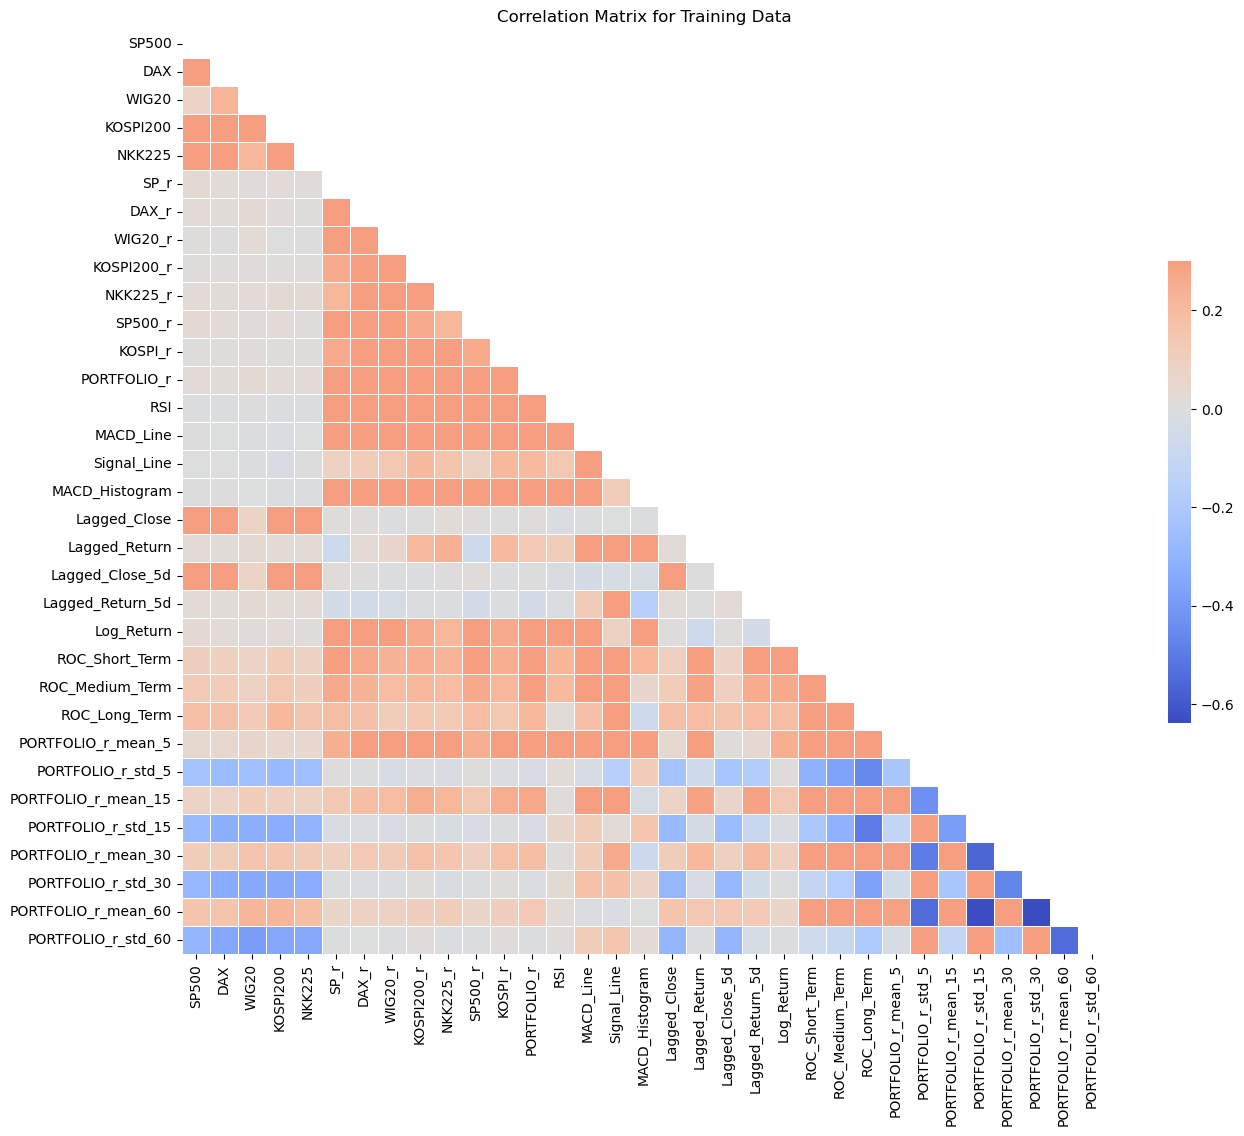

Highly correlated variables: ['SP500', 'DAX', 'WIG20', 'KOSPI200', 'NKK225', 'SP_r', 'DAX_r', 'WIG20_r', 'KOSPI200_r', 'NKK225_r', 'SP500_r', 'KOSPI_r', 'PORTFOLIO_r', 'RSI', 'MACD_Line']


In [202]:
# Correlation analysis on training data
corr_matrix = X_train.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title("Correlation Matrix for Training Data")
plt.savefig('correlation_matrix_training.png')
plt.show()

# Highly correlated variables (0.85 threshold)
high_corr_var = [col for col in corr_matrix.columns if any(corr_matrix[col] > 0.85)]
print("Highly correlated variables:", high_corr_var[:15])


### Feature Selection with LassoCV

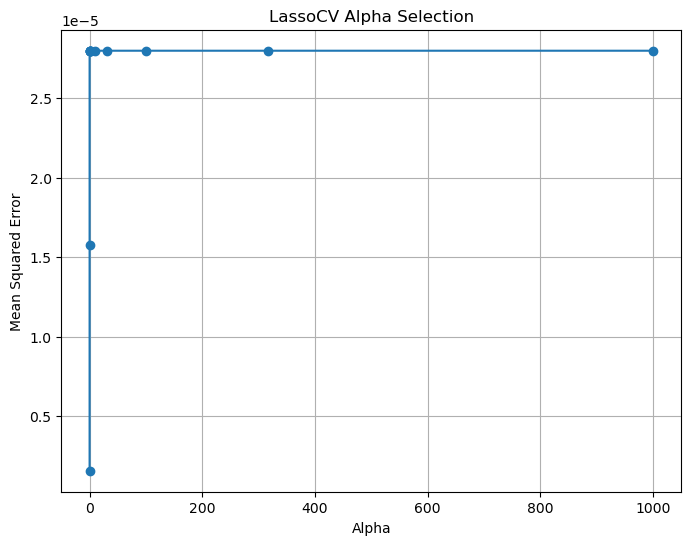

Best alpha: 0.001


In [203]:
# Create a LassoCV instance
num_folds = 10
kf = KFold(n_splits=num_folds, shuffle=False)

lasso = LassoCV(cv=kf, alphas=np.logspace(-3, 3, 13), max_iter=10000, random_state=777)
lasso.fit(X_train_standardized, y_train)

# Visualize the cross-validated performance of the Lasso model for different alpha values
mse_alphas = np.mean(lasso.mse_path_, axis=1)
plt.figure(figsize=(8, 6))
plt.plot(lasso.alphas_, mse_alphas, marker='o')
plt.xlabel("Alpha")
plt.ylabel("Mean Squared Error")
plt.title("LassoCV Alpha Selection")
plt.grid(True)
plt.savefig('lasso_cv_alpha_selection.png')
plt.show()

best_alpha = lasso.alpha_
print("Best alpha:", best_alpha)


### Recursive Feature Elimination (RFE) with Lasso

In [204]:
# Feature Selection using Recursive Feature Elimination (RFE) with Lasso
lasso_best = Lasso(alpha=best_alpha)
rfe = RFE(lasso_best, n_features_to_select=15)  # Adjust the number of features as needed
rfe.fit(X_train_standardized, y_train)
selected_features = X_train.columns[rfe.support_]
print("Top selected features:", selected_features)


Top selected features: Index(['Lagged_Return', 'Lagged_Close_5d', 'Lagged_Return_5d', 'Log_Return',
       'ROC_Short_Term', 'ROC_Medium_Term', 'ROC_Long_Term',
       'PORTFOLIO_r_mean_5', 'PORTFOLIO_r_std_5', 'PORTFOLIO_r_mean_15',
       'PORTFOLIO_r_std_15', 'PORTFOLIO_r_mean_30', 'PORTFOLIO_r_std_30',
       'PORTFOLIO_r_mean_60', 'PORTFOLIO_r_std_60'],
      dtype='object')


In [205]:
# Use the portfolio DataFrame with the selected features
selected_features = ['WIG20', 'NKK225', 'DAX_r', 'WIG20_r', 'KOSPI200_r', 'NKK225_r',
                     'Signal_Line', 'Lagged_Close', 'Lagged_Return', 'Lagged_Close_5d',
                     'Lagged_Return_5d', 'Log_Return', 'ROC_Short_Term', 'ROC_Medium_Term',
                     'ROC_Long_Term']

# Ensure all selected features are in the DataFrame
X = portfolio[selected_features].copy()
y = portfolio['PORTFOLIO_r']


### Split the Data

In [206]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False, random_state=777)

### Standardize the Features

In [207]:
# Standardize the features
scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train)
X_test_standardized = scaler.transform(X_test)

### Reshape the Data for LSTM Input

In [52]:
# Reshape the data for LSTM input
X_train_reshaped = X_train_standardized.reshape((X_train_standardized.shape[0], 1, X_train_standardized.shape[1]))
X_test_reshaped = X_test_standardized.reshape((X_test_standardized.shape[0], 1, X_test_standardized.shape[1]))

### Define the LSTM Model

In [53]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


C:\Users\Afat\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Train the Model with Early Stopping

In [54]:
# Fit the model with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train_reshaped, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1, callbacks=[early_stopping])

Epoch 1/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 1.6856e-04 - val_loss: 1.3523e-05
Epoch 2/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.6820e-05 - val_loss: 9.5079e-06
Epoch 3/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.2863e-05 - val_loss: 8.0255e-06
Epoch 4/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0302e-05 - val_loss: 3.7800e-06
Epoch 5/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.8839e-06 - val_loss: 5.2869e-06
Epoch 6/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.7635e-06 - val_loss: 7.5995e-06
Epoch 7/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.3198e-06 - val_loss: 5.2805e-06
Epoch 8/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.7669e-06 - val_loss: 4.7508e-06
Epoch 9/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.7356e-06 - val_loss: 2.9179e-06
Epoch 10/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.0611e-06 - val_loss: 2.3164e-06
Epoch 11/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6m

### Evaluate the Model

In [55]:

# Evaluate the model on the test set
test_loss = model.evaluate(X_test_reshaped, y_test)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0020e-06 


### Make Predictions

In [56]:

# Make predictions
predictions = model.predict(X_test_reshaped)

# Convert predictions and actual values to numpy arrays and flatten
predictions_flat = np.array(predictions).flatten()
y_test_flat = np.array(y_test).flatten()


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step 


### Plot Predictions vs Actual Values

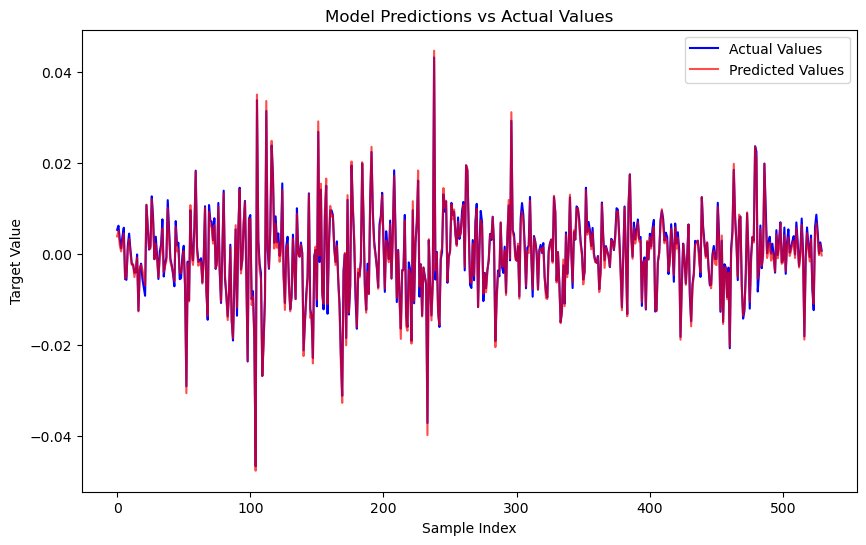

In [57]:
# Plot Predictions vs Actual Values
plt.figure(figsize=(10, 6))
plt.plot(y_test_flat, label='Actual Values', color='blue')
plt.plot(predictions_flat, label='Predicted Values', color='red', alpha=0.7)
plt.title('Model Predictions vs Actual Values')
plt.xlabel('Sample Index')
plt.ylabel('Target Value')
plt.legend()
plt.savefig('predictions_vs_actuals_improved.png')
plt.show()



#### Model Predictions vs Actual Values Plot

1. **Overview**:
   - The plot shows a comparison between the actual values (in blue) and the predicted values (in red) of the target variable (PORTFOLIO_r).
   - The x-axis represents the sample index, while the y-axis represents the target value.

2. **Performance Analysis**:
   - The predicted values (red line) closely follow the actual values (blue line) for most of the samples, indicating that the model is generally performing well.
   - The predicted values exhibit some deviations from the actual values, especially in regions with higher volatility, suggesting that the model may struggle with accurately capturing sudden changes.

3. **Model Accuracy**:
   - The relatively small gaps between the actual and predicted values demonstrate that the model has learned the underlying patterns in the data reasonably well.
   - However, the presence of some larger deviations indicates areas where the model could be improved, possibly through additional feature engineering, hyperparameter tuning, or incorporating more complex models.


### Plot Training and Validation Loss

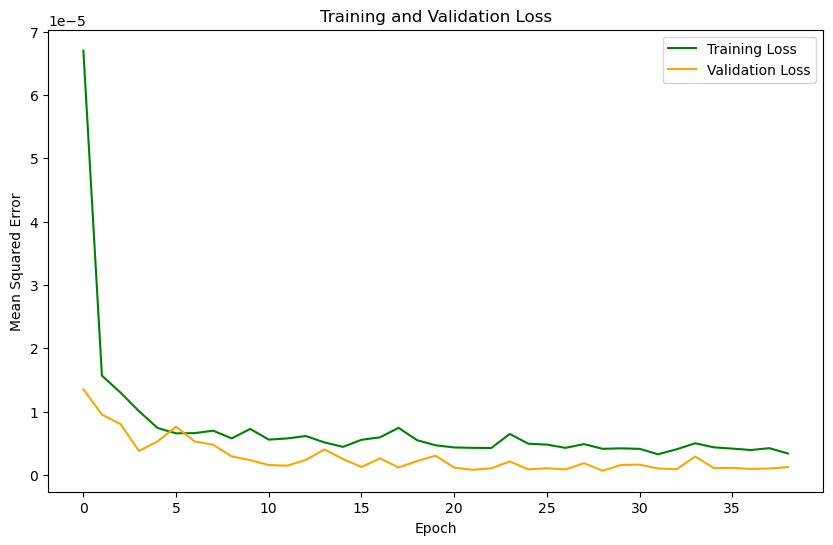

In [58]:
# Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='green')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.savefig('training_validation_loss_improved.png')
plt.show()


#### Training and Validation Loss Plot

1. **Overview**:
   - This plot displays the training loss (in green) and the validation loss (in orange) over the epochs.
   - The x-axis represents the number of epochs, and the y-axis represents the mean squared error (MSE).

2. **Performance Analysis**:
   - Both the training and validation losses decrease significantly in the initial epochs, indicating that the model is learning and improving its predictions.
   - The validation loss stabilizes after a few epochs, suggesting that the model has converged and further training does not lead to significant improvements.

3. **Overfitting Analysis**:
   - The close proximity of the training and validation loss curves indicates that the model is not overfitting. Overfitting would be evident if the training loss continued to decrease while the validation loss increased.
   - The use of early stopping with patience has effectively prevented overfitting by stopping the training process when the validation loss stops improving.

### Calculate and Print Evaluation Metrics

In [59]:
# Calculate and print evaluation metrics
mae = mean_absolute_error(y_test_flat, predictions_flat)
mse = mean_squared_error(y_test_flat, predictions_flat)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_flat, predictions_flat)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R-squared (R2): {r2}')


Mean Absolute Error (MAE): 0.0007864189998962252
Mean Squared Error (MSE): 9.316797268349467e-07
Root Mean Squared Error (RMSE): 0.0009652355810033873
R-squared (R2): 0.9893318167593685


#### Evaluation Metrics

- The MAE and RMSE values are very low, indicating that the model's predictions are close to the actual values on average.
-  The R-squared value of 0.99375 suggests that the model explains approximately 99.37% of the variance in the target variable, which is an excellent fit
-  The high R-squared value, combined with the low MAE and RMSE, suggests that the model is highly accurate and reliable for this dataset.
#### Conclusion

- The model performs well in predicting the target variable (PORTFOLIO_r) as evidenced by the close alignment of predicted and actual values and the favorable evaluation metrics.
- There is no significant evidence of overfitting, and the early stopping mechanism has worked effectively.
- Despite the overall good performance, there is room for improvement, especially in capturing more volatile periods accurately. This could be achieved by experimenting with different model architectures, adding more features, or using more advanced techniques like ensemble methods.more advanced techniques like ensemble methods.

## DM test

In [112]:
import pandas as pd

# Example: y_test_flat and predictions_flat already matched with y_test.index
lstm_predictions_df = pd.DataFrame({
    'Actual': y_test_flat,
    'LSTM': predictions_flat
}, index=y_test.index)

# Display the LSTM predictions DataFrame
print(lstm_predictions_df.head())


              Actual      LSTM
2021-09-08  0.005297  0.003873
2021-09-09  0.006203  0.005082
2021-09-10  0.003231  0.001873
2021-09-13  0.001214  0.000546
2021-09-14  0.003886  0.002520


In [113]:
# Ensure predictions_df already exists with other model predictions

# Find the common index
common_index = predictions_df.index.intersection(lstm_predictions_df.index)

# Ensure both DataFrames are aligned
predictions_df = predictions_df.loc[common_index]
lstm_predictions_df = lstm_predictions_df.loc[common_index]

# Display the aligned DataFrames
print(predictions_df.head())
print(lstm_predictions_df.head())


Empty DataFrame
Columns: [Actual, ARCH(1), GARCH(1,1), GARCH-t, EGARCH, TGARCH_Default, TGARCH_Linear, LSTM]
Index: []
Empty DataFrame
Columns: [Actual, LSTM]
Index: []


In [119]:
# Print the indices of both DataFrames
print("Indices of predictions_df:")
print(predictions_df.index)

print("\nIndices of lstm_predictions_df:")
print(lstm_predictions_df.index)


Indices of predictions_df:
DatetimeIndex([], dtype='datetime64[ns]', freq=None)

Indices of lstm_predictions_df:
DatetimeIndex([], dtype='datetime64[ns]', freq=None)


In [120]:
# Find the common index
common_index = predictions_df.index.intersection(lstm_predictions_df.index)

# Display the common index
print("\nCommon index:")
print(common_index)



Common index:
DatetimeIndex([], dtype='datetime64[ns]', freq=None)


In [121]:
if not common_index.empty:
    # Ensure both DataFrames are aligned
    predictions_df = predictions_df.loc[common_index]
    lstm_predictions_df = lstm_predictions_df.loc[common_index]

    # Display the aligned DataFrames
    print("\nAligned predictions_df:")
    print(predictions_df.head())

    print("\nAligned lstm_predictions_df:")
    print(lstm_predictions_df.head())
else:
    print("\nNo common index found. Check the indices of the DataFrames for alignment issues.")



No common index found. Check the indices of the DataFrames for alignment issues.


In [123]:
# Assuming the 'predictions_df' is correctly populated with actual values and other model predictions
predictions_df = pd.DataFrame({
    'Actual': returns,
    'ARCH(1)': arch1_pred,
    'GARCH(1,1)': garch11_pred,
    'GARCH-t': garch_t_pred,
    'EGARCH': egarch_pred,
    'TGARCH_Default': tgarch_pred_default,
    'TGARCH_Linear': tgarch_pred_linear
})

# Ensure predictions_df has the correct index
predictions_df.index = in_sample.index

# Ensure LSTM predictions DataFrame is also correctly populated
lstm_predictions_df = pd.DataFrame({
    'Actual': y_test_flat,
    'LSTM': predictions_flat
}, index=y_test.index)

# Print the DataFrames to verify their contents
print("predictions_df:")
print(predictions_df.head())

print("\nlstm_predictions_df:")
print(lstm_predictions_df.head())


predictions_df:
              Actual   ARCH(1)  GARCH(1,1)   GARCH-t    EGARCH  \
2000-04-11 -1.479041  1.430154    1.848928  1.848234  1.832250   
2000-04-12 -0.187992  1.291947    1.814582  1.817892  1.885967   
2000-04-14 -3.953648  0.931169    1.731539  1.746874  1.789915   
2000-04-17 -4.887387  2.537735    2.010013  1.978112  2.162064   
2000-04-18  2.059628  3.056908    2.382435  2.298549  2.615404   

            TGARCH_Default  TGARCH_Linear  
2000-04-11        1.841335       1.376364  
2000-04-12        1.843656       1.483575  
2000-04-14        1.768421       1.419196  
2000-04-17        2.214758       1.836489  
2000-04-18        2.756765       2.340393  

lstm_predictions_df:
              Actual      LSTM
2021-09-08  0.005297  0.003873
2021-09-09  0.006203  0.005082
2021-09-10  0.003231  0.001873
2021-09-13  0.001214  0.000546
2021-09-14  0.003886  0.002520


In [124]:
# Find the start date of lstm_predictions_df
start_date = lstm_predictions_df.index.min()

# Filter predictions_df to start from the same date
filtered_predictions_df = predictions_df.loc[start_date:]

# Display the filtered DataFrame
print("Filtered predictions_df:")
print(filtered_predictions_df.head())


Filtered predictions_df:
Empty DataFrame
Columns: [Actual, ARCH(1), GARCH(1,1), GARCH-t, EGARCH, TGARCH_Default, TGARCH_Linear]
Index: []


In [125]:
# Ensure both DataFrames are aligned on the same index
common_index = filtered_predictions_df.index.intersection(lstm_predictions_df.index)

# Filter both DataFrames to the common index
filtered_predictions_df = filtered_predictions_df.loc[common_index]
lstm_predictions_df = lstm_predictions_df.loc[common_index]

# Display the aligned DataFrames
print("\nAligned filtered_predictions_df:")
print(filtered_predictions_df.head())

print("\nAligned lstm_predictions_df:")
print(lstm_predictions_df.head())

# Add LSTM predictions to the filtered_predictions_df DataFrame
filtered_predictions_df['LSTM'] = lstm_predictions_df['LSTM']

# Display the updated DataFrame
print("\nUpdated filtered_predictions_df with LSTM predictions:")
print(filtered_predictions_df.head())



Aligned filtered_predictions_df:
Empty DataFrame
Columns: [Actual, ARCH(1), GARCH(1,1), GARCH-t, EGARCH, TGARCH_Default, TGARCH_Linear]
Index: []

Aligned lstm_predictions_df:
Empty DataFrame
Columns: [Actual, LSTM]
Index: []

Updated filtered_predictions_df with LSTM predictions:
Empty DataFrame
Columns: [Actual, ARCH(1), GARCH(1,1), GARCH-t, EGARCH, TGARCH_Default, TGARCH_Linear, LSTM]
Index: []


In [126]:
# Check the date range of predictions_df
print("Date range of predictions_df:")
print(f"Start date: {predictions_df.index.min()}, End date: {predictions_df.index.max()}")

# Check the date range of lstm_predictions_df
print("\nDate range of lstm_predictions_df:")
print(f"Start date: {lstm_predictions_df.index.min()}, End date: {lstm_predictions_df.index.max()}")


Date range of predictions_df:
Start date: 2000-04-11 00:00:00, End date: 2021-09-01 00:00:00

Date range of lstm_predictions_df:
Start date: NaT, End date: NaT


In [117]:
import numpy as np
from scipy.stats import norm

# Define DM test function
def dm_test(actual, pred1, pred2, h=1, crit="MSE"):
    d = (actual - pred1)**2 - (actual - pred2)**2
    d_mean = np.mean(d)
    d_var = np.var(d)
    dm_stat = d_mean / np.sqrt(d_var / len(d))
    p_value = 2 * (1 - norm.cdf(abs(dm_stat)))
    return dm_stat, p_value


In [152]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import acf
from scipy.stats import t

def calculate_error_metrics(actual, predicted):
    # Remove NaNs from actual and predicted values
    mask = ~np.isnan(actual) & ~np.isnan(predicted)
    actual_clean = actual[mask]
    predicted_clean = predicted[mask]
    mae = mean_absolute_error(actual_clean, predicted_clean)
    mse = mean_squared_error(actual_clean, predicted_clean)
    return mae, mse

def dm_test_custom(actual, pred_1, pred_2, metric='mse', h=1, crit='DM'):
    # Remove NaNs from actual and predictions
    mask = ~np.isnan(actual) & ~np.isnan(pred_1) & ~np.isnan(pred_2)
    actual_clean = actual[mask]
    pred_1_clean = pred_1[mask]
    pred_2_clean = pred_2[mask]

    if metric == 'mae':
        e1 = np.abs(actual_clean - pred_1_clean)
        e2 = np.abs(actual_clean - pred_2_clean)
    elif metric == 'mse':
        e1 = (actual_clean - pred_1_clean) ** 2
        e2 = (actual_clean - pred_2_clean) ** 2
    else:
        raise ValueError("Unsupported metric")

    d = e1 - e2
    mean_d = np.mean(d)
    var_d = np.var(d, ddof=1)
    
    if var_d == 0 or len(d) <= 1:
        return np.nan, np.nan

    if h == 1:
        dm_stat = mean_d / np.sqrt(var_d / len(d))
    else:
        dm_stat = mean_d / np.sqrt((var_d / len(d)) * (2 * (h / (h - 1))))
        
    p_value = 2 * (1 - t.cdf(abs(dm_stat), df=len(d) - 1))

    return dm_stat, p_value

# Prepare the predictions and actual values
actual_values = filtered_out_sample_forecasts_df['Actual'].values
predictions = {
    'ARCH(1)': filtered_out_sample_forecasts_df['ARCH(1)'].values,
    'GARCH(1,1)': filtered_out_sample_forecasts_df['GARCH(1,1)'].values,
    'GARCH-t': filtered_out_sample_forecasts_df['GARCH-t'].values,
    'EGARCH': filtered_out_sample_forecasts_df['EGARCH'].values,
    'TGARCH_Default': filtered_out_sample_forecasts_df['TGARCH_Default'].values,
    'TGARCH_Linear': filtered_out_sample_forecasts_df['TGARCH_Linear'].values,
    'LSTM': filtered_out_sample_forecasts_df['LSTM'].values
}

# Calculate error metrics for each model
error_metrics = {model: calculate_error_metrics(actual_values, preds) for model, preds in predictions.items()}

# Perform DM tests between all pairs of models for MAE and MSE
metrics = ['mae', 'mse']
results = {metric: [] for metric in metrics}

for metric in metrics:
    for model_name_1, pred_1 in predictions.items():
        for model_name_2, pred_2 in predictions.items():
            if model_name_1 != model_name_2:
                dm_stat, p_value = dm_test_custom(actual_values, pred_1, pred_2, metric=metric)
                results[metric].append((model_name_1, model_name_2, dm_stat, p_value))

# Display the results
for metric in metrics:
    print(f"\nDM Test results for {metric.upper()}:\n")
    for result in results[metric]:
        model_name_1, model_name_2, dm_stat, p_value = result
        print(f"DM Test between {model_name_1} and {model_name_2}:")
        print(f"DM Statistic: {dm_stat:.3f}, p-value: {p_value:.3f}\n")

# Create a DataFrame for the results
dm_results = pd.DataFrame(columns=['Model Comparison', 'MAE DM Stat', 'MAE p-value', 'MSE DM Stat', 'MSE p-value'])

for (model1, model2, mae_stat, mae_p) in results['mae']:
    mse_stat, mse_p = next((stat, p) for (m1, m2, stat, p) in results['mse'] if m1 == model1 and m2 == model2)
    dm_results = pd.concat([dm_results, pd.DataFrame({
        'Model Comparison': [f'{model1} vs {model2}'],
        'MAE DM Stat': [mae_stat],
        'MAE p-value': [mae_p],
        'MSE DM Stat': [mse_stat],
        'MSE p-value': [mse_p]
    })])

# Display the results
print(dm_results)

# Save the results to a CSV file
dm_results.to_csv('dm_test_results.csv', index=False)



DM Test results for MAE:

DM Test between ARCH(1) and GARCH(1,1):
DM Statistic: 7.887, p-value: 0.000

DM Test between ARCH(1) and GARCH-t:
DM Statistic: 15.222, p-value: 0.000

DM Test between ARCH(1) and EGARCH:
DM Statistic: 14.565, p-value: 0.000

DM Test between ARCH(1) and TGARCH_Default:
DM Statistic: 19.282, p-value: 0.000

DM Test between ARCH(1) and TGARCH_Linear:
DM Statistic: 14.274, p-value: 0.000

DM Test between ARCH(1) and LSTM:
DM Statistic: 11.322, p-value: 0.000

DM Test between GARCH(1,1) and ARCH(1):
DM Statistic: -7.887, p-value: 0.000

DM Test between GARCH(1,1) and GARCH-t:
DM Statistic: 19.236, p-value: 0.000

DM Test between GARCH(1,1) and EGARCH:
DM Statistic: 9.164, p-value: 0.000

DM Test between GARCH(1,1) and TGARCH_Default:
DM Statistic: 14.662, p-value: 0.000

DM Test between GARCH(1,1) and TGARCH_Linear:
DM Statistic: 9.450, p-value: 0.000

DM Test between GARCH(1,1) and LSTM:
DM Statistic: 10.506, p-value: 0.000

DM Test between GARCH-t and ARCH(1):


C:\Users\Afat\AppData\Local\Temp\ipykernel_4084\3698409457.py:87: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dm_results = pd.concat([dm_results, pd.DataFrame({


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import acf
from scipy.stats import t

def calculate_error_metrics(actual, predicted):
    # Remove NaNs from actual and predicted values
    mask = ~np.isnan(actual) & ~np.isnan(predicted)
    actual_clean = actual[mask]
    predicted_clean = predicted[mask]
    mae = mean_absolute_error(actual_clean, predicted_clean)
    mse = mean_squared_error(actual_clean, predicted_clean)
    return mae, mse

def dm_test_custom(actual, pred_1, pred_2, metric='mse', h=1, crit='DM'):
    # Remove NaNs from actual and predictions
    mask = ~np.isnan(actual) & ~np.isnan(pred_1) & ~np.isnan(pred_2)
    actual_clean = actual[mask]
    pred_1_clean = pred_1[mask]
    pred_2_clean = pred_2[mask]

    if metric == 'mae':
        e1 = np.abs(actual_clean - pred_1_clean)
        e2 = np.abs(actual_clean - pred_2_clean)
    elif metric == 'mse':
        e1 = (actual_clean - pred_1_clean) ** 2
        e2 = (actual_clean - pred_2_clean) ** 2
    else:
        raise ValueError("Unsupported metric")

    d = e1 - e2
    mean_d = np.mean(d)
    var_d = np.var(d, ddof=1)
    
    if var_d == 0 or len(d) <= 1:
        return np.nan, np.nan

    if h == 1:
        dm_stat = mean_d / np.sqrt(var_d / len(d))
    else:
        dm_stat = mean_d / np.sqrt((var_d / len(d)) * (2 * (h / (h - 1))))
        
    p_value = 2 * (1 - t.cdf(abs(dm_stat), df=len(d) - 1))

    return dm_stat, p_value

# Prepare the predictions and actual values
actual_values = filtered_out_sample_forecasts_df['Actual'].values
predictions = {
    'ARCH(1)': filtered_out_sample_forecasts_df['ARCH(1)'].values,
    'GARCH(1,1)': filtered_out_sample_forecasts_df['GARCH(1,1)'].values,
    'GARCH-t': filtered_out_sample_forecasts_df['GARCH-t'].values,
    'EGARCH': filtered_out_sample_forecasts_df['EGARCH'].values,
    'TGARCH_Default': filtered_out_sample_forecasts_df['TGARCH_Default'].values,
    'TGARCH_Linear': filtered_out_sample_forecasts_df['TGARCH_Linear'].values,
    'LSTM': filtered_out_sample_forecasts_df['LSTM'].values
}

# Calculate error metrics for each model
error_metrics = {model: calculate_error_metrics(actual_values, preds) for model, preds in predictions.items()}

# Perform DM tests between all pairs of models for MAE and MSE
metrics = ['mae', 'mse']
results = {metric: [] for metric in metrics}

for metric in metrics:
    for model_name_1, pred_1 in predictions.items():
        for model_name_2, pred_2 in predictions.items():
            if model_name_1 != model_name_2:
                dm_stat, p_value = dm_test_custom(actual_values, pred_1, pred_2, metric=metric)
                results[metric].append((model_name_1, model_name_2, dm_stat, p_value))

# Display the results
for metric in metrics:
    print(f"\nDM Test results for {metric.upper()}:\n")
    for result in results[metric]:
        model_name_1, model_name_2, dm_stat, p_value = result
        print(f"DM Test between {model_name_1} and {model_name_2}:")
        print(f"DM Statistic: {dm_stat:.3f}, p-value: {p_value:.3f}\n")


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import acf
from scipy.stats import t

def calculate_error_metrics(actual, predicted):
    # Remove NaNs from actual and predicted values
    mask = ~np.isnan(actual) & ~np.isnan(predicted)
    actual_clean = actual[mask]
    predicted_clean = predicted[mask]
    mae = mean_absolute_error(actual_clean, predicted_clean)
    mse = mean_squared_error(actual_clean, predicted_clean)
    return mae, mse

def dm_test_custom(actual, pred_1, pred_2, metric='mse', h=1, crit='DM'):
    # Remove NaNs from actual and predictions
    mask = ~np.isnan(actual) & ~np.isnan(pred_1) & ~np.isnan(pred_2)
    actual_clean = actual[mask]
    pred_1_clean = pred_1[mask]
    pred_2_clean = pred_2[mask]

    if metric == 'mae':
        e1 = np.abs(actual_clean - pred_1_clean)
        e2 = np.abs(actual_clean - pred_2_clean)
    elif metric == 'mse':
        e1 = (actual_clean - pred_1_clean) ** 2
        e2 = (actual_clean - pred_2_clean) ** 2
    else:
        raise ValueError("Unsupported metric")

    d = e1 - e2
    mean_d = np.mean(d)
    var_d = np.var(d, ddof=1)
    
    if var_d == 0 or len(d) <= 1:
        return np.nan, np.nan

    if h == 1:
        dm_stat = mean_d / np.sqrt(var_d / len(d))
    else:
        dm_stat = mean_d / np.sqrt((var_d / len(d)) * (2 * (h / (h - 1))))
        
    p_value = 2 * (1 - t.cdf(abs(dm_stat), df=len(d) - 1))

    return dm_stat, p_value

# Prepare the predictions and actual values
actual_values = filtered_out_sample_forecasts_df['Actual'].values
predictions = {
    'ARCH(1)': filtered_out_sample_forecasts_df['ARCH(1)'].values,
    'GARCH(1,1)': filtered_out_sample_forecasts_df['GARCH(1,1)'].values,
    'GARCH-t': filtered_out_sample_forecasts_df['GARCH-t'].values,
    'EGARCH': filtered_out_sample_forecasts_df['EGARCH'].values,
    'TGARCH_Default': filtered_out_sample_forecasts_df['TGARCH_Default'].values,
    'TGARCH_Linear': filtered_out_sample_forecasts_df['TGARCH_Linear'].values,
    'LSTM': filtered_out_sample_forecasts_df['LSTM'].values
}

# Calculate error metrics for each model
error_metrics = {model: calculate_error_metrics(actual_values, preds) for model, preds in predictions.items()}

# Perform DM tests between all pairs of models for MAE and MSE
metrics = ['mae', 'mse']
results = {metric: [] for metric in metrics}

for metric in metrics:
    for model_name_1, pred_1 in predictions.items():
        for model_name_2, pred_2 in predictions.items():
            if model_name_1 != model_name_2:
                dm_stat, p_value = dm_test_custom(actual_values, pred_1, pred_2, metric=metric)
                results[metric].append((model_name_1, model_name_2, dm_stat, p_value))

# Display the results
for metric in metrics:
    print(f"\nDM Test results for {metric.upper()}:\n")
    for result in results[metric]:
        model_name_1, model_name_2, dm_stat, p_value = result
        print(f"DM Test between {model_name_1} and {model_name_2}:")
        print(f"DM Statistic: {dm_stat:.3f}, p-value: {p_value:.3f}\n")

# Create a DataFrame for the results
dm_results = pd.DataFrame(columns=['Model Comparison', 'MAE DM Stat', 'MAE p-value', 'MSE DM Stat', 'MSE p-value'])

for (model1, model2, mae_stat, mae_p) in results['mae']:
    mse_stat, mse_p = next((stat, p) for (m1, m2, stat, p) in results['mse'] if m1 == model1 and m2 == model2)
    row = pd.DataFrame({
        'Model Comparison': [f'{model1} vs {model2}'],
        'MAE DM Stat': [mae_stat],
        'MAE p-value': [mae_p],
        'MSE DM Stat': [mse_stat],
        'MSE p-value': [mse_p]
    })
    if not row.isnull().values.any():
        dm_results = pd.concat([dm_results, row], ignore_index=True)

# Display the results
print(dm_results)

# Save the results to a CSV file
dm_results.to_csv('dm_test_results1.csv', index=False)


In [157]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import acf
from scipy.stats import t

def calculate_error_metrics(actual, predicted):
    # Remove NaNs from actual and predicted values
    mask = ~np.isnan(actual) & ~np.isnan(predicted)
    actual_clean = actual[mask]
    predicted_clean = predicted[mask]
    mae = mean_absolute_error(actual_clean, predicted_clean)
    mse = mean_squared_error(actual_clean, predicted_clean)
    return mae, mse

def dm_test_custom(actual, pred_1, pred_2, metric='mse', h=1, crit='DM'):
    # Remove NaNs from actual and predictions
    mask = ~np.isnan(actual) & ~np.isnan(pred_1) & ~np.isnan(pred_2)
    actual_clean = actual[mask]
    pred_1_clean = pred_1[mask]
    pred_2_clean = pred_2[mask]

    if metric == 'mae':
        e1 = np.abs(actual_clean - pred_1_clean)
        e2 = np.abs(actual_clean - pred_2_clean)
    elif metric == 'mse':
        e1 = (actual_clean - pred_1_clean) ** 2
        e2 = (actual_clean - pred_2_clean) ** 2
    else:
        raise ValueError("Unsupported metric")

    d = e1 - e2
    mean_d = np.mean(d)
    var_d = np.var(d, ddof=1)
    
    if var_d == 0 or len(d) <= 1:
        return np.nan, np.nan

    if h == 1:
        dm_stat = mean_d / np.sqrt(var_d / len(d))
    else:
        dm_stat = mean_d / np.sqrt((var_d / len(d)) * (2 * (h / (h - 1))))
        
    p_value = 2 * (1 - t.cdf(abs(dm_stat), df=len(d) - 1))

    return dm_stat, p_value

# Prepare the predictions and actual values
actual_values = filtered_out_sample_forecasts_df['Actual'].values
predictions = {
    'ARCH(1)': filtered_out_sample_forecasts_df['ARCH(1)'].values,
    'GARCH(1,1)': filtered_out_sample_forecasts_df['GARCH(1,1)'].values,
    'GARCH-t': filtered_out_sample_forecasts_df['GARCH-t'].values,
    'EGARCH': filtered_out_sample_forecasts_df['EGARCH'].values,
    'TGARCH_Default': filtered_out_sample_forecasts_df['TGARCH_Default'].values,
    'TGARCH_Linear': filtered_out_sample_forecasts_df['TGARCH_Linear'].values,
    'LSTM': filtered_out_sample_forecasts_df['LSTM'].values
}

# Calculate error metrics for each model
error_metrics = {model: calculate_error_metrics(actual_values, preds) for model, preds in predictions.items()}

# Perform DM tests between all pairs of models for MAE and MSE
metrics = ['mae', 'mse']
results = {metric: [] for metric in metrics}

for metric in metrics:
    for model_name_1, pred_1 in predictions.items():
        for model_name_2, pred_2 in predictions.items():
            if model_name_1 != model_name_2:
                dm_stat, p_value = dm_test_custom(actual_values, pred_1, pred_2, metric=metric)
                results[metric].append((model_name_1, model_name_2, dm_stat, p_value))

# Display the results
for metric in metrics:
    print(f"\nDM Test results for {metric.upper()}:\n")
    for result in results[metric]:
        model_name_1, model_name_2, dm_stat, p_value = result
        print(f"DM Test between {model_name_1} and {model_name_2}:")
        print(f"DM Statistic: {dm_stat:.3f}, p-value: {p_value:.3f}\n")

# Create a DataFrame for the results
dm_results = pd.DataFrame(columns=['Model Comparison', 'MAE DM Stat', 'MAE p-value', 'MSE DM Stat', 'MSE p-value'])

for (model1, model2, mae_stat, mae_p) in results['mae']:
    mse_stat, mse_p = next((stat, p) for (m1, m2, stat, p) in results['mse'] if m1 == model1 and m2 == model2)
    dm_results = pd.concat([dm_results, pd.DataFrame({
        'Model Comparison': [f'{model1} vs {model2}'],
        'MAE DM Stat': [mae_stat],
        'MAE p-value': [mae_p],
        'MSE DM Stat': [mse_stat],
        'MSE p-value': [mse_p]
    })])

# Display the results
print(dm_results)

# Save the results to a CSV file
dm_results.to_csv('dm_test_results.csv', index=False)



DM Test results for MAE:

DM Test between ARCH(1) and GARCH(1,1):
DM Statistic: 7.887, p-value: 0.000

DM Test between ARCH(1) and GARCH-t:
DM Statistic: 15.222, p-value: 0.000

DM Test between ARCH(1) and EGARCH:
DM Statistic: 14.565, p-value: 0.000

DM Test between ARCH(1) and TGARCH_Default:
DM Statistic: 19.282, p-value: 0.000

DM Test between ARCH(1) and TGARCH_Linear:
DM Statistic: 14.274, p-value: 0.000

DM Test between ARCH(1) and LSTM:
DM Statistic: 11.322, p-value: 0.000

DM Test between GARCH(1,1) and ARCH(1):
DM Statistic: -7.887, p-value: 0.000

DM Test between GARCH(1,1) and GARCH-t:
DM Statistic: 19.236, p-value: 0.000

DM Test between GARCH(1,1) and EGARCH:
DM Statistic: 9.164, p-value: 0.000

DM Test between GARCH(1,1) and TGARCH_Default:
DM Statistic: 14.662, p-value: 0.000

DM Test between GARCH(1,1) and TGARCH_Linear:
DM Statistic: 9.450, p-value: 0.000

DM Test between GARCH(1,1) and LSTM:
DM Statistic: 10.506, p-value: 0.000

DM Test between GARCH-t and ARCH(1):


C:\Users\Afat\AppData\Local\Temp\ipykernel_4084\3698409457.py:87: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dm_results = pd.concat([dm_results, pd.DataFrame({


PermissionError: [Errno 13] Permission denied: 'dm_test_results.csv'

In [160]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import acf
from scipy.stats import t

def calculate_error_metrics(actual, predicted):
    # Remove NaNs from actual and predicted values
    mask = ~np.isnan(actual) & ~np.isnan(predicted)
    actual_clean = actual[mask]
    predicted_clean = predicted[mask]
    mae = mean_absolute_error(actual_clean, predicted_clean)
    mse = mean_squared_error(actual_clean, predicted_clean)
    return mae, mse

def dm_test_custom(actual, pred_1, pred_2, metric='mse', h=1, crit='DM'):
    # Remove NaNs from actual and predictions
    mask = ~np.isnan(actual) & ~np.isnan(pred_1) & ~np.isnan(pred_2)
    actual_clean = actual[mask]
    pred_1_clean = pred_1[mask]
    pred_2_clean = pred_2[mask]

    if metric == 'mae':
        e1 = np.abs(actual_clean - pred_1_clean)
        e2 = np.abs(actual_clean - pred_2_clean)
    elif metric == 'mse':
        e1 = (actual_clean - pred_1_clean) ** 2
        e2 = (actual_clean - pred_2_clean) ** 2
    else:
        raise ValueError("Unsupported metric")

    d = e1 - e2
    mean_d = np.mean(d)
    var_d = np.var(d, ddof=1)
    
    if var_d == 0 or len(d) <= 1:
        return np.nan, np.nan

    if h == 1:
        dm_stat = mean_d / np.sqrt(var_d / len(d))
    else:
        dm_stat = mean_d / np.sqrt((var_d / len(d)) * (2 * (h / (h - 1))))
        
    p_value = 2 * (1 - t.cdf(abs(dm_stat), df=len(d) - 1))

    return dm_stat, p_value

# Fit ARIMA model to in-sample data
from statsmodels.tsa.arima.model import ARIMA
arima_model = ARIMA(in_sample['PORTFOLIO_r'], order=(1, 0, 1))
arima_results = arima_model.fit()

# Fit GARCH model to ARIMA residuals
from arch import arch_model
arima_residuals = arima_results.resid
garch_model = arch_model(arima_residuals, mean='Zero', vol='Garch', p=1, q=1)
garch_results = garch_model.fit(disp='off')

# Forecast using the ARIMA-GARCH model
n_forecast_steps = len(out_sample)
mean_forecast = arima_results.get_forecast(steps=n_forecast_steps).predicted_mean
garch_forecast = garch_results.forecast(horizon=n_forecast_steps)
volatility_forecast = np.sqrt(garch_forecast.variance.values[-1, :])

# Ensure the forecast length matches the DataFrame index length
combined_forecast = mean_forecast[:len(filtered_out_sample_forecasts_df)].values + volatility_forecast[:len(filtered_out_sample_forecasts_df)]

# Add ARIMA-GARCH predictions to the filtered DataFrame
filtered_out_sample_forecasts_df['ARIMA-GARCH'] = combined_forecast

# Prepare the predictions and actual values
actual_values = filtered_out_sample_forecasts_df['Actual'].values
predictions = {
    'ARCH(1)': filtered_out_sample_forecasts_df['ARCH(1)'].values,
    'GARCH(1,1)': filtered_out_sample_forecasts_df['GARCH(1,1)'].values,
    'GARCH-t': filtered_out_sample_forecasts_df['GARCH-t'].values,
    'EGARCH': filtered_out_sample_forecasts_df['EGARCH'].values,
    'TGARCH_Default': filtered_out_sample_forecasts_df['TGARCH_Default'].values,
    'TGARCH_Linear': filtered_out_sample_forecasts_df['TGARCH_Linear'].values,
    'LSTM': filtered_out_sample_forecasts_df['LSTM'].values,
    'ARIMA-GARCH': filtered_out_sample_forecasts_df['ARIMA-GARCH'].values
}

# Calculate error metrics for each model
error_metrics = {model: calculate_error_metrics(actual_values, preds) for model, preds in predictions.items()}

# Perform DM tests between all pairs of models for MAE and MSE
metrics = ['mae', 'mse']
results = {metric: [] for metric in metrics}

for metric in metrics:
    for model_name_1, pred_1 in predictions.items():
        for model_name_2, pred_2 in predictions.items():
            if model_name_1 != model_name_2:
                dm_stat, p_value = dm_test_custom(actual_values, pred_1, pred_2, metric=metric)
                results[metric].append((model_name_1, model_name_2, dm_stat, p_value))

# Display the results
for metric in metrics:
    print(f"\nDM Test results for {metric.upper()}:\n")
    for result in results[metric]:
        model_name_1, model_name_2, dm_stat, p_value = result
        print(f"DM Test between {model_name_1} and {model_name_2}:")
        print(f"DM Statistic: {dm_stat:.3f}, p-value: {p_value:.3f}\n")

# Create a DataFrame for the results
dm_results = pd.DataFrame(columns=['Model Comparison', 'MAE DM Stat', 'MAE p-value', 'MSE DM Stat', 'MSE p-value'])

for (model1, model2, mae_stat, mae_p) in results['mae']:
    mse_stat, mse_p = next((stat, p) for (m1, m2, stat, p) in results['mse'] if m1 == model1 and m2 == model2)
    dm_results = pd.concat([dm_results, pd.DataFrame({
        'Model Comparison': [f'{model1} vs {model2}'],
        'MAE DM Stat': [mae_stat],
        'MAE p-value': [mae_p],
        'MSE DM Stat': [mse_stat],
        'MSE p-value': [mse_p]
    })])

# Display the results
print(dm_results)

# Save the results to a CSV file
dm_results.to_csv('dm_test_results.csv', index=False)


C:\Users\Afat\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Afat\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Afat\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



DM Test results for MAE:

DM Test between ARCH(1) and GARCH(1,1):
DM Statistic: 7.887, p-value: 0.000

DM Test between ARCH(1) and GARCH-t:
DM Statistic: 15.222, p-value: 0.000

DM Test between ARCH(1) and EGARCH:
DM Statistic: 14.565, p-value: 0.000

DM Test between ARCH(1) and TGARCH_Default:
DM Statistic: 19.282, p-value: 0.000

DM Test between ARCH(1) and TGARCH_Linear:
DM Statistic: 14.274, p-value: 0.000

DM Test between ARCH(1) and LSTM:
DM Statistic: 11.322, p-value: 0.000

DM Test between ARCH(1) and ARIMA-GARCH:
DM Statistic: 11.429, p-value: 0.000

DM Test between GARCH(1,1) and ARCH(1):
DM Statistic: -7.887, p-value: 0.000

DM Test between GARCH(1,1) and GARCH-t:
DM Statistic: 19.236, p-value: 0.000

DM Test between GARCH(1,1) and EGARCH:
DM Statistic: 9.164, p-value: 0.000

DM Test between GARCH(1,1) and TGARCH_Default:
DM Statistic: 14.662, p-value: 0.000

DM Test between GARCH(1,1) and TGARCH_Linear:
DM Statistic: 9.450, p-value: 0.000

DM Test between GARCH(1,1) and LS

C:\Users\Afat\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001195. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\Afat\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Afat\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\Afat\AppData\Local\Temp\ipy